In [ ]:
# %pip install -U pip datasets ipywidgets
# For mac OS
# %pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1 keras-nlp
# 20240803, tensorflow-text can be installed on Apple Silicon mac now!
# %pip install tensorflow-text
# For Intel mac
# %pip install -U tensorflow==2.16.2 tensorflow-text keras==3.4.1 keras-nlp
# For AWS SageMaker
# %pip install -U tensorflow==2.16.2 tensorflow-datasets tensorflow-text keras==3.4.1 keras-nlp datasets rouge-score py7zr

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Utility function to determine where this note is running
import platform

def is_running_on_apple_silicon():
    """
    Determine if this is running on Apple Silicon Mac.
    """
    return platform.system() == "Darwin" and platform.processor() == "arm"

def is_running_on_intel_mac():
    """
    Determine if this is running on Intel Mac.
    """
    return platform.system() == "Darwin" and platform.processor() == "i386"

# This flag is used for tf.debugging.experimental.enable_dump_debug_info.
# However, this makes 10 times slower.
DEBUGGER_V2 = False

In [3]:
import tensorflow as tf
import keras
import keras_nlp
print("Tensorflow 2.17.0 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

if is_running_on_apple_silicon() or is_running_on_intel_mac():
    FLOAT_TYPE = tf.float32
else:
    """
    # Mixed-precision training
    Deep Learning with Python, Second Edition
    François Chollet

    However, this makes the processing 2.x slower on M2 Apple Silicon.

    Machine | 1 step
    --- | ---
    Intel Mac - fp32 : fp16 | 1 : 1.714
    Apple Silicon M2 (Mac Book Pro) - fp32 : fp16 | 1 : 2.813
    NVIDIA V100 GPU x 1 (ml.p3.2xlarge) - fp32 : fp16 | 1 : 0.875    Intel Mac - fp32 : fp16 | 1 : 1.714
    """
    keras.mixed_precision.set_global_policy("mixed_float16")
    FLOAT_TYPE = tf.float16

import numpy as np
import tensorflow_datasets as tfds
# SageMaker cannot use @keras.saving
from keras import saving
import datetime
import time

Tensorflow 2.17.0 is expected. The running version is 2.17.0
Keras 3.4.1 is expected. The running version is 3.4.1
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [4]:
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )

    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()

def plot_attention_head(
        in_tokens,
        translated_tokens,
        attention):
    # The model didn't generate `[start]` in the output. Skip it.
    translated_tokens = translated_tokens[1:]

    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))

    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)

    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)

def plot_attention_weights(
        vectorization_layer,
        sentence,
        translated_tokens,
        attention_heads):
    in_tokens = tf.convert_to_tensor([sentence])
    in_tokens = vectorization_layer.tokenize(in_tokens).to_tensor()
    in_tokens = vectorization_layer.lookup(in_tokens)[0]

    fig = plt.figure(figsize=(16, 8))
    for h, head in enumerate(attention_heads):
        ax = fig.add_subplot(2, 4, h+1)
        plot_attention_head(in_tokens, translated_tokens, head)
        ax.set_xlabel(f'Head {h+1}')
    plt.tight_layout()
    plt.show()

In [5]:
def get_log_dir(now):
    """
    Specify the log directory for the timestamp
    """
    log_dir = "logs/fit/" + now.strftime("%Y%m%d-%H%M%S")
    return log_dir

def get_tensorboard_callback(now):
    """
    Create the TensorBoard callback
    """
    # @see https://www.tensorflow.org/tensorboard/get_started
    log_dir = get_log_dir(now=now)
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    return tensorboard_callback

In [6]:
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace("'", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    """
    Define the custom standardization to remove useless characters.
    """
    input_string = tf.strings.lower(input_string) # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'\s', ' ') # Replace \n, \r, \t, \f into space.
    #input_string = tf.strings.regex_replace(input_string, r"'", ' ') # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'<\/?[^>]*>', '') # html tag
    #input_string = tf.strings.regex_replace(input_string, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '') # html tag
    input_string = tf.strings.regex_replace(input_string, r'https?:\/\/.*[\r\n]*', " ") # URL
    # Some symbols are incorrectly used without space.
    input_string = tf.strings.regex_replace(input_string, r"([%s])" % re.escape(strip_chars), r" \1 ")
    input_string = tf.strings.regex_replace(input_string, r'\s\s+', ' ') # Finally, spaces to 1 space
    return input_string

In [7]:
# @see https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr_callbacks = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=4,
    verbose=1,
    min_delta=0.04,
    cooldown=6,
    min_lr=2e-6, # 5e-4: 0.0005, 2e-5: 0.00002, 2e-6: 0.000002
)

In [8]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [9]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# @saving.register_keras_serializable()
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1) # last index
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=FLOAT_TYPE)
#     mask = tf.cast(y_true != 0, dtype=FLOAT_TYPE)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=FLOAT_TYPE)
    mask = tf.cast(mask, dtype=FLOAT_TYPE)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [10]:
def rouge_n(y_true, y_pred, order=2):
    rouge_n = keras_nlp.metrics.RougeN(order=order)
    return rouge_n(y_true, y_pred)

## Dataset

In [11]:
import datasets

def prepare_datasets():
    """
    Get training set, validation set, and test set
    tensorflow_datasets does not work well with the SSL error.
    Therefore, the data is obtained with the Huggingface library and converted to Tensorflow.
    :return: train_ds
    :return: validation_ds
    :return: test_ds
    """
    # How to convert huggingface dataset to tensorflow dataset
    # @see https://huggingface.co/docs/datasets/v1.3.0/torch_tensorflow.html#setting-the-format
    def convert_hf2tf(
            dataset: datasets.DatasetDict,
            split: list[str],
            columns=['article', 'highlights', 'id',]):
        dataset.set_format(
            type='tensorflow',
            columns=columns
        )
        l = []
        for s in split:
            d = dataset[s]
            features = {x: d[x] for x in columns}
            # .batch(32) is not used to show a simple sampled data below with take(1)
            tf_dataset = tf.data.Dataset.from_tensor_slices(features)
            l.append(tf_dataset)
        return tuple(l)
    ds = datasets.load_dataset(
        'Samsung/samsum',
        trust_remote_code=True
    )
    train_ds, validation_ds, test_ds = convert_hf2tf(
        dataset=ds,
        split=['train', 'validation', 'test'],
        columns=['id', 'summary', 'dialogue'],
    )
    return train_ds, validation_ds, test_ds

In [12]:
def prepare_tokenizer(
        vectorization_layer,
        encoder_sequence_length,
        decoder_sequence_length,
        max_tokens=15000):
    """
    Display the plot that indicates the loss and accuracy.
    :param vectorization_layer: obtain vocabulary.
    :param max_tokens: In other words, this is the vocabulary size.
    :param encoder_sequence_length: The sequence length for input.
    :param input_output_sequence_length: The sequence length for target.
    """
    vocabulary = vectorization_layer.get_vocabulary()

    input_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=encoder_sequence_length,
    )
    target_vectorization_layer = keras.layers.TextVectorization(
        standardize=custom_standardization,
        max_tokens=max_tokens,
        output_mode='int',
        output_sequence_length=decoder_sequence_length,
    )
    input_vectorization_layer.set_vocabulary(vocabulary)
    target_vectorization_layer.set_vocabulary(vocabulary)
    return input_vectorization_layer, target_vectorization_layer

def build_datasets(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        batch_size,
        encoder_sequence_length,
        decoder_sequence_length):
    """
    vectorization_layer(['This is a pen', 'I am a software engineer'])
    #vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    # 2
    rows = vectorization_layer(['This is a pen', 'I am a software engineer']).row_lengths().shape[0]
    vectorization_layer(['This is a pen', 'I am a software engineer']).to_tensor(shape=(rows, 10))
    # .to_tensor()

    RaggedTensor.to_tensor can make 0-filled Tensor
    """
    def format_dataset(x):
        # decoder_sequence_length: either the following 2.
        # - decoder input: [start] + sentence
        # - decoder output: sentence + [end]
        # That is, decoder_sequence_length = sentence length + 1
        summarized_text_length = decoder_sequence_length - 1

        d = vectorization_layer(x['dialogue'])
        r = d.row_lengths().shape[0]
        dialogue = d.to_tensor(shape=(r, encoder_sequence_length))

        start_oov = vectorization_layer(['[start]']).to_tensor(shape=(1, 1))
        end_oov = vectorization_layer(['[end]']).to_tensor(shape=(1, 1))
        summary = vectorization_layer(x['summary'])
        """
        print(h.row_lengths().shape[0]) None
        print(tf.shape(h)[0]) Tensor("RaggedShape/Cast_3:0", shape=(), dtype=int32)
        At the last step, the number of rows is not equal to the batch size.
        """
        rows = tf.shape(summary)[0]
        summary = summary[:rows, :summarized_text_length]
        start_oov = tf.repeat(start_oov, repeats=rows , axis=0)
        end_oov = tf.repeat(end_oov, repeats=rows , axis=0)
        summary = tf.concat([start_oov, summary, end_oov], axis=1)

        sequences = summary.to_tensor(shape=(
            rows,
            summarized_text_length + 1 + 1 # start + sentence + end
        ))

        summary_decoder_input = sequences[:, :-1] # start + sentence
        summary_decoder_output = sequences[:, 1:] # sentence + end
        return (
            (
                dialogue, # encoder input
                summary_decoder_input, # decoder input
            ),
            summary_decoder_output, # decoder output
            tf.cast((summary_decoder_output != 0), dtype=FLOAT_TYPE)
        )
    train_ds = train_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    if validation_ds is not None:
        validation_ds = validation_ds.batch(batch_size).map(
            format_dataset,
            num_parallel_calls=tf.data.AUTOTUNE
        ).prefetch(tf.data.AUTOTUNE).cache()
    test_ds = test_ds.batch(batch_size).map(
        format_dataset,
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE).cache()
    return train_ds, validation_ds, test_ds


## Model

In [13]:
@saving.register_keras_serializable()
class TransformerEncoderDecoderModel(keras.Model):
    """
    Transformer model class that contains Transformer Encoder and Decoder inside.
    :param encoder_tokenizer: tf.keras.layers.TextVectorization object
    :param decoder_tokenizer: tf.keras.layers.TextVectorization object
    :num_encoders: the number of encoders
    :num_decoders: the number of decoders
    :num_heads: the number of heads (Attention mechanism)
    :dropout: the dropout rate
    :transformer_intermediate_dim: the number of dimensions in each encoder and decoder
    :normalize_first: Pre-Layer Normalization or Post-Layer Normalization
    :layer_norm_epsilon: the epsilon value in layer normalization components.
    :encoder_vocabulary_size: the number of encoder vocabulary size
    :decoder_vocabulary_size: the number of decoder vocabulary size
    :embedding_dim: the dimension for embedding
    :mask_zero: whether 0 is used the mask value
    :encoder_sequence_length: the length of encoder sequence
    :decoder_sequence_length: the length of decoder sequence
    :use_residual: whether residual connections are used outside of the Transformer encoder and decoder
    """
    def __init__(
        self,
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        dropout,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        encoder_sequence_length,
        decoder_sequence_length,
        use_residual,
        **kwargs):
        super(TransformerEncoderDecoderModel, self).__init__(**kwargs)
        self.mask_zero = mask_zero
        self.layer_norm_epsilon = layer_norm_epsilon
        self.use_residual = use_residual
        self.encoders = []
        self.decoders = []
        if isinstance(layer_norm_epsilon, list):
            encoder_layer_norm_epsilons = layer_norm_epsilon
            decoder_layer_norm_epsilons = layer_norm_epsilon
        else:
            encoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_encoders)]
            decoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_decoders)]

        for i in range(num_encoders):
            self.encoders.append(
                keras_nlp.layers.TransformerEncoder(
                    num_heads=num_heads,
                    dropout=dropout,
                    intermediate_dim=transformer_intermediate_dim,
                    normalize_first=normalize_first,
                    layer_norm_epsilon=encoder_layer_norm_epsilons[i],
                    name=f"encoder_{i}",
                )
            )
        for i in range(num_decoders):
            self.decoders.append(
                keras_nlp.layers.TransformerDecoder(
                    num_heads=num_heads,
                    dropout=dropout,
                    intermediate_dim=transformer_intermediate_dim,
                    normalize_first=normalize_first,
                    layer_norm_epsilon=decoder_layer_norm_epsilons[i],
                    name=f"decoder_{i}",
                )
            )

        self.encoder_tokenizer = encoder_tokenizer
        self.decoder_tokenizer = decoder_tokenizer

        self.encoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=encoder_vocabulary_size,
            sequence_length=encoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=mask_zero,
            name="encoder_embed",
        )

        self.decoder_embedding = keras_nlp.layers.TokenAndPositionEmbedding(
            vocabulary_size=decoder_vocabulary_size,
            sequence_length=decoder_sequence_length,
            embedding_dim=embedding_dim,
            mask_zero=mask_zero,
            name="decoder_embed",
        )

        self.dense = keras.layers.Dense(
            decoder_vocabulary_size,
            name="dense",
        )

    def build(self, input_shape):
        """
        This method must set the shapes of tensors into every layer.
        @see https://github.com/keras-team/keras/issues/19535#issuecomment-2060299275
        fcollet has answered and explained how to implement for the following warning.

        ```
        UserWarning: `build()` was called on layer 'transformer_encoder_decoder_model_*',
        however the layer does not have a `build()` method implemented and it looks like it has unbuilt state.
        This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line.
        Make sure to implement a proper `build()` method
        ```

        The incorrect implementation of this method causes the following problem:
        - When the model is generated from .keras file, the loaded model does not work correctly.
        """
        self.encoder_embedding.build(input_shape[0])
        self.decoder_embedding.build(input_shape[1])
        encoder_output_shape = self.encoder_embedding.compute_output_shape(input_shape[0])
        decoder_output_shape = self.decoder_embedding.compute_output_shape(input_shape[1])

        for encoder in self.encoders:
            encoder.build(inputs_shape=encoder_output_shape)
            encoder_output_shape = encoder.compute_output_shape(
                inputs_shape=encoder_output_shape
            )
        for decoder in self.decoders:
            decoder.build(
                decoder_sequence_shape=decoder_output_shape,
                encoder_sequence_shape=encoder_output_shape,
            )
            decoder_output_shape = decoder.compute_output_shape(
                decoder_sequence_shape=decoder_output_shape,
            )

        self.dense.build(input_shape=decoder_output_shape)
        self.built = True

    def call(self, inputs, training=False):
        """
        This method defines and represents the calculation graph (tensor flow).
        :training: True, when calculating val_loss and val_acc. Otherwise, False.
        """
        encoder_input, decoder_input = (
            inputs[0],
            inputs[1],
        )
        encoded = self.encoder_embedding(encoder_input)
        for encoder in self.encoders:
            if self.use_residual and len(self.encoders) > 1:
                residual = encoded
            encoded = encoder(
                inputs=encoded,
                training=training,
            )
            if self.use_residual and len(self.encoders) > 1:
                encoded = encoded + residual

        decoded = self.decoder_embedding(decoder_input)
        for decoder in self.decoders:
            if self.use_residual and len(self.decoders) > 1:
                residual = decoded
            decoded = decoder(
                decoder_sequence=decoded,
                encoder_sequence=encoded,
                use_causal_mask=True,
                training=training,
            )
            if self.use_residual and len(self.decoders) > 1:
                decoded = decoded + residual

        output = self.dense(decoded)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del output._keras_mask
        except AttributeError:
            pass
        return output

    def get_config(self):
        """
        This method is used to save a model into a file.
        """
        config = super(TransformerEncoderDecoderModel, self).get_config().copy()
        config.update({
            "encoder_tokenizer": self.encoder_tokenizer.get_config(),
            "decoder_tokenizer": self.decoder_tokenizer.get_config(),
            "num_encoders": len(self.encoders),
            "num_decoders": len(self.decoders),
            "num_heads": self.encoders[0].num_heads,
            "dropout" : self.encoders[0].dropout,
            "transformer_intermediate_dim": self.encoders[0].intermediate_dim,
            "normalize_first": self.encoders[0].normalize_first,
            "layer_norm_epsilon": self.layer_norm_epsilon,
            "encoder_vocabulary_size": self.encoder_embedding.vocabulary_size,
            "decoder_vocabulary_size": self.decoder_embedding.vocabulary_size,
            "embedding_dim": self.encoder_embedding.embedding_dim,
            "mask_zero": self.mask_zero,
            "encoder_sequence_length": self.encoder_embedding.sequence_length,
            "decoder_sequence_length": self.decoder_embedding.sequence_length,
            "use_residual": self.use_residual,
        })
        return config
    @classmethod
    def from_config(cls, config):
        """
        This method is used to build a model from a saved file.
        """
        encoder_tokenizer_config = config.pop("encoder_tokenizer")
        decoder_tokenizer_config = config.pop("decoder_tokenizer")
        encoder_tokenizer = keras.layers.TextVectorization.from_config(encoder_tokenizer_config)
        decoder_tokenizer = keras.layers.TextVectorization.from_config(decoder_tokenizer_config)
        return cls(
            encoder_tokenizer=encoder_tokenizer,
            decoder_tokenizer=decoder_tokenizer,
            **config
        )

# Decode and Predict

In [14]:
import nltk

EXAMPLES = [
    """(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory was never seriously in doubt once he got the baton safely in hand from Ashmeade, while Gatlin and the United States third leg runner Rakieem Salaam had problems. Gatlin strayed out of his lane as he struggled to get full control of their baton and was never able to get on terms with Bolt. Earlier, Jamaica\'s women underlined their dominance in the sprint events by winning the 4x100m relay gold, anchored by Shelly-Ann Fraser-Pryce, who like Bolt was completing a triple. Their quartet recorded a championship record of 41.29 seconds, well clear of France, who crossed the line in second place in 42.73 seconds. Defending champions, the United States, were initially back in the bronze medal position after losing time on the second handover between Alexandria Anderson and English Gardner, but promoted to silver when France were subsequently disqualified for an illegal handover. The British quartet, who were initially fourth, were promoted to the bronze which eluded their men\'s team. Fraser-Pryce, like Bolt aged 26, became the first woman to achieve three golds in the 100-200 and the relay. In other final action on the last day of the championships, France\'s Teddy Tamgho became the third man to leap over 18m in the triple jump, exceeding the mark by four centimeters to take gold. Germany\'s Christina Obergfoll finally took gold at global level in the women\'s javelin after five previous silvers, while Kenya\'s Asbel Kiprop easily won a tactical men\'s 1500m final. Kiprop\'s compatriot Eunice Jepkoech Sum was a surprise winner of the women\'s 800m. Bolt\'s final dash for golden glory brought the eight-day championship to a rousing finale, but while the hosts topped the medal table from the United States there was criticism of the poor attendances in the Luzhniki Stadium. There was further concern when their pole vault gold medalist Yelena Isinbayeva made controversial remarks in support of Russia\'s new laws, which make "the propagandizing of non-traditional sexual relations among minors" a criminal offense. She later attempted to clarify her comments, but there were renewed calls by gay rights groups for a boycott of the 2014 Winter Games in Sochi, the next major sports event in Russia.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend .""",
    "There are two chickens in the garden.",
    "Two chickens fell into the swimming pool in the garden.",
]

def post_process(text):
    text = text.replace("[start] ", "")
    text = text.replace(" [end]", "")
    sentences = nltk.sent_tokenize(text)
    ss = []
    for sentence in sentences:
        sentence = sentence.capitalize()
        tokens = nltk.tokenize.word_tokenize(text=sentence)
        tagged_tokens = nltk.tag.pos_tag(tokens=tokens)
        result = []
        for i, (token, tag) in enumerate(tagged_tokens):
            if i == 0:  # The first word of the sentence
                result.append(token.capitalize())
            elif tag.startswith('NNP'):  # proper noun
                result.append(token.capitalize())
            else:
                result.append(token.lower())
        s = " ".join(result)
        ss.append(s)
    text = " ".join(ss)
    text = text.replace(" ,", ",")
    text = text.replace(" .", ".")
    # Revert OOV.
    # text = '[start] ' + text + ' [end]'
    return text

def decode_sequence(
        input_sentence,
        model,
        max_sequence_length,
        lookup_table,
        use_post_processing=False):
    """
    Generate summarized text from the input sentence.
    :input_sentence: the original text that is summarized
    :model: the TransformerEncoderDecoderModel class model
    :max_sequence_length: the maximum length of the summarized text
    :lookup_table: the table holds token IDs and their actual words
    """
    encoder_tokenizer = model.encoder_tokenizer
    decoder_tokenizer = model.decoder_tokenizer
    tokenized_input = encoder_tokenizer([input_sentence])

    start_token = decoder_tokenizer("[start]")[0].numpy()
    end_token = decoder_tokenizer("[end]")[0].numpy()

    decoded_sentence = [start_token]
    for i in range(max_sequence_length):
        decoder_inputs = tf.convert_to_tensor(
            [decoded_sentence],
            dtype="int64",
        )
        decoder_inputs = tf.concat(
            [
                decoder_inputs,
                tf.zeros(
                    [1, max_sequence_length - i - 1],
                    dtype="int64",
                ),
            ],
            axis=1,
        )
        input = (
            tokenized_input,
            decoder_inputs,
        )
        predictions = model(input)
        predicted_token = np.argmax(predictions[0, i, :])
        decoded_sentence.append(predicted_token)
        if predicted_token == end_token:
            break

    detokenized_output = []
    for token in decoded_sentence:
        detokenized_output.append(lookup_table[token])
    text = " ".join(detokenized_output)
    if use_post_processing:
        text = post_process(text=text)
    return text


def predict_main(
        filepath,
        examples,
        decoder_sequence_length,
        use_post_processing=False):
    """
    Generate summarized text with the model file.
    :filepath: the file path specifies the model
    :examples: the list of text that is summarized.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    loaded_model = keras.models.load_model(
        filepath,
        # Just in case, TransformerEncoderDecoderModel is specified.
        # However, it does not seem necessary.
        custom_objects={
            "TransformerEncoderDecoderModel": TransformerEncoderDecoderModel,
        }
    )

    decoder_tokenizer = loaded_model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                loaded_model,
                decoder_sequence_length,
                index_lookup_table,
                use_post_processing=use_post_processing,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_model(
        model,
        examples,
        decoder_sequence_length,
        use_post_processing=False):
    """
    Generate summarized text with the model.
    :model: the file path specifies the model
    :examples: the list of text that is summarized.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    summarized = []
    for example in examples:
        summarized.append(
            decode_sequence(
                example,
                model,
                decoder_sequence_length,
                index_lookup_table,
                use_post_processing=use_post_processing,
            )
        )

    for i in range(len(examples)):
        print("ORIGINAL SENTENCE: ", examples[i])
        print("SUMMARIZED RESULT: ", summarized[i])

def predict_dataset(
        model,
        iterable_dataset,
        decoder_sequence_length,
        use_post_processing=False):
    """
    Generate summarized text with the model.
    :model: the file path specifies the model
    :iterable_dataset: the dataset, which is mainly test set, used to generate summarized text.
    :decoder_sequence_length: the maximum length of the summarized text.
    """
    decoder_tokenizer = model.decoder_tokenizer
    vocab = decoder_tokenizer.get_vocabulary()
    index_lookup_table = dict(zip(range(len(vocab)), vocab))

    y_trues = []
    y_preds = []
    for entry in iterable_dataset:
        text = entry["dialogue"]
        result = decode_sequence(
            text,
            model,
            decoder_sequence_length,
            index_lookup_table,
            use_post_processing=use_post_processing,
        )
        y_true = entry["summary"]
        y_true = y_true.decode('utf-8')
        y_pred = result.replace('[start]', '').replace('[end]', '').strip()
        # print(y_true, '\n\t' , y_pred)
        y_trues.append(y_true)
        y_preds.append(y_pred)
    return y_trues, y_preds

def calculate_rouge_score(y_true, y_pred):
    """
    # RougeN metric
    # @see https://keras.io/api/keras_nlp/metrics/rouge_n/
    """
    rouge_n = keras_nlp.metrics.RougeN(order=2)
    rouge_2_score = rouge_n(y_true, y_pred)
    rouge_n = keras_nlp.metrics.RougeN(order=1)
    rouge_1_score = rouge_n(y_true, y_pred)
    rouge_l = keras_nlp.metrics.RougeL()
    rouge_l_score = rouge_l(y_true, y_pred)
    return rouge_1_score, rouge_2_score, rouge_l_score

## Train

In [15]:
def run_training(
        model,
        train_ds,
        validation_ds,
        optimizer,
        epochs,
        steps_per_epoch,
        now,
        verbose,
        callbacks=[]):
    """
    Run training.
    :train_ds: training set
    :validation_ds: validation set
    :optimizer: optimizer.Optimizer
    :epochs: the number of epochs
    :steps_per_epoch: the number of weight updates in a epoch
    :now: timestamp
    """
    metrics = [
        masked_acc,
        #keras.metrics.SparseCategoricalAccuracy(),
        #keras_nlp.metrics.RougeN(), #  This cannot be used here
    ]
    model.compile(
        optimizer=optimizer,
        metrics=metrics,
        loss=masked_loss,
        weighted_metrics=[],
    )
    callbacks.append(get_tensorboard_callback(now=now))
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=validation_ds,
        steps_per_epoch=steps_per_epoch,
        callbacks=callbacks,
        verbose=verbose,
    )
    return history

In [16]:
class RougeEvaluator(keras.callbacks.Callback):
    """
    Callback to calculate ROUGE scores for every epoch
    """
    def __init__(
            self,
            dataset,
            max_length):
        """
        :dataset: dataset object that is used for ROUGE evaluation
        :max_length: the max length of the summarized text
        """
        self.dataset = dataset
        self.max_length = max_length
  
    def on_epoch_end(self, epoch, logs=None):
        y_true, y_pred = predict_dataset(
            model=self.model,
            iterable_dataset=tfds.as_numpy(self.dataset),
            decoder_sequence_length=self.max_length
        )
        rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
            y_true=y_true,
            y_pred=y_pred
        )
        print(rouge_1_score)
        print(rouge_2_score)
        print(rouge_l_score)

def build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        num_encoders,
        num_decoders,
        num_heads,
        dropout,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_sequence_length,
        decoder_sequence_length,
        use_residual,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        optimizer,
        epochs,
        steps_per_epoch,
        verbose=1,
        callbacks=[]):
    """
    Build the model with specified parameters.
    :return: model: trained model
    :return: filepath: model file path if it is saved
    :return: history: history object to plot
    """
    now = datetime.datetime.now()
    if DEBUGGER_V2:
        tf.debugging.experimental.enable_dump_debug_info(
            get_log_dir(now=now),
            tensor_debug_mode="FULL_HEALTH",
            circular_buffer_size=-1
        )
    # before validation_ds is transformed
    # if verbose > 0 and validation_ds is not None:
    #     callbacks.append(RougeEvaluator(
    #         dataset=validation_ds,
    #         max_length=decoder_sequence_length,
    #     ))
    input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        vectorization_layer=vectorization_layer,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = TransformerEncoderDecoderModel(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        dropout=dropout,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=normalize_first,
        layer_norm_epsilon=layer_norm_epsilon,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        use_residual=use_residual,
    )
    # This should be called seemingly.
    model.build(
        input_shape=(
            (None, encoder_sequence_length),
            (None, decoder_sequence_length)
        )
    )

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        optimizer=optimizer,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        now=now,
        verbose=verbose,
        callbacks=callbacks,
    )

    timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
    if is_running_on_apple_silicon() or is_running_on_intel_mac():
        filepath = f'model/summarization_model_{timestamp}.keras'
    else:
        filepath = f'summarization_model_{timestamp}.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


# Functional API

In [17]:
# Functional API cannot hold tokenizer inside.
# They must be saved externally.
def create_model_functionally(
        encoder_tokenizer,
        decoder_tokenizer,
        num_encoders,
        num_decoders,
        num_heads,
        dropout,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_vocabulary_size,
        decoder_vocabulary_size,
        embedding_dim,
        mask_zero,
        encoder_sequence_length,
        decoder_sequence_length,
        use_residual):
    if isinstance(layer_norm_epsilon, list):
        encoder_layer_norm_epsilons = layer_norm_epsilon
        decoder_layer_norm_epsilons = layer_norm_epsilon
    else:
        encoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_encoders)]
        decoder_layer_norm_epsilons = [layer_norm_epsilon for _ in range(num_decoders)]

    encoder_inputs = keras.Input(
        shape=(encoder_sequence_length,),
        name="encoder_inputs",
        dtype="int64",
    )
    decoder_inputs = keras.Input(
        shape=(decoder_sequence_length,),
        name="decoder_inputs",
        dtype="int64",
    )

    # encoder_tokenized_outputs = encoder_tokenizer(encoder_inputs)
    # decoder_tokenized_outputs = decoder_tokenizer(decoder_inputs)

    encoder_outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=encoder_vocabulary_size,
        sequence_length=encoder_sequence_length,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        name="encoder_embed",
    )(encoder_inputs)

    decoder_outputs = keras_nlp.layers.TokenAndPositionEmbedding(
        vocabulary_size=decoder_vocabulary_size,
        sequence_length=decoder_sequence_length,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        name="decoder_embed",
    )(decoder_inputs)

    for i in range(num_encoders):
        if use_residual and len(num_encoders) > 1:
            residual = encoder_outputs
        encoder_outputs = keras_nlp.layers.TransformerEncoder(
            num_heads=num_heads,
            dropout=dropout,
            intermediate_dim=transformer_intermediate_dim,
            normalize_first=normalize_first,
            layer_norm_epsilon=encoder_layer_norm_epsilons[i],
            name=f"encoder_{i}",
        )(inputs=encoder_outputs)
        if use_residual and len(num_encoders) > 1:
            encoder_outputs = encoder_outputs + residual
    for i in range(num_decoders):
        if use_residual and len(num_decoders) > 1:
            residual = decoder_outputs
        decoder_outputs = keras_nlp.layers.TransformerDecoder(
            num_heads=num_heads,
            dropout=dropout,
            intermediate_dim=transformer_intermediate_dim,
            normalize_first=normalize_first,
            layer_norm_epsilon=decoder_layer_norm_epsilons[i],
            name=f"decoder_{i}",
        )(
            decoder_sequence=decoder_outputs,
            encoder_sequence=encoder_outputs,
            use_causal_mask=True,
        )
        if use_residual and len(num_decoders) > 1:
            decoder_outputs = decoder_outputs + residual
    outputs = keras.layers.Dense(
        decoder_vocabulary_size,
        name="dense",
    )(decoder_outputs)

    model = keras.Model(
        inputs=[encoder_inputs, decoder_inputs],
        outputs=outputs,
        name="transformer_encoder_decoder_model"
    )
    return model

def build_model_functionally(
        train_ds, validation_ds, test_ds,
        vectorization_layer,
        num_encoders,
        num_decoders,
        num_heads,
        dropout,
        transformer_intermediate_dim,
        normalize_first,
        layer_norm_epsilon,
        encoder_sequence_length,
        decoder_sequence_length,
        use_residual,
        vocab_size,
        batch_size,
        embedding_dim,
        mask_zero,
        optimizer,
        epochs,
        steps_per_epoch,
        callbacks=[]):
    now=datetime.datetime.now()
    if DEBUGGER_V2:
        tf.debugging.experimental.enable_dump_debug_info(
            get_log_dir(now=now),
            tensor_debug_mode="FULL_HEALTH",
            circular_buffer_size=-1
        )
    input_vectorization_layer, target_vectorization_layer = prepare_tokenizer(
        vectorization_layer=vectorization_layer,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        max_tokens=vocab_size,
    )
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=batch_size,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )

    input_vocab_size = input_vectorization_layer.vocabulary_size()
    target_vocab_size = target_vectorization_layer.vocabulary_size()
    model = create_model_functionally(
        encoder_tokenizer=input_vectorization_layer,
        decoder_tokenizer=target_vectorization_layer,
        num_encoders=num_encoders,
        num_decoders=num_decoders,
        num_heads=num_heads,
        dropout=dropout,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=normalize_first,
        layer_norm_epsilon=layer_norm_epsilon,
        encoder_vocabulary_size=input_vocab_size,
        decoder_vocabulary_size=target_vocab_size,
        embedding_dim=embedding_dim,
        mask_zero=mask_zero,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
        use_residual=use_residual,
    )
    model.summary()

    history = run_training(
        model,
        train_ds=train_ds,
        validation_ds=validation_ds,
        optimizer=optimizer,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        now=now,
        callbacks=callbacks,
    )

    timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
    if is_running_on_apple_silicon() or is_running_on_intel_mac():
        filepath = f'model/summarization_model_{timestamp}.keras'
    else:
        filepath = f'summarization_model_{timestamp}.keras'
    print(f"Saving to {filepath}")
    model.save(filepath=filepath)

    print(f"Successfully saved model to {filepath}")
    return model, filepath, history


***

# Build

batch size | CPU | GPU
--- | --- | ---
--- | 7m52s | > 25m
32 | 1m41s | 2m26s
64 | 1m37s | 2m5s
128 | 1m37s | 1m49s
256 | 1m31s | 1m40s

In [18]:
ADAPT_BATCH_SIZE = 256

train_ds, validation_ds, test_ds = prepare_datasets()
vectorization_layer = keras.layers.TextVectorization(
    standardize=custom_standardization,
    # max_tokens=VOCABULARY_SIZE,
    output_mode='int',
    ragged=True,
)
vectorization_layer.adapt(
    train_ds.batch(ADAPT_BATCH_SIZE).map(
        lambda row: '[start] ' + row['summary'] + ' ' + row['dialogue'] + ' [end]',
        num_parallel_calls=tf.data.AUTOTUNE,
    ),
    batch_size=ADAPT_BATCH_SIZE,
)
# Use the maximum size of the dataset. 31907
VOCABULARY_SIZE = len(vectorization_layer.get_vocabulary())

2024-08-21 14:14:07.516820: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-21 14:14:07.516847: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-08-21 14:14:07.516851: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-08-21 14:14:07.516865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-21 14:14:07.516877: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-08-21 14:14:08.631044: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [19]:
vectorization_layer.get_vocabulary()[:50]

['',
 '[UNK]',
 ':',
 '.',
 ',',
 'i',
 '?',
 'the',
 'to',
 'you',
 '!',
 'a',
 'and',
 'it',
 'is',
 'for',
 'in',
 '[start]',
 '[end]',
 'will',
 'of',
 'that',
 'have',
 'but',
 'so',
 'are',
 'be',
 'on',
 'at',
 'me',
 'with',
 'what',
 'not',
 'we',
 'my',
 ')',
 'do',
 "i'm",
 'know',
 'was',
 "it's",
 'about',
 'just',
 'he',
 'this',
 'can',
 'no',
 'her',
 'ok',
 'she']

In [20]:
len(vectorization_layer.get_vocabulary())

34219

Epoch 1/50


2024-08-21 14:14:13.900626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 73s 468ms/step - loss: 2.9989 - masked_acc: 0.0994 - val_loss: 2.0637 - val_masked_acc: 0.2026 - learning_rate: 5.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 52s 440ms/step - loss: 1.9796 - masked_acc: 0.2104 - val_loss: 1.9054 - val_masked_acc: 0.2259 - learning_rate: 5.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 52s 437ms/step - loss: 1.8085 - masked_acc: 0.2341 - val_loss: 1.8528 - val_masked_acc: 0.2348 - learning_rate: 5.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 429ms/step - loss: 1.7019 - masked_acc: 0.2540 - val_loss: 1.8156 - val_masked_acc: 0.2446 - learning_rate: 5.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 416ms/step - loss: 1.6022 - masked_acc: 0.2784 - val_loss: 1.7889 - val_masked_acc: 0.2538 - learning_rate: 5.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 434ms/step - loss: 1.4989 - masked_acc: 0.3049 - val_loss: 1.7712 - val_masked_acc: 0.2654 - learning_rate: 5.0000e-04
Epoch 7/50
116/116 ━━━━━━━━━━━━━━

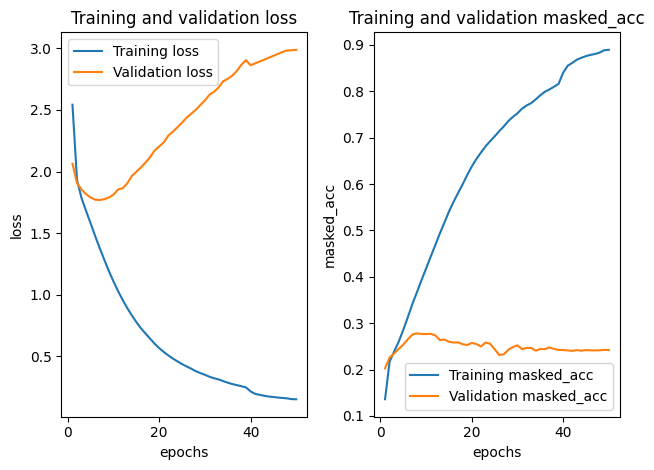

best_epoch is 8
Epoch 1/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 76s 460ms/step - loss: 2.9789 - masked_acc: 0.1039 - learning_rate: 5.0000e-04
Epoch 2/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 420ms/step - loss: 1.9591 - masked_acc: 0.2124 - learning_rate: 5.0000e-04
Epoch 3/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 421ms/step - loss: 1.7975 - masked_acc: 0.2353 - learning_rate: 5.0000e-04
Epoch 4/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 424ms/step - loss: 1.6900 - masked_acc: 0.2574 - learning_rate: 5.0000e-04
Epoch 5/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 404ms/step - loss: 1.5846 - masked_acc: 0.2841 - learning_rate: 5.0000e-04
Epoch 6/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 406ms/step - loss: 1.4792 - masked_acc: 0.3114 - learning_rate: 5.0000e-04
Epoch 7/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 405ms/step - loss: 1.3779 - masked_acc: 0.3388 - learning_rate: 5.0000e-04
Epoch 8/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 49s 401ms/step - loss: 1.2804 - masked_acc: 0.3662 - learning_rate: 5.0000e-04
Saving to model/summarization_model_2024

2024-08-21 15:13:24.758952: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3060452>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.23272714>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.24706672>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.081049286>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.06080737>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.06450046>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.2535345>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19598351>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.20626271>}


In [21]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred,
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [22]:
_, _, tds = build_datasets(
    train_ds=train_ds,
    validation_ds=validation_ds,
    test_ds=test_ds,
    vectorization_layer=vectorization_layer,
    batch_size=128,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
model.evaluate(tds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 461ms/step - loss: 1.6729 - masked_acc: 0.2792


[1.6775376796722412, 0.277573823928833]

In [23]:
start = time.time()
y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
print(time.time() - start)
y_true[:5], y_pred[:5]

598.705893278122


(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ['Amanda is looking for the park on the park. Hannah is not to do it. Amanda is not to the park.',
  'Eric is looking for eric, eric, eric, rob, rob, rob, rob, rob and rob will watch the best friend.',
  'Bob will pick up the new dress up with his first day.',
  'Emma will pick up for dinner tonight. Emma will pick up her up. Emma will pick up her up.',
  'Jane is in warsaw for a party. Jane and jane will c

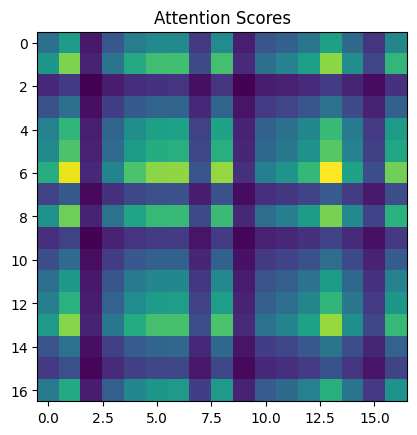

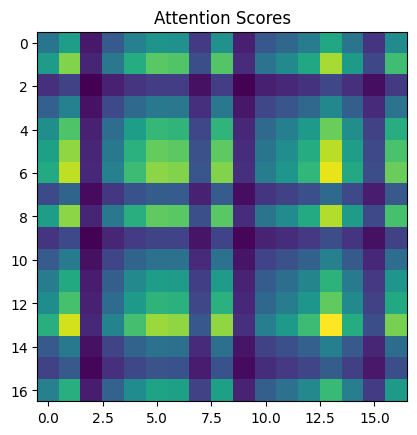

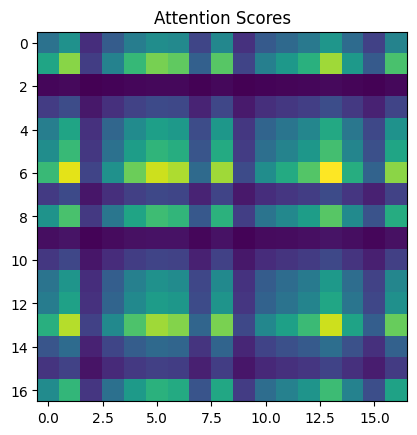

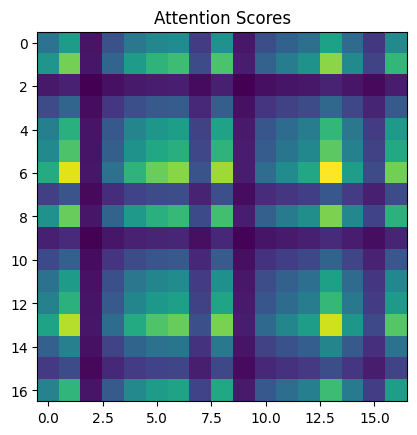

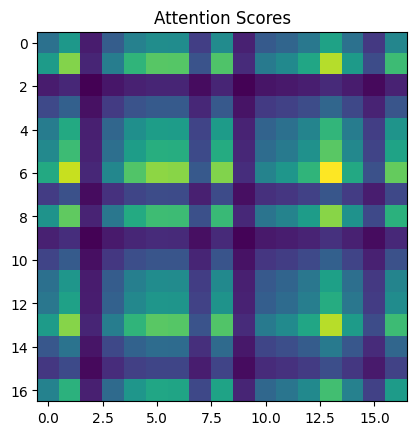

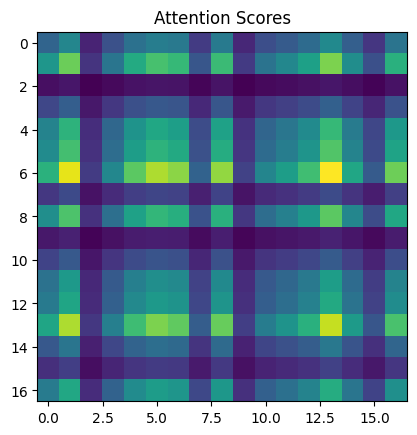

In [189]:
import matplotlib.pyplot as plt
from keras_nlp.src.backend import ops

def visualize_attention_scores(
        encoder_tokenizer,
        encoder_embedding,
        attention_layer,
        sentence):
    """
    This method visuzlize MultiHeadAttention of TransformerEncoder in keras_nlp.
    attention_scores cannot be accessed in this library.
    Therefore, the calculation code is ported. (keras_nlp.layers.modeling.CachedMultiHeadAttention)
    :encoder_tokenizer: the tokenizer that was used in encoder
    :encoder_embedding: the embedding layer that was used in encoder
    :attention_layer: the reference of attention layer, which is ususally CachedMultiHeadAttention
    :sentence: the sentence that is analyzed
    """
    sentence = custom_standardization(sentence)
    tokenized_sentence = encoder_tokenizer([sentence])
    max_len = tf.RaggedTensor.from_tensor(tokenized_sentence, padding=0)[0].shape[0]

    output = encoder_embedding(tokenized_sentence)
    k = attention_layer._key_dense(output)
    q = attention_layer._query_dense(output)
    q = ops.multiply(
        q,
        1.0 / ops.sqrt(ops.cast(attention_layer._key_dim, q.dtype)),
    )
    attention_scores = ops.einsum(
        attention_layer._dot_product_equation,
        k,
        q
    )
    attention_mask = None
    attention_scores = attention_layer._masked_softmax(
        attention_scores,
        attention_mask
    )

    # print(attention_scores.shape)
    # (1, 6, 128, 128)
    # batch_size, num_heads, sequence_length, sequence_length
    for i in range(attention_layer.num_heads):
        plt.imshow(attention_scores[0][i][:max_len, :max_len], cmap='viridis')
        plt.title('Attention Scores')
        plt.show()


# for i in tfds.as_numpy(test_ds):
#     dialogue = i['dialogue']
#     break
visualize_attention_scores(
    encoder_tokenizer=model.encoder_tokenizer,
    encoder_embedding=model.encoder_embedding,
    attention_layer=model.encoders[0]._self_attention_layer,
    sentence="[start] Eric: I have a car. Karen: I want to buy it. [end]",
)

In [92]:
model.decoders[0]._self_attention_layer.weights

[<KerasVariable shape=(128, 6, 21), dtype=float32, path=transformer_encoder_decoder_model_1/decoder_0/self_attention/query/kernel>,
 <KerasVariable shape=(6, 21), dtype=float32, path=transformer_encoder_decoder_model_1/decoder_0/self_attention/query/bias>,
 <KerasVariable shape=(128, 6, 21), dtype=float32, path=transformer_encoder_decoder_model_1/decoder_0/self_attention/key/kernel>,
 <KerasVariable shape=(6, 21), dtype=float32, path=transformer_encoder_decoder_model_1/decoder_0/self_attention/key/bias>,
 <KerasVariable shape=(128, 6, 21), dtype=float32, path=transformer_encoder_decoder_model_1/decoder_0/self_attention/value/kernel>,
 <KerasVariable shape=(6, 21), dtype=float32, path=transformer_encoder_decoder_model_1/decoder_0/self_attention/value/bias>,
 <KerasVariable shape=(6, 21, 128), dtype=float32, path=transformer_encoder_decoder_model_1/decoder_0/self_attention/attention_output/kernel>,
 <KerasVariable shape=(128,), dtype=float32, path=transformer_encoder_decoder_model_1/deco

***


```python
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace("'", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    """
    Define the custom standardization to remove useless characters.
    """
    #input_string = tf.strings.lower(input_string) # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'\s', ' ') # Replace \n, \r, \t, \f into space.
    #input_string = tf.strings.regex_replace(input_string, r"'", ' ') # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'<\/?[^>]*>', '') # html tag
    #input_string = tf.strings.regex_replace(input_string, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '') # html tag
    input_string = tf.strings.regex_replace(input_string, r'https?:\/\/.*[\r\n]*', " ") # URL
    # Some symbols are incorrectly used without space.
    input_string = tf.strings.regex_replace(input_string, r"([%s])" % re.escape(strip_chars), r" \1 ")
    input_string = tf.strings.regex_replace(input_string, r'\s\s+', ' ') # Finally, spaces to 1 space
    return input_string
```

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 99s 635ms/step - loss: 3.0493 - masked_acc: 0.1023 - val_loss: 2.0811 - val_masked_acc: 0.2033 - learning_rate: 5.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 65s 543ms/step - loss: 1.9900 - masked_acc: 0.2110 - val_loss: 1.9237 - val_masked_acc: 0.2246 - learning_rate: 5.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 66s 556ms/step - loss: 3.0092 - masked_acc: 0.1077 - val_loss: 3.8514 - val_masked_acc: 0.1098 - learning_rate: 5.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 64s 544ms/step - loss: 3.3931 - masked_acc: 0.0883 - val_loss: 3.0929 - val_masked_acc: 0.0882 - learning_rate: 5.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 66s 558ms/step - loss: 2.9917 - masked_acc: 0.0955 - val_loss: 3.0320 - val_masked_acc: 0.1520 - learning_rate: 5.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 2.7693 - masked_acc: 0.1288
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
116/116 ━━━━━━━━━━

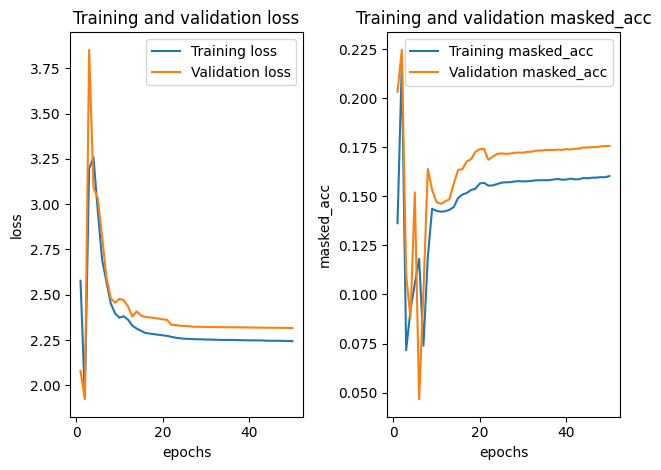

best_epoch is 2
Epoch 1/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 108s 589ms/step - loss: 3.0759 - masked_acc: 0.0979 - learning_rate: 5.0000e-04
Epoch 2/2
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 490ms/step - loss: 2.6931 - masked_acc: 0.1169 - learning_rate: 5.0000e-04
Saving to model/summarization_model_2024-08-20_18-08-17.keras
Successfully saved model to model/summarization_model_2024-08-20_18-08-17.keras
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.004884005>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.00011509693>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.00022475052>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.004884005>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.00011509693>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.00022475052>}


In [24]:
LEARNING_RATE = 0.0005
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred,
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [25]:
y_true[:5], y_pred[:5]

(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ['[ end ]', '[ end ]', '[ end ]', '[ end ]', '[ end ]'])

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 97s 641ms/step - loss: 3.0165 - masked_acc: 0.1061 - val_loss: 2.0816 - val_masked_acc: 0.2054 - learning_rate: 5.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 66s 554ms/step - loss: 1.9899 - masked_acc: 0.2114 - val_loss: 1.9206 - val_masked_acc: 0.2244 - learning_rate: 5.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 64s 544ms/step - loss: 1.8162 - masked_acc: 0.2350 - val_loss: 1.8718 - val_masked_acc: 0.2329 - learning_rate: 5.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 64s 544ms/step - loss: 1.7041 - masked_acc: 0.2580 - val_loss: 1.8289 - val_masked_acc: 0.2441 - learning_rate: 5.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 64s 541ms/step - loss: 1.5912 - masked_acc: 0.2855 - val_loss: 1.8103 - val_masked_acc: 0.2479 - learning_rate: 5.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 64s 547ms/step - loss: 1.4755 - masked_acc: 0.3180 - val_loss: 1.7929 - val_masked_acc: 0.2593 - learning_rate: 5.0000e-04
Epoch 7/50
116/116 ━━━

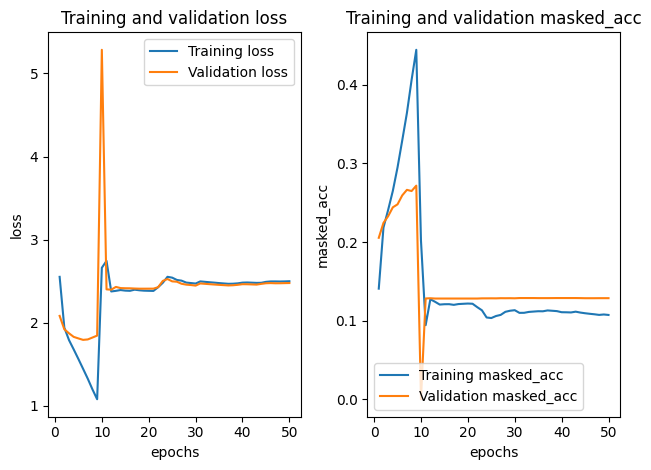

best_epoch is 9
Epoch 1/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 106s 671ms/step - loss: 3.0492 - masked_acc: 0.1026 - learning_rate: 5.0000e-04
Epoch 2/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 73s 584ms/step - loss: 2.8032 - masked_acc: 0.1080 - learning_rate: 5.0000e-04
Epoch 3/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 580ms/step - loss: 2.8675 - masked_acc: 0.0773 - learning_rate: 5.0000e-04
Epoch 4/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 72s 582ms/step - loss: 3.2029 - masked_acc: 0.0587 - learning_rate: 5.0000e-04
Epoch 5/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - loss: 3.1573 - masked_acc: 0.0426
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
122/122 ━━━━━━━━━━━━━━━━━━━━ 71s 573ms/step - loss: 3.1541 - masked_acc: 0.0429 - learning_rate: 5.0000e-04
Epoch 6/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 565ms/step - loss: 2.4604 - masked_acc: 0.1109 - learning_rate: 1.0000e-04
Epoch 7/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 70s 569ms/step - loss: 2.5653 - masked_acc: 0.1122 - learning_rate: 1.0000e-04
E

2024-08-20 17:15:27.889253: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}


In [22]:
LEARNING_RATE = 0.0005
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=8,
    dropout=0.1,
    transformer_intermediate_dim=1024,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=8,
    dropout=0.1,
    transformer_intermediate_dim=1024,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred,
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [23]:
y_true[:5], y_pred[:5]

(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ['.', '.', '.', '.', '.'])

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 116s 736ms/step - loss: 2.9996 - masked_acc: 0.1155 - val_loss: 2.0692 - val_masked_acc: 0.2040 - learning_rate: 5.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 70s 584ms/step - loss: 1.9814 - masked_acc: 0.2121 - val_loss: 1.9202 - val_masked_acc: 0.2270 - learning_rate: 5.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 69s 585ms/step - loss: 1.8143 - masked_acc: 0.2361 - val_loss: 1.8705 - val_masked_acc: 0.2328 - learning_rate: 5.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 69s 583ms/step - loss: 1.7056 - masked_acc: 0.2585 - val_loss: 1.8308 - val_masked_acc: 0.2428 - learning_rate: 5.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 70s 589ms/step - loss: 1.5957 - masked_acc: 0.2850 - val_loss: 1.8026 - val_masked_acc: 0.2571 - learning_rate: 5.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 72s 605ms/step - loss: 2.4575 - masked_acc: 0.2018 - val_loss: 2.8719 - val_masked_acc: 0.1059 - learning_rate: 5.0000e-04
Epoch 7/50
116/116 ━━

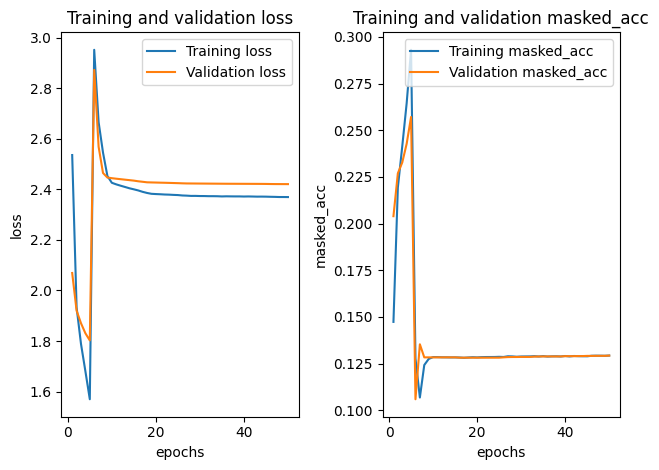

best_epoch is 5
Epoch 1/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1439s 12s/step - loss: 2.9866 - masked_acc: 0.1132 - learning_rate: 5.0000e-04
Epoch 2/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 1914s 16s/step - loss: 2.1769 - masked_acc: 0.1933 - learning_rate: 5.0000e-04
Epoch 3/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 74s 604ms/step - loss: 3.1974 - masked_acc: 0.0619 - learning_rate: 5.0000e-04
Epoch 4/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 74s 607ms/step - loss: 3.2188 - masked_acc: 0.0982 - learning_rate: 5.0000e-04
Epoch 5/5
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - loss: 2.7862 - masked_acc: 0.1226
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
122/122 ━━━━━━━━━━━━━━━━━━━━ 73s 596ms/step - loss: 2.7854 - masked_acc: 0.1226 - learning_rate: 5.0000e-04
Saving to model/summarization_model_2024-08-20_19-10-24.keras
Successfully saved model to model/summarization_model_2024-08-20_19-10-24.keras


2024-08-20 20:11:28.939865: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}


In [26]:
LEARNING_RATE = 0.0005
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=8,
    dropout=0.1,
    transformer_intermediate_dim=2048,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=8,
    dropout=0.1,
    transformer_intermediate_dim=2048,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred,
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [27]:
y_true[:5], y_pred[:5]

(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ['.', '.', '.', '.', '.'])

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - loss: 2.7542 - masked_acc: 0.1209 - val_loss: 1.9721 - val_masked_acc: 0.2186 - learning_rate: 5.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 108s 914ms/step - loss: 1.8838 - masked_acc: 0.2250 - val_loss: 1.8815 - val_masked_acc: 0.2310 - learning_rate: 5.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 104s 899ms/step - loss: 1.7263 - masked_acc: 0.2486 - val_loss: 1.8387 - val_masked_acc: 0.2448 - learning_rate: 5.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 106s 914ms/step - loss: 1.6145 - masked_acc: 0.2753 - val_loss: 2.5335 - val_masked_acc: 0.0865 - learning_rate: 5.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 106s 912ms/step - loss: 2.4600 - masked_acc: 0.0918 - val_loss: 2.4881 - val_masked_acc: 0.1282 - learning_rate: 5.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 109s 937ms/step - loss: 2.4625 - masked_acc: 0.0971 - val_loss: 2.4625 - val_masked_acc: 0.0865 - learning_rate: 5.0000e-04
Epoch 7/50
116/116 

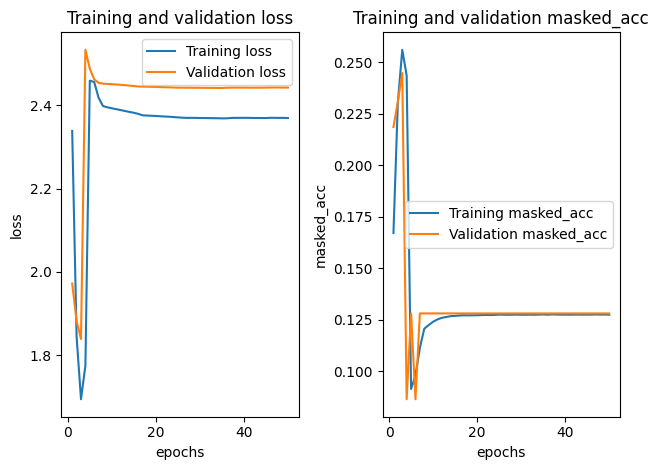

best_epoch is 3
Epoch 1/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - loss: 2.7182 - masked_acc: 0.1252 - learning_rate: 5.0000e-04
Epoch 2/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 110s 891ms/step - loss: 2.5617 - masked_acc: 0.1151 - learning_rate: 5.0000e-04
Epoch 3/3
122/122 ━━━━━━━━━━━━━━━━━━━━ 111s 905ms/step - loss: 2.0552 - masked_acc: 0.1969 - learning_rate: 5.0000e-04
Saving to model/summarization_model_2024-08-20_21-40-15.keras
Successfully saved model to model/summarization_model_2024-08-20_21-40-15.keras
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>, 

In [28]:
LEARNING_RATE = 0.0005
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=4,
    num_decoders=4,
    num_heads=12,
    dropout=0.1,
    transformer_intermediate_dim=2048,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=4,
    num_decoders=4,
    num_heads=12,
    dropout=0.1,
    transformer_intermediate_dim=2048,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred,
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [29]:
y_true[:5], y_pred[:5]

(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ['................................................................',
  '................................................................',
  '................................................................',
  '................................................................',
  '................................................................'])

In [34]:
trds, vds, tds = build_datasets(
    train_ds=train_ds,
    validation_ds=validation_ds,
    test_ds=test_ds,
    vectorization_layer=vectorization_layer,
    batch_size=128,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
model.evaluate(trds)

116/116 ━━━━━━━━━━━━━━━━━━━━ 42s 352ms/step - loss: 2.3732 - masked_acc: 0.0860


[2.363452911376953, 0.08623398840427399]

***

```python
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace("'", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    """
    Define the custom standardization to remove useless characters.
    """
    input_string = tf.strings.lower(input_string) # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'\s', ' ') # Replace \n, \r, \t, \f into space.
    #input_string = tf.strings.regex_replace(input_string, r"'", ' ') # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'<\/?[^>]*>', '') # html tag
    #input_string = tf.strings.regex_replace(input_string, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '') # html tag
    input_string = tf.strings.regex_replace(input_string, r'https?:\/\/.*[\r\n]*', " ") # URL
    # Some symbols are incorrectly used without space.
    input_string = tf.strings.regex_replace(input_string, r"([%s])" % re.escape(strip_chars), r" \1 ")
    input_string = tf.strings.regex_replace(input_string, r'\s\s+', ' ') # Finally, spaces to 1 space
    return input_string
```

Epoch 1/50


2024-08-20 12:49:23.682275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 71s 453ms/step - loss: 2.9932 - masked_acc: 0.0980 - val_loss: 2.0618 - val_masked_acc: 0.2028 - learning_rate: 5.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 410ms/step - loss: 1.9780 - masked_acc: 0.2102 - val_loss: 1.9111 - val_masked_acc: 0.2246 - learning_rate: 5.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 412ms/step - loss: 1.8099 - masked_acc: 0.2339 - val_loss: 1.8572 - val_masked_acc: 0.2347 - learning_rate: 5.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 48s 411ms/step - loss: 1.7057 - masked_acc: 0.2527 - val_loss: 1.8222 - val_masked_acc: 0.2398 - learning_rate: 5.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 614s 5s/step - loss: 1.6074 - masked_acc: 0.2757 - val_loss: 1.8025 - val_masked_acc: 0.2479 - learning_rate: 5.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 437ms/step - loss: 1.5071 - masked_acc: 0.3033 - val_loss: 1.7791 - val_masked_acc: 0.2604 - learning_rate: 5.0000e-04
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━

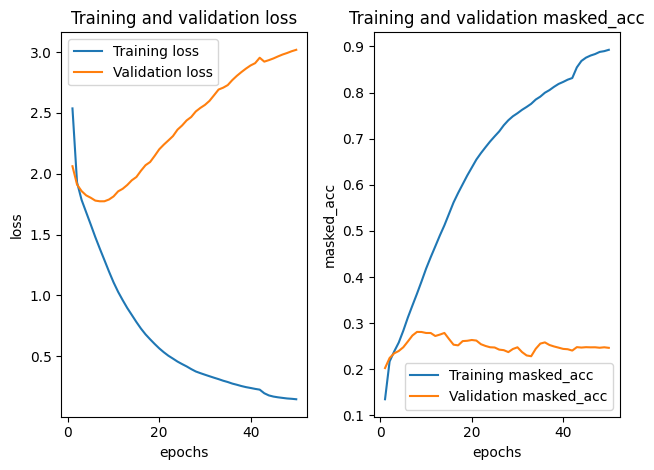

best_epoch is 8
Epoch 1/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 83s 498ms/step - loss: 2.9719 - masked_acc: 0.1054 - learning_rate: 5.0000e-04
Epoch 2/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - loss: 1.9620 - masked_acc: 0.2120 - learning_rate: 5.0000e-04
Epoch 3/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 445ms/step - loss: 1.7978 - masked_acc: 0.2355 - learning_rate: 5.0000e-04
Epoch 4/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 420ms/step - loss: 1.6906 - masked_acc: 0.2576 - learning_rate: 5.0000e-04
Epoch 5/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 432ms/step - loss: 1.5869 - masked_acc: 0.2832 - learning_rate: 5.0000e-04
Epoch 6/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 51s 415ms/step - loss: 1.4819 - masked_acc: 0.3113 - learning_rate: 5.0000e-04
Epoch 7/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 52s 417ms/step - loss: 1.3811 - masked_acc: 0.3392 - learning_rate: 5.0000e-04
Epoch 8/8
122/122 ━━━━━━━━━━━━━━━━━━━━ 51s 420ms/step - loss: 1.2840 - masked_acc: 0.3654 - learning_rate: 5.0000e-04
Saving to model/summarization_model_2024

2024-08-20 13:59:31.194439: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.30838585>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.23994407>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.25206193>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07982047>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.061928097>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.064830974>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.25626537>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.201826>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2109533>}


In [21]:
LEARNING_RATE = 0.0005
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred,
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [22]:
y_true[:5], y_pred[:5]

(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ['Amanda is looking for the meeting with amanda. Amanda is worried about it.',
  'Eric has been to watch a train tickets to `` and eric was a lot of ``. Eric will watch a lot of the train.',
  'Bob will pick up his photos of the photos of the photos of the first time with his friends.',
  'Emma will pick up tonight. Emma will pick up tonight. Emma will pick up and emma will pick up tonight.',
  'Jane is goi

***

```python
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace(".", "")
strip_chars = strip_chars.replace(",", "")
strip_chars = strip_chars.replace(":", "") # This is used to identify speakers.

@saving.register_keras_serializable()
def custom_standardization(input_string):
    """
    Define the custom standardization to remove useless characters.
    """
    input_string = tf.strings.lower(input_string) # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'\.', ' .') # This should be treated as a token.
    input_string = tf.strings.regex_replace(input_string, r',', ' ,') # This should be treated as a token.
    input_string = tf.strings.regex_replace(input_string, r':', ' :') # This should be treated as a token.
    input_string = tf.strings.regex_replace(input_string, r'\s', ' ') # Replace \n, \r, \t, \f into space.
    #input_string = tf.strings.regex_replace(input_string, r"'", ' ') # This should not be used to generation tasks
    input_string = tf.strings.regex_replace(input_string, r'<\/?[^>]*>', '') # html tag
    #input_string = tf.strings.regex_replace(input_string, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '') # html tag
    input_string = tf.strings.regex_replace(input_string, r'https?:\/\/.*[\r\n]*', " ") # URL
    input_string = tf.strings.regex_replace(input_string, r'\s\s+', ' ') # spaces to 1 space
    input_string = tf.strings.regex_replace(input_string, "[%s]" % re.escape(strip_chars), "")
    return input_string
```

Epoch 1/50


2024-08-20 02:55:17.510209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 74s 476ms/step - loss: 2.9681 - masked_acc: 0.0993 - val_loss: 2.0465 - val_masked_acc: 0.2059 - learning_rate: 5.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 429ms/step - loss: 1.9580 - masked_acc: 0.2122 - val_loss: 1.8950 - val_masked_acc: 0.2251 - learning_rate: 5.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 427ms/step - loss: 1.7926 - masked_acc: 0.2344 - val_loss: 1.8453 - val_masked_acc: 0.2347 - learning_rate: 5.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 429ms/step - loss: 1.6928 - masked_acc: 0.2529 - val_loss: 1.8101 - val_masked_acc: 0.2418 - learning_rate: 5.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 435ms/step - loss: 1.5954 - masked_acc: 0.2757 - val_loss: 1.7781 - val_masked_acc: 0.2545 - learning_rate: 5.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 423ms/step - loss: 1.4938 - masked_acc: 0.3036 - val_loss: 1.7585 - val_masked_acc: 0.2677 - learning_rate: 5.0000e-04
Epoch 7/50
116/116 ━━━━━━━━━━━━━━

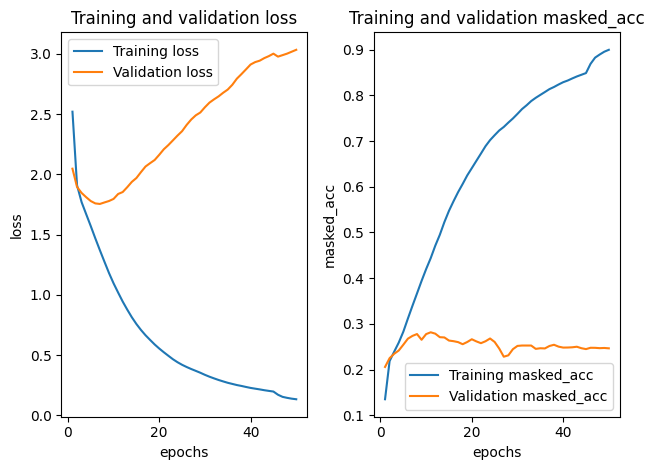

best_epoch is 11
Epoch 1/11
122/122 ━━━━━━━━━━━━━━━━━━━━ 75s 452ms/step - loss: 2.9474 - masked_acc: 0.0983 - learning_rate: 5.0000e-04
Epoch 2/11
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - loss: 1.9409 - masked_acc: 0.2136 - learning_rate: 5.0000e-04
Epoch 3/11
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 409ms/step - loss: 1.7829 - masked_acc: 0.2365 - learning_rate: 5.0000e-04
Epoch 4/11
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 408ms/step - loss: 1.6808 - masked_acc: 0.2555 - learning_rate: 5.0000e-04
Epoch 5/11
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 408ms/step - loss: 1.5815 - masked_acc: 0.2804 - learning_rate: 5.0000e-04
Epoch 6/11
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 410ms/step - loss: 1.4795 - masked_acc: 0.3093 - learning_rate: 5.0000e-04
Epoch 7/11
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 407ms/step - loss: 1.3772 - masked_acc: 0.3375 - learning_rate: 5.0000e-04
Epoch 8/11
122/122 ━━━━━━━━━━━━━━━━━━━━ 50s 412ms/step - loss: 1.2786 - masked_acc: 0.3643 - learning_rate: 5.0000e-04
Epoch 9/11
122/122 ━━━━━━━━━━━━

2024-08-20 03:59:10.296181: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.273793>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.27931386>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2577424>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07048972>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.07401875>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0668762>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.22482768>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2331176>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.21320349>}


In [ ]:
LEARNING_RATE = 0.0005
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_post_processing=True,
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred,
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [21]:
y_true[:5], y_pred[:5]

(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ['Amanda is looking for a park. Hannah is worried about her. Hannah is not sure if she doesnt have a call her. Hannah is angry at her.',
  'Eric and eric have a new jacket. He will watch a problem with a problem with a better than a new machine. He will watch it soon.',
  'Lenny will pick up a photo of a photo of her outfit for a photo of them.',
  'Emma will be home tonight. Emma will pick her up tonight. 

***

```python
# @see https://github.com/keras-team/keras-nlp/blob/50e041487b1d8b30b34c5fb738db3ed3406363bc/examples/machine_translation/data.py
import string
import re

strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")
strip_chars = strip_chars.replace(".", "")
strip_chars = strip_chars.replace(",", "")

@saving.register_keras_serializable()
def custom_standardization(input_string):
    """
    Define the custom standardization to remove useless characters.
    """
    input_string = tf.strings.regex_replace(input_string, r'\s', ' ') # space, \n, \r, \t, \f
    input_string = tf.strings.regex_replace(input_string, r'<br />', ' ')
    input_string = tf.strings.regex_replace(input_string, r'<\/?[^>]*>', '') # html tag
    #s = tf.strings.regex_replace(s, r'''<("[^"]*"|'[^']*'|[^'">])*>''', '') # html tag
    input_string = tf.strings.regex_replace(input_string, r'https?:\/\/.*[\r\n]*', " ") # URL
    input_string = tf.strings.regex_replace(input_string, r'\s\s+', ' ') # spaces to 1 space
    input_string = tf.strings.regex_replace(input_string, "[%s]" % re.escape(strip_chars), "")
    return input_string
```

Epoch 1/50


2024-08-19 21:48:17.204307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 83s 562ms/step - loss: 2.7864 - masked_acc: 0.0415 - val_loss: 2.0627 - val_masked_acc: 0.1269 - learning_rate: 5.0000e-04
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 63s 527ms/step - loss: 1.9622 - masked_acc: 0.1435 - val_loss: 1.8872 - val_masked_acc: 0.1631 - learning_rate: 5.0000e-04
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 62s 532ms/step - loss: 1.9752 - masked_acc: 0.1500 - val_loss: 2.0260 - val_masked_acc: 0.1452 - learning_rate: 5.0000e-04
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 62s 530ms/step - loss: 1.9292 - masked_acc: 0.1497 - val_loss: 1.9263 - val_masked_acc: 0.1578 - learning_rate: 5.0000e-04
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 61s 522ms/step - loss: 1.7871 - masked_acc: 0.1731 - val_loss: 1.9010 - val_masked_acc: 0.1634 - learning_rate: 5.0000e-04
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 61s 522ms/step - loss: 1.7215 - masked_acc: 0.1828 - val_loss: 1.8945 - val_masked_acc: 0.1654 - learning_rate: 5.0000e-04
Epoch 7/50
116/116 ━━━━━━━━━━━━━━

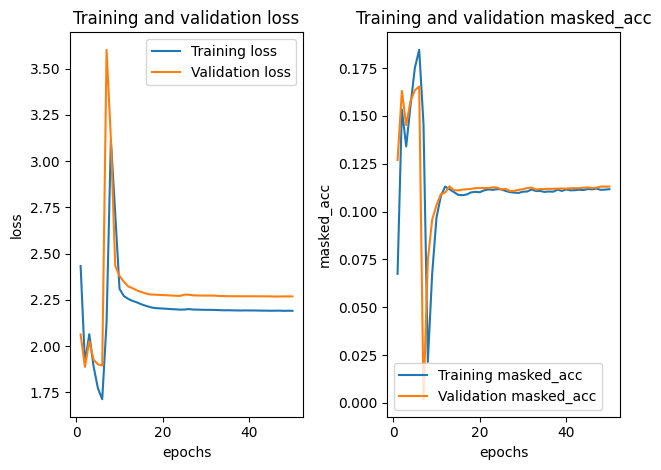

best_epoch is 6
Epoch 1/6
122/122 ━━━━━━━━━━━━━━━━━━━━ 95s 598ms/step - loss: 2.7678 - masked_acc: 0.0467 - learning_rate: 5.0000e-04
Epoch 2/6
122/122 ━━━━━━━━━━━━━━━━━━━━ 65s 533ms/step - loss: 1.9350 - masked_acc: 0.1496 - learning_rate: 5.0000e-04
Epoch 3/6
122/122 ━━━━━━━━━━━━━━━━━━━━ 66s 529ms/step - loss: 1.7656 - masked_acc: 0.1775 - learning_rate: 5.0000e-04
Epoch 4/6
122/122 ━━━━━━━━━━━━━━━━━━━━ 62s 510ms/step - loss: 1.6557 - masked_acc: 0.2014 - learning_rate: 5.0000e-04
Epoch 5/6
122/122 ━━━━━━━━━━━━━━━━━━━━ 63s 511ms/step - loss: 1.5454 - masked_acc: 0.2338 - learning_rate: 5.0000e-04
Epoch 6/6
122/122 ━━━━━━━━━━━━━━━━━━━━ 66s 540ms/step - loss: 1.4298 - masked_acc: 0.2699 - learning_rate: 5.0000e-04
Saving to model/summarization_model_2024-08-19_22-40-03.keras
Successfully saved model to model/summarization_model_2024-08-19_22-40-03.keras


2024-08-19 22:57:59.632841: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.25309104>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.22238971>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.22091852>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.05582716>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.049464002>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.048533462>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.21017525>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18866317>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18535453>}


In [19]:
LEARNING_RATE = 0.0005
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [20]:
y_true[:5], y_pred[:5]

(["Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.",
  'Eric and Rob are going to watch a stand-up on youtube.',
  "Lenny can't decide which trousers to buy. Bob advised Lenny on that topic. Lenny goes with Bob's advice to pick the trousers that are of best quality.",
  'Emma will be home soon and she will let Will know.',
  "Jane is in Warsaw. Ollie and Jane has a party. Jane lost her calendar. They will get a lunch this week on Friday. Ollie accidentally called Jane and talked about whisky. Jane cancels lunch. They'll meet for a tea at 6 pm."],
 ['Hannah is at the last night and Hannah is going to the last night with her',
  'Eric is looking for a conference on a lot of the train station and wants to watch it to watch the train station',
  'Bob will pick a photo of the new one of the new one of the first time with a new one of the first time',
  'Emma will pick up at home tonight Emma will pick her up with Emma and Emma will pick up at home',
  'Ja

***

### Note (Experiment Date: 2024-08-14 18:16:00~)

Verify that the performance does not improve if the `ReduceLROnPlateau` monitors the validation loss.

#### Result

The shape of training curve and validation curve has changed. However, the performance did not improve expectedly.

Epoch 1/50


2024-08-14 23:06:08.803362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 76s 491ms/step - loss: 2.5740 - masked_acc: 0.0674 - val_loss: 1.8946 - val_masked_acc: 0.1598 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 54s 451ms/step - loss: 1.8158 - masked_acc: 0.1713 - val_loss: 1.8291 - val_masked_acc: 0.1726 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 458ms/step - loss: 1.6693 - masked_acc: 0.1969 - val_loss: 1.8091 - val_masked_acc: 0.1792 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 442ms/step - loss: 1.5385 - masked_acc: 0.2260 - val_loss: 1.7568 - val_masked_acc: 0.2103 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 443ms/step - loss: 1.3906 - masked_acc: 0.2699 - val_loss: 1.7295 - val_masked_acc: 0.2322 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - loss: 1.2492 - masked_acc: 0.3080
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 441ms/step - los

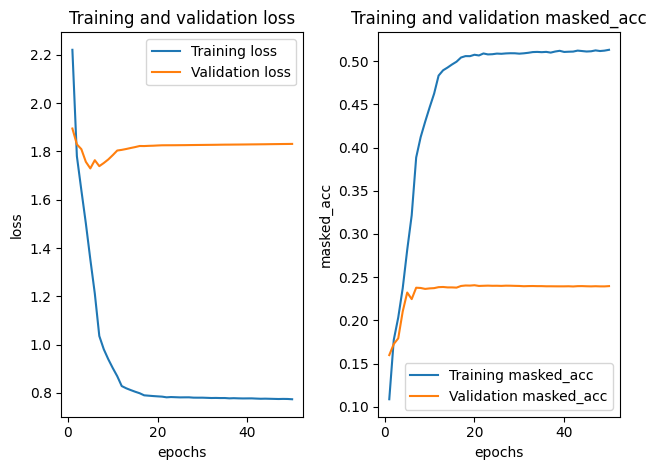

best_epoch is 20
Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - loss: 2.5507 - masked_acc: 0.0708

/Users/mitsuaki.ishimoto/.pyenv/versions/3.10.11/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,masked_acc,learning_rate.
  callback.on_epoch_end(epoch, logs)


122/122 ━━━━━━━━━━━━━━━━━━━━ 83s 501ms/step - loss: 2.5478 - masked_acc: 0.0711 - learning_rate: 0.0010
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 466ms/step - loss: 1.8058 - masked_acc: 0.1731 - learning_rate: 0.0010
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 61s 484ms/step - loss: 1.6540 - masked_acc: 0.2024 - learning_rate: 0.0010
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 1.5048 - masked_acc: 0.2419 - learning_rate: 0.0010
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 477ms/step - loss: 1.3440 - masked_acc: 0.2870 - learning_rate: 0.0010
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 471ms/step - loss: 1.1968 - masked_acc: 0.3280 - learning_rate: 0.0010
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 452ms/step - loss: 1.0645 - masked_acc: 0.3698 - learning_rate: 0.0010
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 435ms/step - loss: 0.9511 - masked_acc: 0.4119 - learning_rate: 0.0010
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - loss: 0.8571 - masked_acc: 0.4511 

2024-08-15 00:19:36.654824: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3006005>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.27616638>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2671669>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07519602>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.06671659>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.06577745>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.24363813>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2263549>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.21742196>}


In [ ]:
# @see https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr_callbacks = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    min_delta=0.04,
    cooldown=4,
    min_lr=2e-6, # 5e-4: 0.0005, 2e-5: 0.00002, 2e-6: 0.000002
)

LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=2,
    num_decoders=2,
    num_heads=6,
    dropout=0.35,
    transformer_intermediate_dim=512,
    normalize_first=False,
    layer_norm_epsilon=1e-5,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=True,
    vocab_size=VOCABULARY_SIZE,
    batch_size=128,
    embedding_dim=128,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

### Note (Experiment Date: 2024-08-13 11:49:00~)

When the normalization layer is put at the end of the encoder/decoder, the performance gets better. However, the epsilon values are not tested for the normalize first model. Therefore, those cases are tested here.

#### Result

Normalization | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
1e-6 | **1.823** | **0.221** | **23.9** | **5.4** | **19.7**
1e-5 | 1.835 | 0.217 | 22.6 | 4.5 | 18.5
1e-4 | 1.827 | 0.216 | 22.7 | 5.0 | 19.2
1e-3 | 1.846 | 0.215 | 22.9 | 4.9 | 18.9

It is found that the pre layer normalized model is not better regardless of the epsilon values.

Epoch 1/50


2024-08-13 11:50:02.078787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 74s 469ms/step - loss: 2.5154 - masked_acc: 0.0552 - val_loss: 1.9982 - val_masked_acc: 0.1339 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 435ms/step - loss: 1.9648 - masked_acc: 0.1375 - val_loss: 1.9122 - val_masked_acc: 0.1581 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 432ms/step - loss: 1.8383 - masked_acc: 0.1620 - val_loss: 1.8862 - val_masked_acc: 0.1678 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 431ms/step - loss: 1.7575 - masked_acc: 0.1776 - val_loss: 1.8827 - val_masked_acc: 0.1713 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 50s 435ms/step - loss: 1.6905 - masked_acc: 0.1893 - val_loss: 1.8809 - val_masked_acc: 0.1789 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 51s 436ms/step - loss: 1.6267 - masked_acc: 0.2013 - val_loss: 1.8501 - val_masked_acc: 0.1909 - learning_rate: 0.0010
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 49s 418ms/step - 

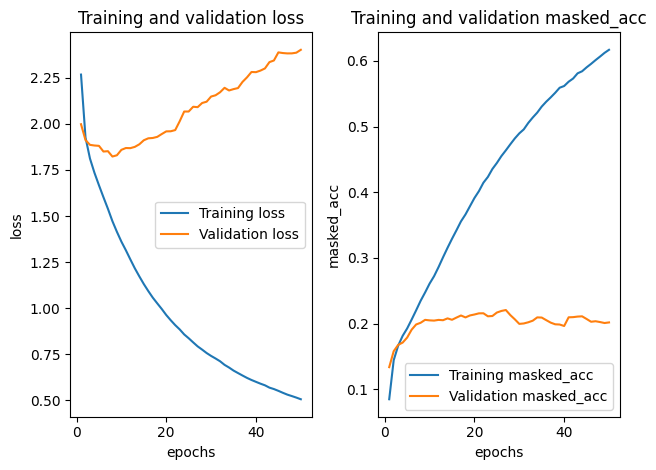

best_epoch is 27
Epoch 1/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 80s 476ms/step - loss: 2.4975 - masked_acc: 0.0558 - learning_rate: 0.0010
Epoch 2/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 439ms/step - loss: 1.9593 - masked_acc: 0.1378 - learning_rate: 0.0010
Epoch 3/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 446ms/step - loss: 1.8306 - masked_acc: 0.1620 - learning_rate: 0.0010
Epoch 4/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - loss: 1.7449 - masked_acc: 0.1794 - learning_rate: 0.0010
Epoch 5/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 472ms/step - loss: 1.6693 - masked_acc: 0.1936 - learning_rate: 0.0010
Epoch 6/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - loss: 1.5972 - masked_acc: 0.2078 - learning_rate: 0.0010
Epoch 7/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - loss: 1.5287 - masked_acc: 0.2215 - learning_rate: 0.0010
Epoch 8/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 454ms/step - loss: 1.4626 - masked_acc: 0.2374 - learning_rate: 0.0010
Epoch 9/27
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 454ms/step - loss: 

2024-08-13 13:07:31.465837: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.2808883>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.23395172>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.23872577>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0658669>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.052300025>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.053989843>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.23163445>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19388497>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19720952>}
Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 91s 551ms/step - loss: 2.5064 - masked_acc: 0.0545 - val_loss: 2.0077 - val_masked_acc: 0.1331 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 55s 459ms/step - loss: 1.9662 - masked_acc: 0.1371 - val_loss: 1.9187 - val_masked_acc: 0.1568 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 53s 449ms/step - loss: 1.8376 

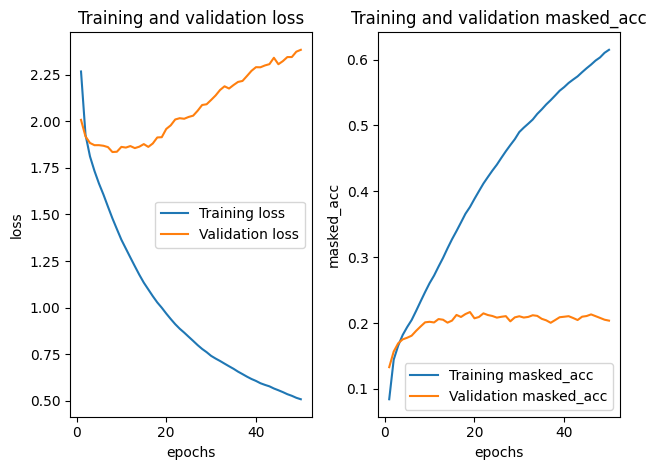

best_epoch is 19
Epoch 1/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 89s 513ms/step - loss: 2.4936 - masked_acc: 0.0559 - learning_rate: 0.0010
Epoch 2/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 448ms/step - loss: 1.9477 - masked_acc: 0.1404 - learning_rate: 0.0010
Epoch 3/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 435ms/step - loss: 1.8213 - masked_acc: 0.1638 - learning_rate: 0.0010
Epoch 4/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 434ms/step - loss: 1.7371 - masked_acc: 0.1794 - learning_rate: 0.0010
Epoch 5/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 440ms/step - loss: 1.6634 - masked_acc: 0.1936 - learning_rate: 0.0010
Epoch 6/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 435ms/step - loss: 1.5952 - masked_acc: 0.2077 - learning_rate: 0.0010
Epoch 7/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 54s 434ms/step - loss: 1.5252 - masked_acc: 0.2205 - learning_rate: 0.0010
Epoch 8/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 438ms/step - loss: 1.4613 - masked_acc: 0.2347 - learning_rate: 0.0010
Epoch 9/19
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 450ms/step - loss: 

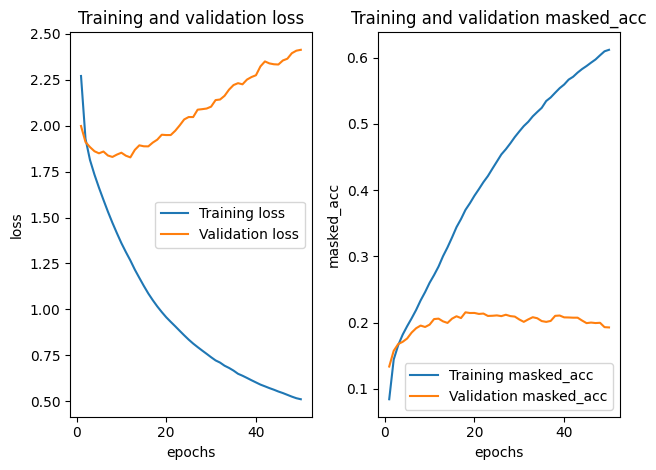

best_epoch is 18
Epoch 1/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 99s 566ms/step - loss: 2.4997 - masked_acc: 0.0550 - learning_rate: 0.0010
Epoch 2/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - loss: 1.9540 - masked_acc: 0.1395 - learning_rate: 0.0010
Epoch 3/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 468ms/step - loss: 1.8287 - masked_acc: 0.1626 - learning_rate: 0.0010
Epoch 4/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 443ms/step - loss: 1.7472 - masked_acc: 0.1796 - learning_rate: 0.0010
Epoch 5/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 439ms/step - loss: 1.6767 - masked_acc: 0.1926 - learning_rate: 0.0010
Epoch 6/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 443ms/step - loss: 1.6070 - masked_acc: 0.2055 - learning_rate: 0.0010
Epoch 7/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 439ms/step - loss: 1.5396 - masked_acc: 0.2201 - learning_rate: 0.0010
Epoch 8/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 60s 479ms/step - loss: 1.4718 - masked_acc: 0.2350 - learning_rate: 0.0010
Epoch 9/18
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 444ms/step - loss: 

2024-08-13 16:24:17.383873: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.28290612>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2138091>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.22731493>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.06468254>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.045570415>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.049744245>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.23682049>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.1811504>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.1915304>}
Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 94s 590ms/step - loss: 2.5120 - masked_acc: 0.0553 - val_loss: 1.9915 - val_masked_acc: 0.1341 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 56s 468ms/step - loss: 1.9646 - masked_acc: 0.1362 - val_loss: 1.9128 - val_masked_acc: 0.1593 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 55s 468ms/step - loss: 1.8460 -

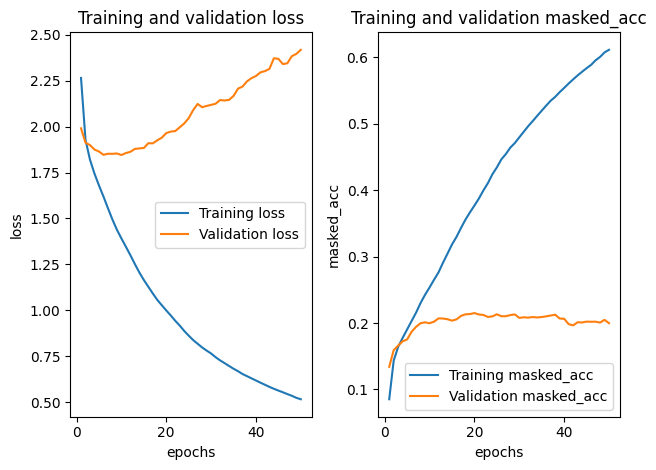

best_epoch is 20
Epoch 1/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 101s 564ms/step - loss: 2.5053 - masked_acc: 0.0532 - learning_rate: 0.0010
Epoch 2/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - loss: 1.9590 - masked_acc: 0.1386 - learning_rate: 0.0010
Epoch 3/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 447ms/step - loss: 1.8385 - masked_acc: 0.1615 - learning_rate: 0.0010
Epoch 4/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 55s 444ms/step - loss: 1.7580 - masked_acc: 0.1757 - learning_rate: 0.0010
Epoch 5/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - loss: 1.6891 - masked_acc: 0.1887 - learning_rate: 0.0010
Epoch 6/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - loss: 1.6208 - masked_acc: 0.2020 - learning_rate: 0.0010
Epoch 7/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 59s 472ms/step - loss: 1.5578 - masked_acc: 0.2140 - learning_rate: 0.0010
Epoch 8/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - loss: 1.4972 - masked_acc: 0.2287 - learning_rate: 0.0010
Epoch 9/20
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - loss:

In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

for layer_norm_epsilon in [1e-6, 1e-5, 1e-4, 1e-3]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=512,
        normalize_first=True,
        layer_norm_epsilon=layer_norm_epsilon,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=128,
        embedding_dim=128,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=512,
        normalize_first=True,
        layer_norm_epsilon=layer_norm_epsilon,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=128,
        embedding_dim=128,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-11 14:29:00~)

- Comparison of the batch size

#### Result

Normalization | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
16 | 1.822 | **0.242** | 25.2 | 5.7 | 20.9
32 | 1.771 | 0.240 | 26.3 | 6.7 | 21.6
64 | 1.745 | **0.242** | 26.4 | 6.6 | 21.8
128 | **1.729** | 0.240 | 26.7 | 6.9 | 21.6
256 | 1.739 | 0.235 | **27.1** | **7.0** | **22.0**

Epoch 1/50


2024-08-12 10:36:40.679815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


921/921 ━━━━━━━━━━━━━━━━━━━━ 143s 135ms/step - loss: 2.1775 - masked_acc: 0.1197 - val_loss: 1.8347 - val_masked_acc: 0.1735 - learning_rate: 0.0010
Epoch 2/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 120s 131ms/step - loss: 1.7070 - masked_acc: 0.1880 - val_loss: 1.8217 - val_masked_acc: 0.1857 - learning_rate: 0.0010
Epoch 3/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 118s 128ms/step - loss: 1.5311 - masked_acc: 0.2184 - val_loss: 1.8381 - val_masked_acc: 0.1934 - learning_rate: 0.0010
Epoch 4/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 116s 126ms/step - loss: 1.3796 - masked_acc: 0.2467 - val_loss: 1.8359 - val_masked_acc: 0.2103 - learning_rate: 0.0010
Epoch 5/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 116s 125ms/step - loss: 1.2403 - masked_acc: 0.2850 - val_loss: 1.8362 - val_masked_acc: 0.2233 - learning_rate: 0.0010
Epoch 6/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 115s 125ms/step - loss: 1.1140 - masked_acc: 0.3254 - val_loss: 1.8611 - val_masked_acc: 0.2340 - learning_rate: 0.0010
Epoch 7/50
921/921 ━━━━━━━━━━━━━━━━━━━━ 114s 124ms/

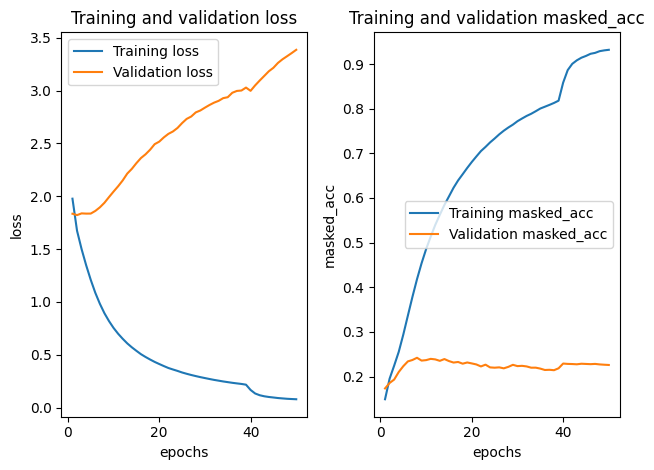

best_epoch is 8
Epoch 1/8
972/972 ━━━━━━━━━━━━━━━━━━━━ 157s 140ms/step - loss: 2.1725 - masked_acc: 0.1203 - learning_rate: 0.0010
Epoch 2/8
972/972 ━━━━━━━━━━━━━━━━━━━━ 133s 137ms/step - loss: 1.7054 - masked_acc: 0.1886 - learning_rate: 0.0010
Epoch 3/8
972/972 ━━━━━━━━━━━━━━━━━━━━ 138s 141ms/step - loss: 1.5353 - masked_acc: 0.2170 - learning_rate: 0.0010
Epoch 4/8
972/972 ━━━━━━━━━━━━━━━━━━━━ 135s 139ms/step - loss: 1.3969 - masked_acc: 0.2413 - learning_rate: 0.0010
Epoch 5/8
972/972 ━━━━━━━━━━━━━━━━━━━━ 133s 137ms/step - loss: 1.2823 - masked_acc: 0.2670 - learning_rate: 0.0010
Epoch 6/8
972/972 ━━━━━━━━━━━━━━━━━━━━ 134s 138ms/step - loss: 1.1774 - masked_acc: 0.2995 - learning_rate: 0.0010
Epoch 7/8
972/972 ━━━━━━━━━━━━━━━━━━━━ 135s 138ms/step - loss: 1.0799 - masked_acc: 0.3367 - learning_rate: 0.0010
Epoch 8/8
972/972 ━━━━━━━━━━━━━━━━━━━━ 136s 140ms/step - loss: 0.9880 - masked_acc: 0.3753 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-12_13-11-16.keras
Su

2024-08-12 13:39:27.764495: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.30254012>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.24139528>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.25198853>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.071377076>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.053310424>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.05697554>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.24977134>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2014242>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.20903505>}
Epoch 1/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 116s 197ms/step - loss: 2.2660 - masked_acc: 0.1072 - val_loss: 1.8404 - val_masked_acc: 0.1686 - learning_rate: 0.0010
Epoch 2/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 83s 179ms/step - loss: 1.7285 - masked_acc: 0.1856 - val_loss: 1.7951 - val_masked_acc: 0.1869 - learning_rate: 0.0010
Epoch 3/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 82s 177ms/step - loss: 1.542

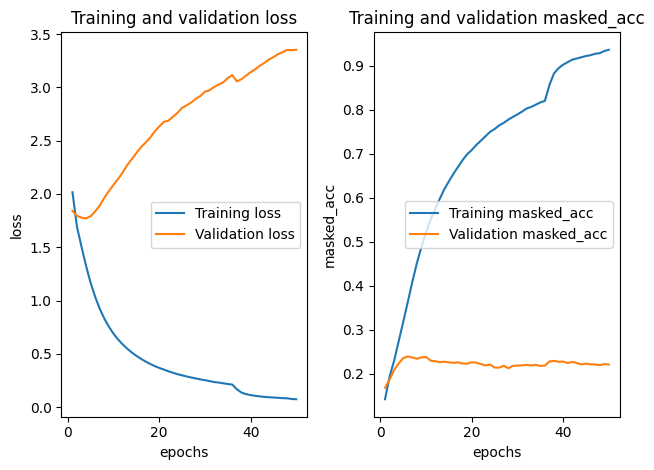

best_epoch is 6
Epoch 1/6
486/486 ━━━━━━━━━━━━━━━━━━━━ 115s 185ms/step - loss: 2.2510 - masked_acc: 0.1078 - learning_rate: 0.0010
Epoch 2/6
486/486 ━━━━━━━━━━━━━━━━━━━━ 83s 170ms/step - loss: 1.7231 - masked_acc: 0.1861 - learning_rate: 0.0010
Epoch 3/6
486/486 ━━━━━━━━━━━━━━━━━━━━ 83s 170ms/step - loss: 1.5307 - masked_acc: 0.2242 - learning_rate: 0.0010
Epoch 4/6
486/486 ━━━━━━━━━━━━━━━━━━━━ 80s 165ms/step - loss: 1.3416 - masked_acc: 0.2723 - learning_rate: 0.0010
Epoch 5/6
486/486 ━━━━━━━━━━━━━━━━━━━━ 80s 164ms/step - loss: 1.1787 - masked_acc: 0.3147 - learning_rate: 0.0010
Epoch 6/6
486/486 ━━━━━━━━━━━━━━━━━━━━ 83s 171ms/step - loss: 1.0431 - masked_acc: 0.3604 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-12_15-23-15.keras
Successfully saved model to model/summarization_model_2024-08-12_15-23-15.keras
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3332607>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.24119392>, 'f1_score': <tf.Tensor

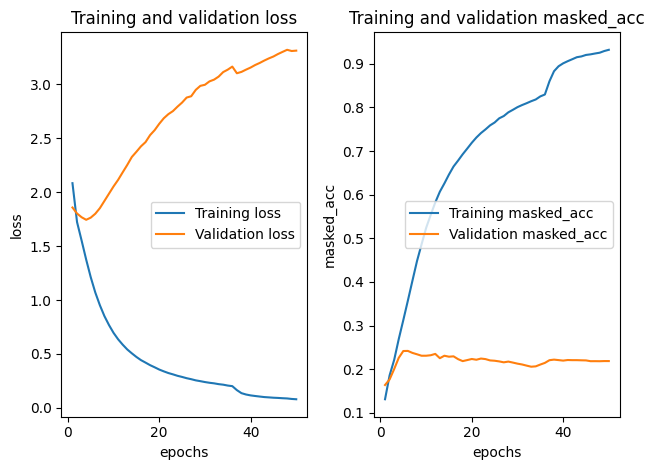

best_epoch is 6
Epoch 1/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 115s 331ms/step - loss: 2.3753 - masked_acc: 0.0925 - learning_rate: 0.0010
Epoch 2/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 71s 285ms/step - loss: 1.7538 - masked_acc: 0.1814 - learning_rate: 0.0010
Epoch 3/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 70s 283ms/step - loss: 1.5782 - masked_acc: 0.2174 - learning_rate: 0.0010
Epoch 4/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 68s 277ms/step - loss: 1.3970 - masked_acc: 0.2662 - learning_rate: 0.0010
Epoch 5/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 68s 274ms/step - loss: 1.2287 - masked_acc: 0.3084 - learning_rate: 0.0010
Epoch 6/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 67s 273ms/step - loss: 1.0841 - masked_acc: 0.3508 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-12_16-32-13.keras
Successfully saved model to model/summarization_model_2024-08-12_16-32-13.keras


2024-08-12 16:50:11.842774: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3163623>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.25323132>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.26380152>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.08065205>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.06261958>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.065759175>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.25986192>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.21066687>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.21779321>}
Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 115s 663ms/step - loss: 2.5689 - masked_acc: 0.0669 - val_loss: 1.8928 - val_masked_acc: 0.1603 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 57s 478ms/step - loss: 1.8153 - masked_acc: 0.1710 - val_loss: 1.8279 - val_masked_acc: 0.1713 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 56s 485ms/step - loss: 1.6693

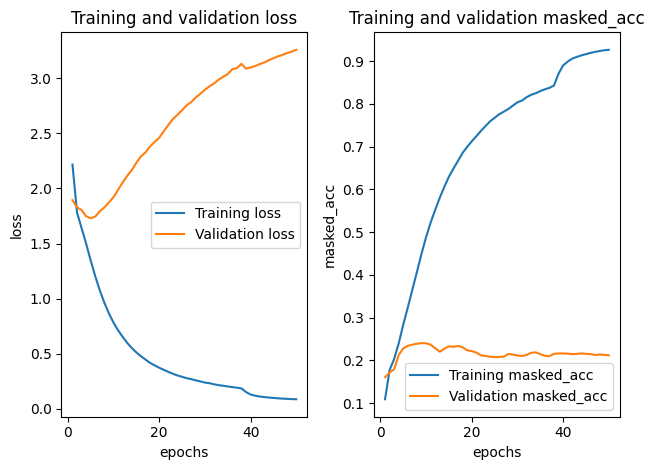

best_epoch is 9
Epoch 1/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 101s 564ms/step - loss: 2.5582 - masked_acc: 0.0725 - learning_rate: 0.0010
Epoch 2/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 451ms/step - loss: 1.8053 - masked_acc: 0.1734 - learning_rate: 0.0010
Epoch 3/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 443ms/step - loss: 1.6552 - masked_acc: 0.2016 - learning_rate: 0.0010
Epoch 4/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 53s 436ms/step - loss: 1.5090 - masked_acc: 0.2392 - learning_rate: 0.0010
Epoch 5/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 447ms/step - loss: 1.3507 - masked_acc: 0.2852 - learning_rate: 0.0010
Epoch 6/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - loss: 1.2053 - masked_acc: 0.3240 - learning_rate: 0.0010
Epoch 7/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 57s 450ms/step - loss: 1.0748 - masked_acc: 0.3640 - learning_rate: 0.0010
Epoch 8/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - loss: 0.9595 - masked_acc: 0.4064 - learning_rate: 0.0010
Epoch 9/9
122/122 ━━━━━━━━━━━━━━━━━━━━ 58s 461ms/step - loss: 0.8638 - 

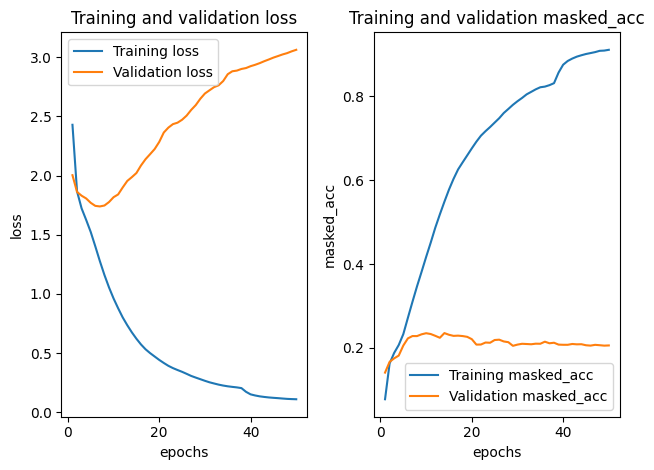

best_epoch is 14
Epoch 1/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - loss: 2.7852 - masked_acc: 0.0515 - learning_rate: 0.0010
Epoch 2/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 1.8936 - masked_acc: 0.1583 - learning_rate: 0.0010
Epoch 3/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 1.7351 - masked_acc: 0.1848 - learning_rate: 0.0010
Epoch 4/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 1.6330 - masked_acc: 0.2052 - learning_rate: 0.0010
Epoch 5/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 1.5308 - masked_acc: 0.2300 - learning_rate: 0.0010
Epoch 6/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 1.4105 - masked_acc: 0.2688 - learning_rate: 0.0010
Epoch 7/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 1.2860 - masked_acc: 0.3059 - learning_rate: 0.0010
Epoch 8/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - loss: 1.1705 - masked_acc: 0.3390 - learning_rate: 0.0010
Epoch 9/14
61/61 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 1.0656 - masked_acc: 0.3754 - learning_rate:

In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
MASK_ZERO = False

for batch_size in [16, 32, 64, 128, 256]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=512,
        normalize_first=False,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=batch_size,
        embedding_dim=128,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=512,
        normalize_first=False,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=batch_size,
        embedding_dim=128,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-11 12:00:00~)

- Identify the normalization position in each encoder/decoder.

#### Result

Normalization | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
Last | **1.737** | **0.240** | **26.3** | **6.5** | **21.5**
First | 1.815 | 0.225 | 22.8 | 5.0 | 18.8

The normalization layer should be put on the last of the encoder/decoder.

#### Next

- Comparison of the batch size

Epoch 1/50


2024-08-12 01:24:56.226490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 79s 265ms/step - loss: 2.3990 - masked_acc: 0.0887 - val_loss: 1.8548 - val_masked_acc: 0.1663 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - loss: 1.7623 - masked_acc: 0.1791 - val_loss: 1.8040 - val_masked_acc: 0.1791 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - loss: 1.5926 - masked_acc: 0.2130 - val_loss: 1.7597 - val_masked_acc: 0.2027 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 57s 245ms/step - loss: 1.4179 - masked_acc: 0.2567 - val_loss: 1.7373 - val_masked_acc: 0.2240 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 242ms/step - loss: 1.2492 - masked_acc: 0.2997 - val_loss: 1.7655 - val_masked_acc: 0.2359 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 57s 246ms/step - loss: 1.1068 - masked_acc: 0.3428 - val_loss: 1.7936 - val_masked_acc: 0.2401 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 58s 249ms/step - 

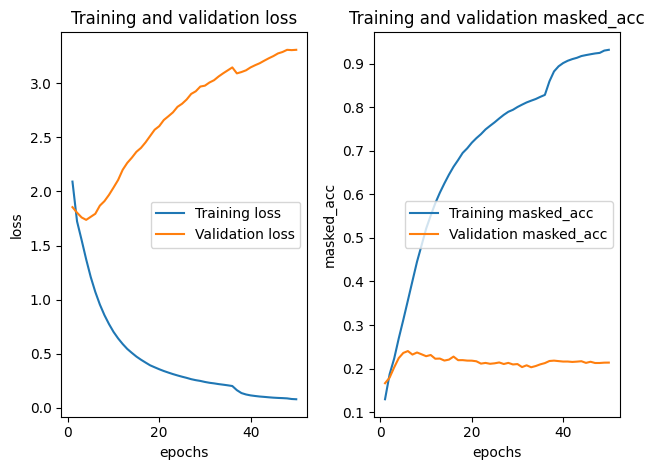

best_epoch is 6
Epoch 1/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 84s 264ms/step - loss: 2.3796 - masked_acc: 0.0924 - learning_rate: 0.0010
Epoch 2/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 61s 248ms/step - loss: 1.7553 - masked_acc: 0.1816 - learning_rate: 0.0010
Epoch 3/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 241ms/step - loss: 1.5821 - masked_acc: 0.2176 - learning_rate: 0.0010
Epoch 4/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 242ms/step - loss: 1.3997 - masked_acc: 0.2658 - learning_rate: 0.0010
Epoch 5/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 241ms/step - loss: 1.2310 - masked_acc: 0.3081 - learning_rate: 0.0010
Epoch 6/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 240ms/step - loss: 1.0862 - masked_acc: 0.3514 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-12_02-11-58.keras
Successfully saved model to model/summarization_model_2024-08-12_02-11-58.keras


2024-08-12 02:26:59.485261: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.32461265>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.24849744>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.26341236>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.08053455>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.06167657>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.06505917>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.26294106>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20445691>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2151812>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 93s 300ms/step - loss: 2.3812 - masked_acc: 0.0736 - val_loss: 1.9362 - val_masked_acc: 0.1466 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 61s 257ms/step - loss: 1.8971 - masked_acc: 0.1506 - val_loss: 1.8727 - val_masked_acc: 0.1685 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 59s 257ms/step - loss: 1.7763 -

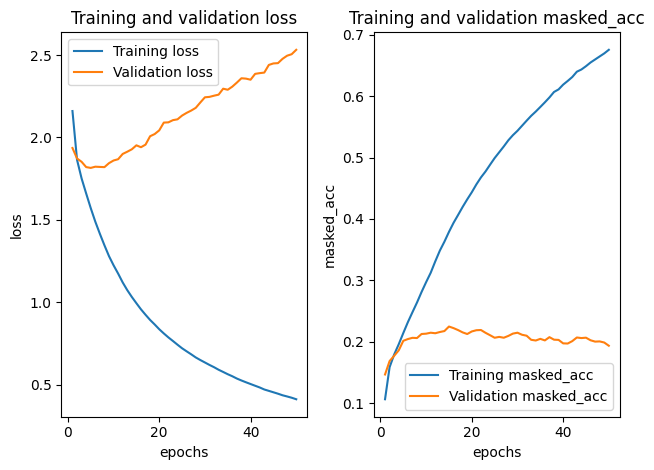

best_epoch is 15
Epoch 1/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 96s 268ms/step - loss: 2.3820 - masked_acc: 0.0725 - learning_rate: 0.0010
Epoch 2/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 245ms/step - loss: 1.8898 - masked_acc: 0.1540 - learning_rate: 0.0010
Epoch 3/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - loss: 1.7671 - masked_acc: 0.1763 - learning_rate: 0.0010
Epoch 4/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 64s 260ms/step - loss: 1.6657 - masked_acc: 0.1965 - learning_rate: 0.0010
Epoch 5/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 63s 255ms/step - loss: 1.5774 - masked_acc: 0.2119 - learning_rate: 0.0010
Epoch 6/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 64s 261ms/step - loss: 1.4957 - masked_acc: 0.2299 - learning_rate: 0.0010
Epoch 7/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 62s 253ms/step - loss: 1.4210 - masked_acc: 0.2452 - learning_rate: 0.0010
Epoch 8/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 61s 247ms/step - loss: 1.3501 - masked_acc: 0.2620 - learning_rate: 0.0010
Epoch 9/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 61s 246ms/step - loss: 

In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
MASK_ZERO = False

for normalize_first in [False, True]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=512,
        normalize_first=normalize_first,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=128,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=512,
        normalize_first=normalize_first,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=128,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-11 02:14:00~)

- Comparison of the number of the embedding dimension

#### Result

Dimensions | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
32 | 1.825 | 0.210 | 23.4 | 5.3 | 19.4
64 | 1.756 | 0.232 | 24.9 | 6.2 | 20.5
128 | **1.744** | **0.238** | 25.8 | 6.2 | 20.8
256 | 1.830 | **0.238** | **27.3** | **6.4** | **21.7**

#### Next

- Identify the normalization position in each encoder/decoder.

Epoch 1/50


2024-08-11 02:15:12.988238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 70s 219ms/step - loss: 2.7218 - masked_acc: 0.0492 - val_loss: 2.0039 - val_masked_acc: 0.1351 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 47s 201ms/step - loss: 1.9346 - masked_acc: 0.1481 - val_loss: 1.8799 - val_masked_acc: 0.1625 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 45s 195ms/step - loss: 1.7905 - masked_acc: 0.1768 - val_loss: 1.8490 - val_masked_acc: 0.1710 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 46s 197ms/step - loss: 1.7047 - masked_acc: 0.1976 - val_loss: 1.8306 - val_masked_acc: 0.1796 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 45s 196ms/step - loss: 1.6327 - masked_acc: 0.2131 - val_loss: 1.8304 - val_masked_acc: 0.1803 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 45s 197ms/step - loss: 1.5674 - masked_acc: 0.2280 - val_loss: 1.8252 - val_masked_acc: 0.1876 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 46s 197ms/step - 

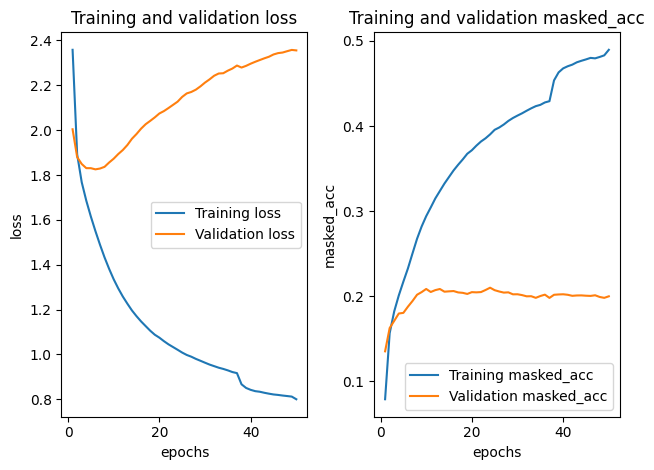

best_epoch is 24
Epoch 1/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 73s 214ms/step - loss: 2.7068 - masked_acc: 0.0526 - learning_rate: 0.0010
Epoch 2/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - loss: 1.9195 - masked_acc: 0.1491 - learning_rate: 0.0010
Epoch 3/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 184ms/step - loss: 1.7858 - masked_acc: 0.1777 - learning_rate: 0.0010
Epoch 4/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 185ms/step - loss: 1.7003 - masked_acc: 0.1976 - learning_rate: 0.0010
Epoch 5/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 185ms/step - loss: 1.6292 - masked_acc: 0.2135 - learning_rate: 0.0010
Epoch 6/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 185ms/step - loss: 1.5636 - masked_acc: 0.2289 - learning_rate: 0.0010
Epoch 7/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - loss: 1.5025 - masked_acc: 0.2462 - learning_rate: 0.0010
Epoch 8/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 184ms/step - loss: 1.4444 - masked_acc: 0.2626 - learning_rate: 0.0010
Epoch 9/24
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 185ms/step - loss: 

2024-08-11 03:21:00.006079: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.26197582>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.24088244>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2344078>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.060577914>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.054346766>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.05327523>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.21535519>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20122851>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19389114>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 80s 251ms/step - loss: 2.5311 - masked_acc: 0.0746 - val_loss: 1.8960 - val_masked_acc: 0.1604 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 47s 202ms/step - loss: 1.8221 - masked_acc: 0.1713 - val_loss: 1.8202 - val_masked_acc: 0.1761 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - loss: 1.6807

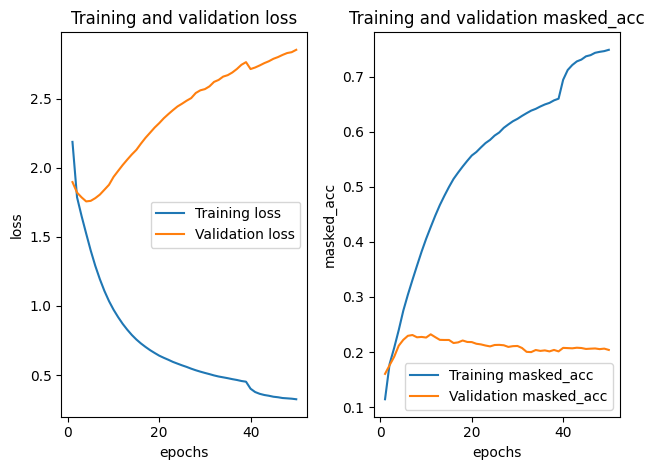

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 81s 229ms/step - loss: 2.5132 - masked_acc: 0.0759 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 203ms/step - loss: 1.8135 - masked_acc: 0.1718 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 207ms/step - loss: 1.6746 - masked_acc: 0.2024 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 204ms/step - loss: 1.5488 - masked_acc: 0.2352 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 206ms/step - loss: 1.4256 - masked_acc: 0.2681 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 206ms/step - loss: 1.3123 - masked_acc: 0.2983 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 205ms/step - loss: 1.2138 - masked_acc: 0.3250 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 204ms/step - loss: 1.1269 - masked_acc: 0.3518 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 49s 203ms/step - loss: 

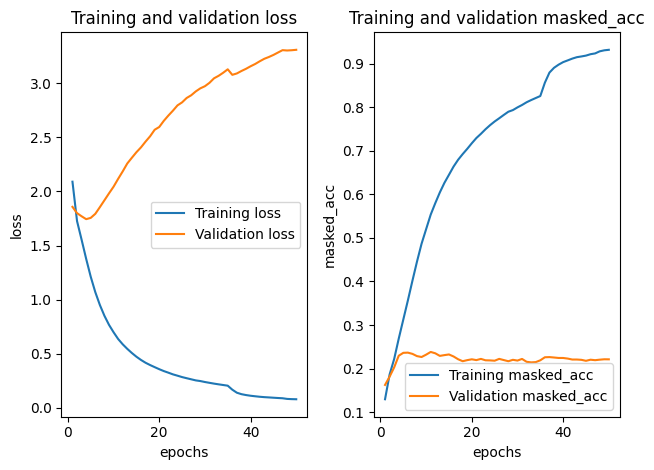

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 96s 279ms/step - loss: 2.3727 - masked_acc: 0.0939 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 242ms/step - loss: 1.7563 - masked_acc: 0.1811 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 242ms/step - loss: 1.5851 - masked_acc: 0.2162 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 244ms/step - loss: 1.4033 - masked_acc: 0.2644 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 243ms/step - loss: 1.2312 - masked_acc: 0.3082 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 243ms/step - loss: 1.0856 - masked_acc: 0.3524 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 242ms/step - loss: 0.9643 - masked_acc: 0.3949 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 243ms/step - loss: 0.8655 - masked_acc: 0.4398 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 245ms/step - loss: 

2024-08-11 05:29:28.978304: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.29527444>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.26194027>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.25810915>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0733764>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.062311236>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.06201914>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.23761259>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.21257943>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.20846659>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 118s 377ms/step - loss: 2.3420 - masked_acc: 0.0881 - val_loss: 1.8524 - val_masked_acc: 0.1656 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 318ms/step - loss: 1.7417 - masked_acc: 0.1802 - val_loss: 1.8298 - val_masked_acc: 0.1738 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 74s 314ms/step - loss: 1.5467

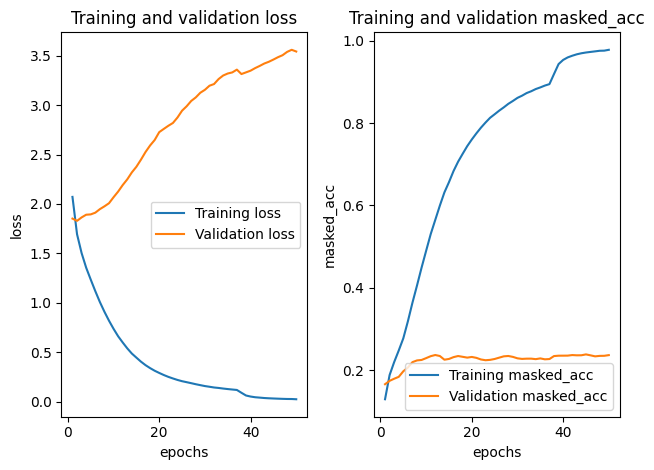

best_epoch is 45
Epoch 1/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 121s 348ms/step - loss: 2.3152 - masked_acc: 0.0934 - learning_rate: 0.0010
Epoch 2/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 314ms/step - loss: 1.7326 - masked_acc: 0.1815 - learning_rate: 0.0010
Epoch 3/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 77s 313ms/step - loss: 1.5441 - masked_acc: 0.2109 - learning_rate: 0.0010
Epoch 4/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 315ms/step - loss: 1.3892 - masked_acc: 0.2389 - learning_rate: 0.0010
Epoch 5/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 315ms/step - loss: 1.2727 - masked_acc: 0.2659 - learning_rate: 0.0010
Epoch 6/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 316ms/step - loss: 1.1664 - masked_acc: 0.2999 - learning_rate: 0.0010
Epoch 7/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 314ms/step - loss: 1.0646 - masked_acc: 0.3375 - learning_rate: 0.0010
Epoch 8/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 315ms/step - loss: 0.9709 - masked_acc: 0.3774 - learning_rate: 0.0010
Epoch 9/45
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 315ms/step - loss:

In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NORMALIZE_FIRST = False
MASK_ZERO = False

for embedding_dim in [32, 64, 128, 256]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=512,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=embedding_dim,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=512,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=embedding_dim,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-10 21:50:00~)

- Comparison the number of intermediate dimensions

#### Result

Dimensions | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
256 | 1.769 | 0.229 | 25.7 | 6.6 | 21.1
512 | **1.756** | **0.234** | 25.6 | **6.7** | 21.3
1024 | 1.764 | 0.231 | 25.8 | **6.7** | 21.2
2048 | 1.766 | 0.231 | **26.1** | 6.6 | **21.4**

There are seemingly no remarkable differences. There are also seemingly no reasons to keep the value 1024. Therefore, 512 is adopted to avoid overfitting.

#### Next

- Comparison of the number of the embedding dimension

Epoch 1/50


2024-08-10 21:57:43.860962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 73s 232ms/step - loss: 2.5400 - masked_acc: 0.0721 - val_loss: 1.8934 - val_masked_acc: 0.1611 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 48s 209ms/step - loss: 1.8218 - masked_acc: 0.1706 - val_loss: 1.8239 - val_masked_acc: 0.1750 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 48s 210ms/step - loss: 1.6828 - masked_acc: 0.1994 - val_loss: 1.7925 - val_masked_acc: 0.1893 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 49s 213ms/step - loss: 1.5620 - masked_acc: 0.2293 - val_loss: 1.7734 - val_masked_acc: 0.2064 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 50s 216ms/step - loss: 1.4392 - masked_acc: 0.2640 - val_loss: 1.7691 - val_masked_acc: 0.2220 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 49s 211ms/step - loss: 1.3267 - masked_acc: 0.2947 - val_loss: 1.7871 - val_masked_acc: 0.2236 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 49s 213ms/step - 

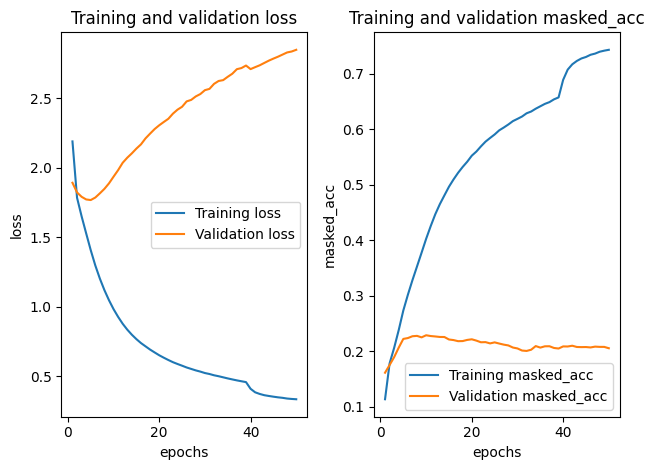

best_epoch is 10
Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 75s 222ms/step - loss: 2.5228 - masked_acc: 0.0744 - learning_rate: 0.0010
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - loss: 1.8152 - masked_acc: 0.1722 - learning_rate: 0.0010
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 215ms/step - loss: 1.6729 - masked_acc: 0.2028 - learning_rate: 0.0010
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 209ms/step - loss: 1.5453 - masked_acc: 0.2351 - learning_rate: 0.0010
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 204ms/step - loss: 1.4218 - masked_acc: 0.2698 - learning_rate: 0.0010
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 205ms/step - loss: 1.3083 - masked_acc: 0.2988 - learning_rate: 0.0010
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 214ms/step - loss: 1.2099 - masked_acc: 0.3252 - learning_rate: 0.0010
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - loss: 1.1257 - masked_acc: 0.3493 - learning_rate: 0.0010
Epoch 9/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 49s 202ms/step - loss: 

2024-08-10 22:57:30.116203: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.29948685>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.25488195>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.25660038>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07773383>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.06581822>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.06597607>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.2445102>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.21150726>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.21130173>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 100s 295ms/step - loss: 2.5336 - masked_acc: 0.0769 - val_loss: 1.8914 - val_masked_acc: 0.1590 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 59s 254ms/step - loss: 1.8193 - masked_acc: 0.1706 - val_loss: 1.8216 - val_masked_acc: 0.1767 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 58s 250ms/step - loss: 1.6813 

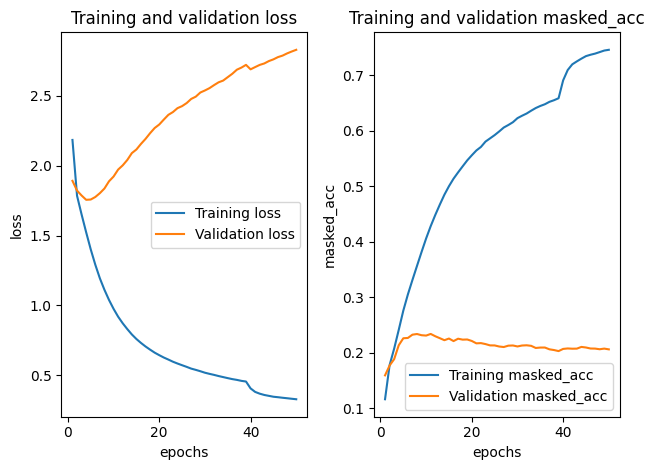

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 91s 241ms/step - loss: 2.5242 - masked_acc: 0.0762 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 214ms/step - loss: 1.8148 - masked_acc: 0.1716 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - loss: 1.6732 - masked_acc: 0.2026 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 216ms/step - loss: 1.5463 - masked_acc: 0.2347 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - loss: 1.4228 - masked_acc: 0.2696 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 216ms/step - loss: 1.3084 - masked_acc: 0.2998 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 218ms/step - loss: 1.2095 - masked_acc: 0.3267 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 221ms/step - loss: 1.1240 - masked_acc: 0.3513 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 230ms/step - loss: 

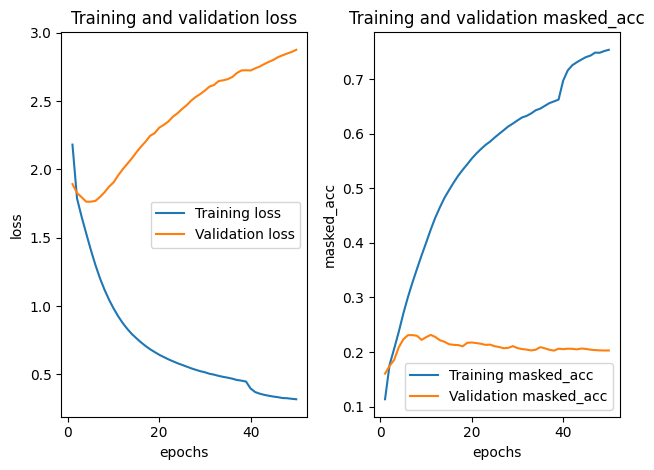

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 89s 249ms/step - loss: 2.5157 - masked_acc: 0.0748 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 217ms/step - loss: 1.8137 - masked_acc: 0.1727 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 221ms/step - loss: 1.6724 - masked_acc: 0.2029 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 219ms/step - loss: 1.5462 - masked_acc: 0.2356 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 223ms/step - loss: 1.4215 - masked_acc: 0.2702 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 218ms/step - loss: 1.3067 - masked_acc: 0.3012 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 216ms/step - loss: 1.2081 - masked_acc: 0.3279 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - loss: 1.1212 - masked_acc: 0.3521 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 211ms/step - loss: 

2024-08-11 01:04:55.660656: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.3107834>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2490306>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.25834513>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.083170496>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.06418644>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.06721978>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.25373325>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20572516>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.21214442>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 99s 274ms/step - loss: 2.5295 - masked_acc: 0.0767 - val_loss: 1.8935 - val_masked_acc: 0.1600 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 53s 229ms/step - loss: 1.8203 - masked_acc: 0.1702 - val_loss: 1.8270 - val_masked_acc: 0.1725 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 54s 232ms/step - loss: 1.6866 -

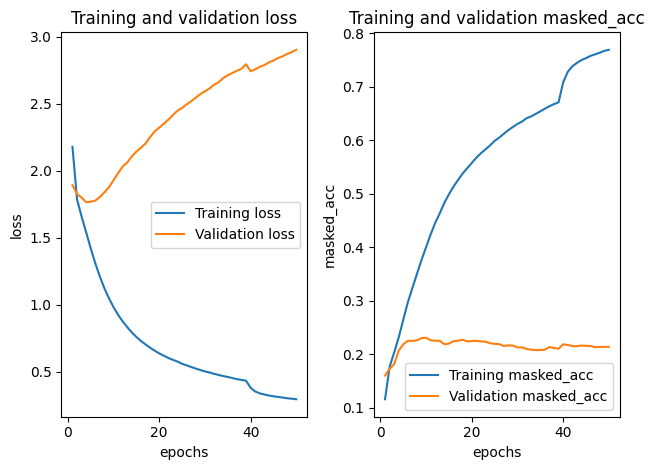

best_epoch is 10
Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 99s 262ms/step - loss: 2.5116 - masked_acc: 0.0752 - learning_rate: 0.0010
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 226ms/step - loss: 1.8142 - masked_acc: 0.1720 - learning_rate: 0.0010
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 224ms/step - loss: 1.6800 - masked_acc: 0.1991 - learning_rate: 0.0010
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 226ms/step - loss: 1.5634 - masked_acc: 0.2261 - learning_rate: 0.0010
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 221ms/step - loss: 1.4443 - masked_acc: 0.2595 - learning_rate: 0.0010
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 227ms/step - loss: 1.3292 - masked_acc: 0.2911 - learning_rate: 0.0010
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 220ms/step - loss: 1.2277 - masked_acc: 0.3202 - learning_rate: 0.0010
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 216ms/step - loss: 1.1395 - masked_acc: 0.3455 - learning_rate: 0.0010
Epoch 9/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 216ms/step - loss: 

In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NORMALIZE_FIRST = False
EMBEDDING_DIM = 64
MASK_ZERO = False

for transformer_intermediate_dim in [256, 512, 1024, 2048]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=6,
        dropout=0.35,
        transformer_intermediate_dim=transformer_intermediate_dim,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-10 12:16:00~)

- Comparison the number of Transformer heads

#### Result

Heads | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
4 | **1.756** | **0.233** | 26.0 | 6.6 | 21.2
6 | 1.760 | 0.231 | **26.3** | **6.8** | **21.3**
8 | 1.764 | 0.228 | 25.7 | 6.5 | 20.9
12 | 1.776 | 0.223 | 24.3 | 5.9 | 20.2
16 | 1.786 | 0.219 | 23.7 | 5.7 | 20.0

The loss and accuracy value is the best when the number of heads is 4. It is supposed that the lowest value was the best because the model tends to easily overfit. However, 6 is chosen due to the following reasons;

- The ROUGE metrics marked the best when the number of heads was 6.
- The minimum numbers of heads were 6 in the papers that I have read.
- The results of 4 and 6 are very close to each other.

#### Next

- Comparison of the number of the intermediate dimension
- Comparison of the number of the embedding dimension

Epoch 1/50


2024-08-10 12:18:00.774577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 74s 234ms/step - loss: 2.5323 - masked_acc: 0.0769 - val_loss: 1.8927 - val_masked_acc: 0.1599 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 48s 206ms/step - loss: 1.8187 - masked_acc: 0.1709 - val_loss: 1.8228 - val_masked_acc: 0.1767 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - loss: 1.6814 - masked_acc: 0.2001 - val_loss: 1.7947 - val_masked_acc: 0.1901 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 49s 211ms/step - loss: 1.5598 - masked_acc: 0.2302 - val_loss: 1.7607 - val_masked_acc: 0.2112 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 49s 211ms/step - loss: 1.4351 - masked_acc: 0.2659 - val_loss: 1.7562 - val_masked_acc: 0.2235 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - loss: 1.3177 - masked_acc: 0.2992 - val_loss: 1.7715 - val_masked_acc: 0.2285 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 48s 208ms/step - 

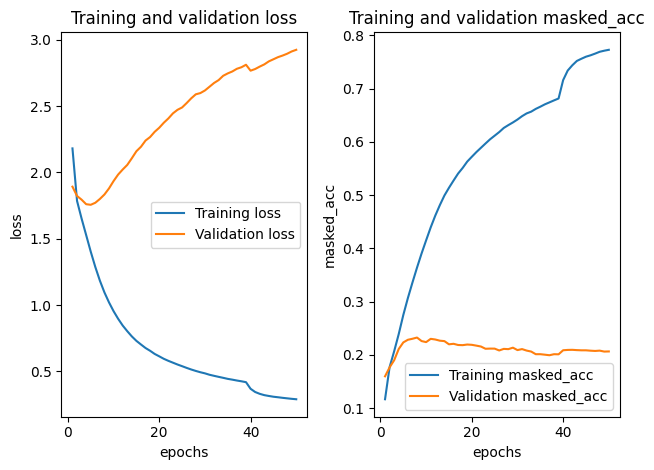

best_epoch is 8
Epoch 1/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 84s 254ms/step - loss: 2.5086 - masked_acc: 0.0783 - learning_rate: 0.0010
Epoch 2/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 218ms/step - loss: 1.8159 - masked_acc: 0.1714 - learning_rate: 0.0010
Epoch 3/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 226ms/step - loss: 1.6786 - masked_acc: 0.2011 - learning_rate: 0.0010
Epoch 4/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - loss: 1.5514 - masked_acc: 0.2328 - learning_rate: 0.0010
Epoch 5/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 208ms/step - loss: 1.4246 - masked_acc: 0.2692 - learning_rate: 0.0010
Epoch 6/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 208ms/step - loss: 1.3042 - masked_acc: 0.3019 - learning_rate: 0.0010
Epoch 7/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 209ms/step - loss: 1.2004 - masked_acc: 0.3316 - learning_rate: 0.0010
Epoch 8/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 210ms/step - loss: 1.1117 - masked_acc: 0.3579 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-10_12-59-07.keras
Successful

2024-08-10 14:04:53.711078: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.28770903>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.26972133>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.26017675>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07367231>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.06931642>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.06616278>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.2337936>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.22166334>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.21212892>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 84s 263ms/step - loss: 2.5313 - masked_acc: 0.0764 - val_loss: 1.8922 - val_masked_acc: 0.1592 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 51s 222ms/step - loss: 1.8193 - masked_acc: 0.1707 - val_loss: 1.8223 - val_masked_acc: 0.1743 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 52s 223ms/step - loss: 1.6803 -

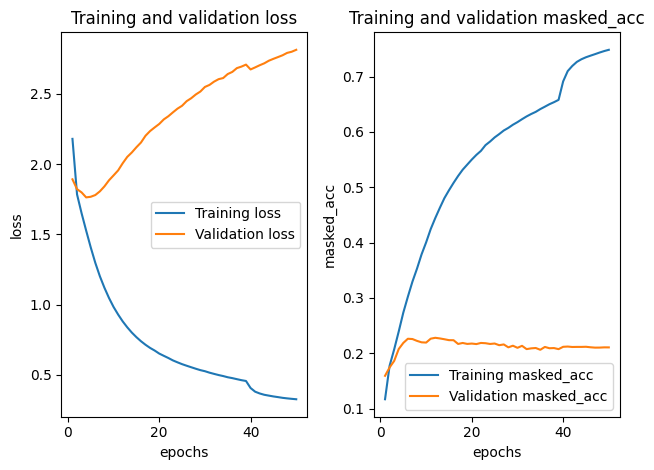

best_epoch is 12
Epoch 1/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 85s 253ms/step - loss: 2.5093 - masked_acc: 0.0768 - learning_rate: 0.0010
Epoch 2/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 227ms/step - loss: 1.8159 - masked_acc: 0.1716 - learning_rate: 0.0010
Epoch 3/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 222ms/step - loss: 1.6792 - masked_acc: 0.2002 - learning_rate: 0.0010
Epoch 4/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 228ms/step - loss: 1.5563 - masked_acc: 0.2298 - learning_rate: 0.0010
Epoch 5/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 223ms/step - loss: 1.4332 - masked_acc: 0.2643 - learning_rate: 0.0010
Epoch 6/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 219ms/step - loss: 1.3209 - masked_acc: 0.2943 - learning_rate: 0.0010
Epoch 7/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 221ms/step - loss: 1.2222 - masked_acc: 0.3201 - learning_rate: 0.0010
Epoch 8/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 220ms/step - loss: 1.1376 - masked_acc: 0.3443 - learning_rate: 0.0010
Epoch 9/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 222ms/step - loss: 

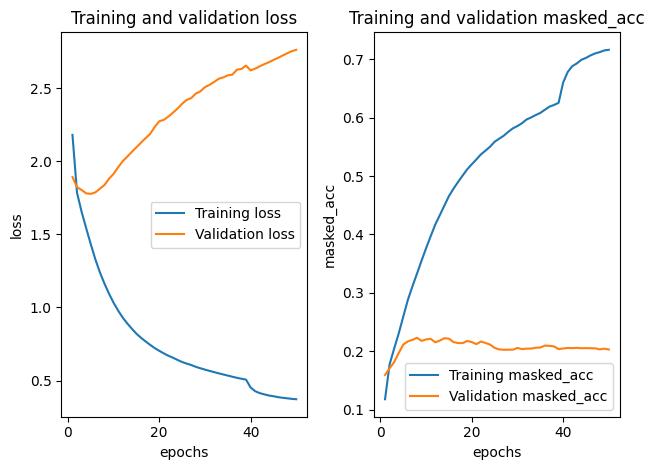

best_epoch is 8
Epoch 1/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 95s 268ms/step - loss: 2.5127 - masked_acc: 0.0780 - learning_rate: 0.0010
Epoch 2/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 224ms/step - loss: 1.8133 - masked_acc: 0.1719 - learning_rate: 0.0010
Epoch 3/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 225ms/step - loss: 1.6804 - masked_acc: 0.1992 - learning_rate: 0.0010
Epoch 4/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 226ms/step - loss: 1.5660 - masked_acc: 0.2241 - learning_rate: 0.0010
Epoch 5/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 226ms/step - loss: 1.4515 - masked_acc: 0.2562 - learning_rate: 0.0010
Epoch 6/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 225ms/step - loss: 1.3439 - masked_acc: 0.2849 - learning_rate: 0.0010
Epoch 7/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 227ms/step - loss: 1.2495 - masked_acc: 0.3089 - learning_rate: 0.0010
Epoch 8/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 225ms/step - loss: 1.1689 - masked_acc: 0.3305 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-10_16-00-51.keras
Successful

2024-08-10 16:18:22.249694: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.2938923>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.23065759>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.24328448>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07306067>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.05563261>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.059221726>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.24274148>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19339341>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.20233561>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 112s 338ms/step - loss: 2.5239 - masked_acc: 0.0687 - val_loss: 1.8932 - val_masked_acc: 0.1596 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 61s 260ms/step - loss: 1.8177 - masked_acc: 0.1715 - val_loss: 1.8293 - val_masked_acc: 0.1727 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 59s 254ms/step - loss: 1.6863

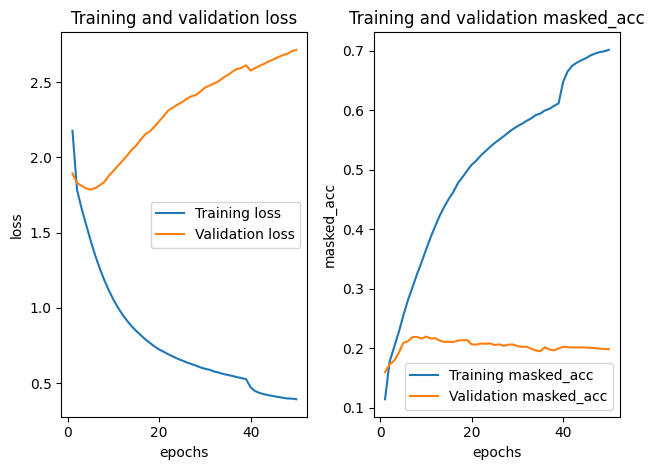

best_epoch is 10
Epoch 1/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 103s 304ms/step - loss: 2.5073 - masked_acc: 0.0797 - learning_rate: 0.0010
Epoch 2/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 245ms/step - loss: 1.8112 - masked_acc: 0.1730 - learning_rate: 0.0010
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 245ms/step - loss: 1.6786 - masked_acc: 0.2003 - learning_rate: 0.0010
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 243ms/step - loss: 1.5678 - masked_acc: 0.2241 - learning_rate: 0.0010
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 243ms/step - loss: 1.4594 - masked_acc: 0.2514 - learning_rate: 0.0010
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 241ms/step - loss: 1.3572 - masked_acc: 0.2778 - learning_rate: 0.0010
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 239ms/step - loss: 1.2661 - masked_acc: 0.3005 - learning_rate: 0.0010
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 58s 240ms/step - loss: 1.1862 - masked_acc: 0.3239 - learning_rate: 0.0010
Epoch 9/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 244ms/step - loss:

In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
EMBEDDING_DIM = 64
MASK_ZERO = False

for num_heads in [4, 8, 12, 16]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=num_heads,
        dropout=0.35,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=num_heads,
        dropout=0.35,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 106s 305ms/step - loss: 2.5304 - masked_acc: 0.0761 - val_loss: 1.8911 - val_masked_acc: 0.1596 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 53s 228ms/step - loss: 1.8186 - masked_acc: 0.1711 - val_loss: 1.8182 - val_masked_acc: 0.1758 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 52s 223ms/step - loss: 1.6801 - masked_acc: 0.1999 - val_loss: 1.7894 - val_masked_acc: 0.1864 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 52s 226ms/step - loss: 1.5592 - masked_acc: 0.2292 - val_loss: 1.7595 - val_masked_acc: 0.2102 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 54s 233ms/step - loss: 1.4394 - masked_acc: 0.2633 - val_loss: 1.7612 - val_masked_acc: 0.2218 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 52s 226ms/step - loss: 1.3249 - masked_acc: 0.2951 - val_loss: 1.7753 - val_masked_acc: 0.2266 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 53s 2

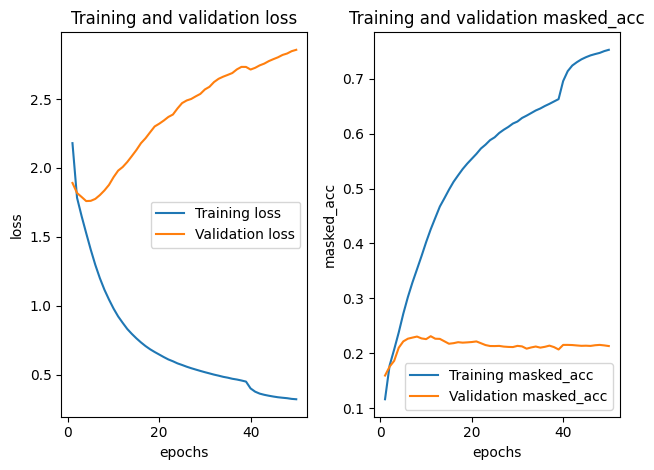

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 103s 294ms/step - loss: 2.5107 - masked_acc: 0.0735 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 225ms/step - loss: 1.8166 - masked_acc: 0.1719 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 219ms/step - loss: 1.6806 - masked_acc: 0.2015 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 230ms/step - loss: 1.5567 - masked_acc: 0.2314 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 228ms/step - loss: 1.4319 - masked_acc: 0.2673 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 222ms/step - loss: 1.3161 - masked_acc: 0.2985 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 228ms/step - loss: 1.2159 - masked_acc: 0.3237 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 57s 233ms/step - loss: 1.1308 - masked_acc: 0.3485 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 57s 234ms/step - loss:

In [23]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
EMBEDDING_DIM = 64
MASK_ZERO = False

for num_heads in [6]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=num_heads,
        dropout=0.35,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=2,
        num_decoders=2,
        num_heads=num_heads,
        dropout=0.35,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=1e-5,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=True,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-02 13:52:00~, 2024-08-09 18:14:00~)

- Comparison of the number of layers model (50 epoch)

#### Result

Encoders/Decoders | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
1 | 1.800 | 0.221 | 23.0 | 5.4 | 19.2
2 | 1.812 | 0.220 | 22.8 | 5.0 | 19.1
4 | 1.811 | 0.188 | 24.6(13.00) | 5.8(1.6) | 20.2(11.2)
2 Residual | **1.761** | **0.230** | **25.4** | **6.4** | 20.7
4 Residual | 1.770 | 0.228 | 25.3 | 6.2 | **21.0**

- The model having 2 encoders and 2 decoders with residual connections worked the best.
- As the model having 4 encoders and 4 decoders indicates, the ROUGE metrics is sometimes unstable.

#### Next

- Comparison of the number of the heads
- Comparison of the number of the intermediate dimension
- Comparison of the number of the embedding dimension

Epoch 1/50


2024-08-10 00:31:26.689676: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


231/231 ━━━━━━━━━━━━━━━━━━━━ 80s 261ms/step - loss: 2.5298 - masked_acc: 0.0759 - val_loss: 1.8941 - val_masked_acc: 0.1596 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 51s 221ms/step - loss: 1.8218 - masked_acc: 0.1704 - val_loss: 1.8213 - val_masked_acc: 0.1751 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 51s 220ms/step - loss: 1.6832 - masked_acc: 0.2000 - val_loss: 1.7852 - val_masked_acc: 0.1901 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 51s 219ms/step - loss: 1.5621 - masked_acc: 0.2279 - val_loss: 1.7608 - val_masked_acc: 0.2045 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 50s 217ms/step - loss: 1.4433 - masked_acc: 0.2609 - val_loss: 1.7610 - val_masked_acc: 0.2227 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 51s 221ms/step - loss: 1.3281 - masked_acc: 0.2934 - val_loss: 1.7720 - val_masked_acc: 0.2240 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - 

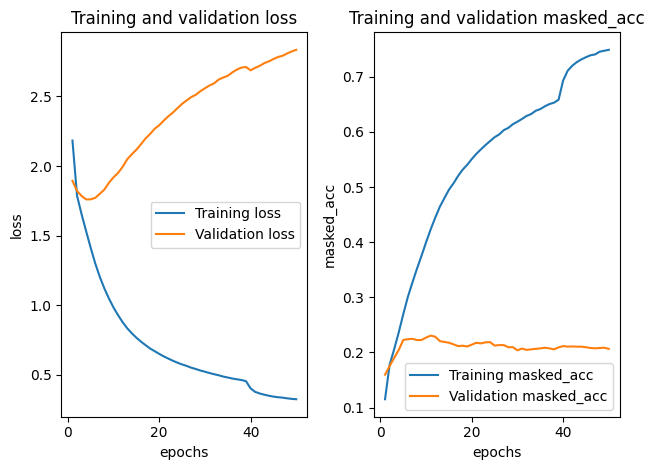

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 84s 236ms/step - loss: 2.5123 - masked_acc: 0.0758 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - loss: 1.8142 - masked_acc: 0.1729 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 210ms/step - loss: 1.6753 - masked_acc: 0.2020 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 210ms/step - loss: 1.5532 - masked_acc: 0.2319 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 213ms/step - loss: 1.4323 - masked_acc: 0.2657 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 209ms/step - loss: 1.3213 - masked_acc: 0.2956 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - loss: 1.2221 - masked_acc: 0.3207 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 212ms/step - loss: 1.1366 - masked_acc: 0.3467 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 209ms/step - loss: 

2024-08-10 01:32:37.009415: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.29913774>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.24714607>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2544884>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07614454>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.06197657>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.064213715>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.24168998>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20238043>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.20695989>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 164s 442ms/step - loss: 2.4008 - masked_acc: 0.0839 - val_loss: 1.8641 - val_masked_acc: 0.1664 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 77s 330ms/step - loss: 1.7809 - masked_acc: 0.1764 - val_loss: 1.8161 - val_masked_acc: 0.1762 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 325ms/step - loss: 1.6318

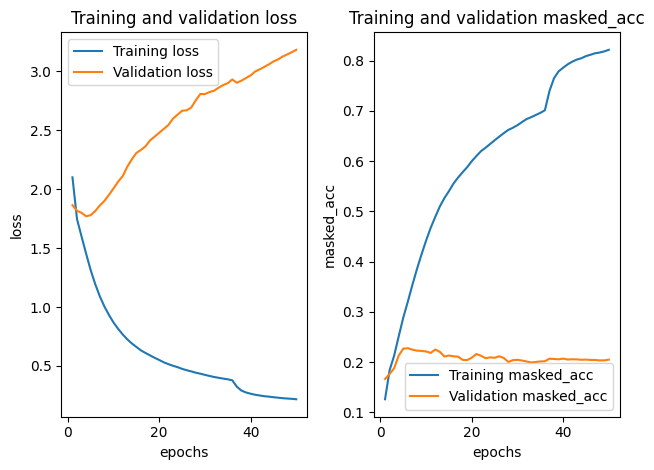

best_epoch is 6
Epoch 1/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 164s 423ms/step - loss: 2.3767 - masked_acc: 0.0884 - learning_rate: 0.0010
Epoch 2/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 76s 311ms/step - loss: 1.7731 - masked_acc: 0.1785 - learning_rate: 0.0010
Epoch 3/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 75s 309ms/step - loss: 1.6173 - masked_acc: 0.2113 - learning_rate: 0.0010
Epoch 4/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 76s 310ms/step - loss: 1.4592 - masked_acc: 0.2520 - learning_rate: 0.0010
Epoch 5/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 75s 308ms/step - loss: 1.3098 - masked_acc: 0.2901 - learning_rate: 0.0010
Epoch 6/6
243/243 ━━━━━━━━━━━━━━━━━━━━ 76s 311ms/step - loss: 1.1860 - masked_acc: 0.3227 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-10_02-35-52.keras
Successfully saved model to model/summarization_model_2024-08-10_02-35-52.keras
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.315508>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2367245>, 'f1_score': <tf.Tensor: 

In [24]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
# NUM_ENCODERS = 1
# NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.35
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

for layers in [2, 4]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=layers,
        num_decoders=layers,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=LAYER_NORM_EPSILON,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=USE_RESIDUAL,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=layers,
        num_decoders=layers,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=LAYER_NORM_EPSILON,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=USE_RESIDUAL,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 65s 199ms/step - loss: 2.7373 - masked_acc: 0.0542 - val_loss: 1.9836 - val_masked_acc: 0.1388 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 165ms/step - loss: 1.9148 - masked_acc: 0.1536 - val_loss: 1.8644 - val_masked_acc: 0.1659 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - loss: 1.7688 - masked_acc: 0.1827 - val_loss: 1.8318 - val_masked_acc: 0.1741 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 165ms/step - loss: 1.6774 - masked_acc: 0.2022 - val_loss: 1.8132 - val_masked_acc: 0.1807 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - loss: 1.5957 - masked_acc: 0.2198 - val_loss: 1.8038 - val_masked_acc: 0.1875 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.5150 - masked_acc: 0.2394 - val_loss: 1.7999 - val_masked_acc: 0.1963 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 16

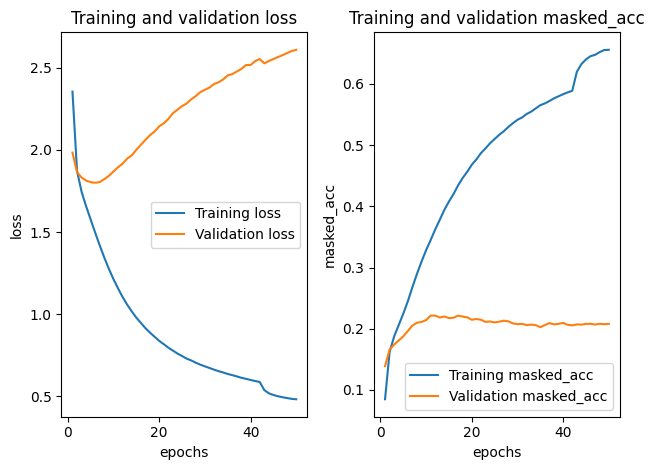

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 63s 184ms/step - loss: 2.7165 - masked_acc: 0.0581 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.9042 - masked_acc: 0.1562 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.7623 - masked_acc: 0.1838 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.6690 - masked_acc: 0.2046 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.5872 - masked_acc: 0.2224 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.5071 - masked_acc: 0.2425 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.4287 - masked_acc: 0.2659 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.3554 - masked_acc: 0.2865 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 

2024-08-10 03:45:58.119152: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.2703022>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.22452305>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2302928>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.06380942>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.05189114>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.053689096>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.22341517>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.1886267>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19192454>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 89s 283ms/step - loss: 2.7337 - masked_acc: 0.0524 - val_loss: 1.9953 - val_masked_acc: 0.1359 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 51s 220ms/step - loss: 1.9289 - masked_acc: 0.1512 - val_loss: 1.8697 - val_masked_acc: 0.1662 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 50s 218ms/step - loss: 1.7807 - 

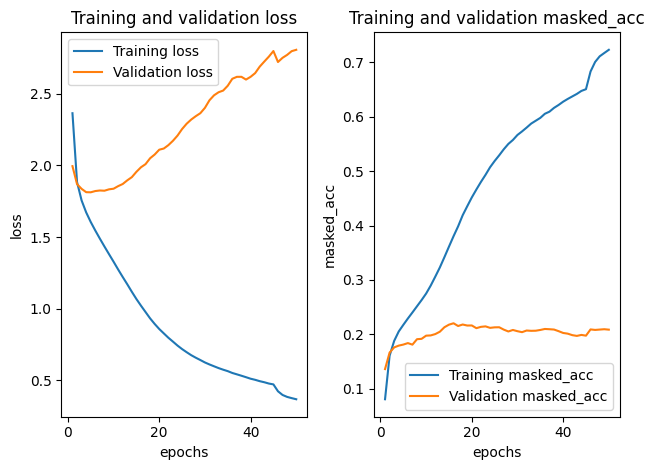

best_epoch is 16
Epoch 1/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 94s 267ms/step - loss: 2.7176 - masked_acc: 0.0466 - learning_rate: 0.0010
Epoch 2/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 215ms/step - loss: 1.9159 - masked_acc: 0.1543 - learning_rate: 0.0010
Epoch 3/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 221ms/step - loss: 1.7711 - masked_acc: 0.1845 - learning_rate: 0.0010
Epoch 4/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 228ms/step - loss: 1.6840 - masked_acc: 0.2038 - learning_rate: 0.0010
Epoch 5/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 225ms/step - loss: 1.6162 - masked_acc: 0.2169 - learning_rate: 0.0010
Epoch 6/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 57s 232ms/step - loss: 1.5558 - masked_acc: 0.2271 - learning_rate: 0.0010
Epoch 7/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 55s 226ms/step - loss: 1.4994 - masked_acc: 0.2386 - learning_rate: 0.0010
Epoch 8/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 53s 217ms/step - loss: 1.4434 - masked_acc: 0.2506 - learning_rate: 0.0010
Epoch 9/16
243/243 ━━━━━━━━━━━━━━━━━━━━ 52s 214ms/step - loss: 

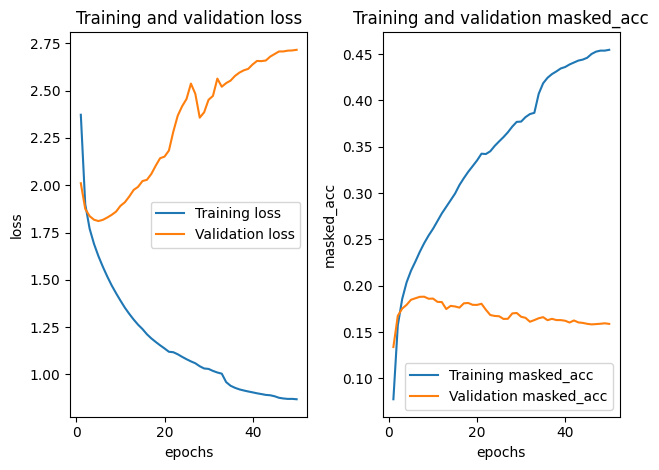

best_epoch is 8
Epoch 1/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 199s 475ms/step - loss: 2.7122 - masked_acc: 0.0552 - learning_rate: 0.0010
Epoch 2/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 320ms/step - loss: 1.9368 - masked_acc: 0.1492 - learning_rate: 0.0010
Epoch 3/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 319ms/step - loss: 1.7915 - masked_acc: 0.1809 - learning_rate: 0.0010
Epoch 4/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 79s 326ms/step - loss: 1.7055 - masked_acc: 0.2006 - learning_rate: 0.0010
Epoch 5/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 79s 323ms/step - loss: 1.6373 - masked_acc: 0.2139 - learning_rate: 0.0010
Epoch 6/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 77s 316ms/step - loss: 1.5786 - masked_acc: 0.2250 - learning_rate: 0.0010
Epoch 7/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 78s 319ms/step - loss: 1.5261 - masked_acc: 0.2345 - learning_rate: 0.0010
Epoch 8/8
243/243 ━━━━━━━━━━━━━━━━━━━━ 77s 315ms/step - loss: 1.4771 - masked_acc: 0.2437 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-10_05-57-06.keras
Successfu

In [25]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
# NUM_ENCODERS = 1
# NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.35
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

for layers in [1, 2, 4]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=layers,
        num_decoders=layers,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=LAYER_NORM_EPSILON,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=USE_RESIDUAL,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=layers,
        num_decoders=layers,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=LAYER_NORM_EPSILON,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=USE_RESIDUAL,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)

### Note (Experiment Date: 2024-08-01 18:00:00~, 2024-08-09 14:45:00~)

Layout normalization.

#### Result

Layer Normalization | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
1e-5 | 1.800 | **0.225** | **25.2** | **6.2** | **20.7**
1e-4 | **1.791** | 0.224 | 24.8 | 6.0 | 20.4
1e-3 | 1.794 | **0.225** | 24.6 | 5.7 | 20.0

- Layer normalization did not make a large difference.
    - In the aspect of the loss, the `1e-4` value of the layer normalizer might be better. However, the Rouge value got worse. Therefore, `1e-5` is chosen.

#### Next

- It might be hard to drastically improve the result because each entry might be mutually disjoint in this dataset for the text summarization task. Increasing training data might make a difference. However, as shown in the training of the CNN daily mail dataset, it is difficult to execute the training in the aspect of the current development environment. Therefore, the following options are supposed to be.
    - Other architectures
    - Pretrained models and fine-tune them
- The same experiment on 4 layers model with 100 epochs.

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 57s 194ms/step - loss: 2.7390 - masked_acc: 0.0500 - val_loss: 1.9819 - val_masked_acc: 0.1408 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 1.9124 - masked_acc: 0.1538 - val_loss: 1.8664 - val_masked_acc: 0.1644 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 1.7697 - masked_acc: 0.1817 - val_loss: 1.8323 - val_masked_acc: 0.1746 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - loss: 1.6789 - masked_acc: 0.2020 - val_loss: 1.8135 - val_masked_acc: 0.1835 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 1.6011 - masked_acc: 0.2188 - val_loss: 1.8083 - val_masked_acc: 0.1858 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - loss: 1.5234 - masked_acc: 0.2378 - val_loss: 1.8001 - val_masked_acc: 0.1942 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 17

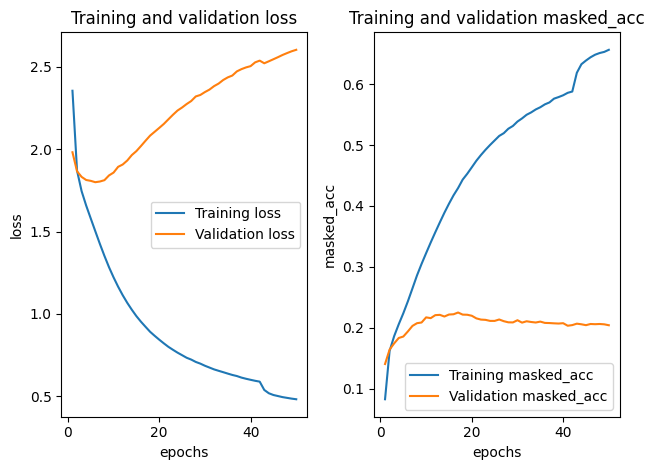

best_epoch is 17
Epoch 1/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 56s 175ms/step - loss: 2.7172 - masked_acc: 0.0514 - learning_rate: 0.0010
Epoch 2/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - loss: 1.9025 - masked_acc: 0.1554 - learning_rate: 0.0010
Epoch 3/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - loss: 1.7619 - masked_acc: 0.1830 - learning_rate: 0.0010
Epoch 4/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.6702 - masked_acc: 0.2039 - learning_rate: 0.0010
Epoch 5/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - loss: 1.5885 - masked_acc: 0.2219 - learning_rate: 0.0010
Epoch 6/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - loss: 1.5082 - masked_acc: 0.2424 - learning_rate: 0.0010
Epoch 7/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - loss: 1.4281 - masked_acc: 0.2670 - learning_rate: 0.0010
Epoch 8/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - loss: 1.3516 - masked_acc: 0.2888 - learning_rate: 0.0010
Epoch 9/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - loss: 

2024-08-09 15:35:22.230937: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.29063407>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2516123>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.25186586>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.07399811>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.061066322>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.062431853>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.237832>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20777126>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.20687224>}
Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 190ms/step - loss: 2.7376 - masked_acc: 0.0581 - val_loss: 1.9799 - val_masked_acc: 0.1411 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 1.9111 - masked_acc: 0.1539 - val_loss: 1.8654 - val_masked_acc: 0.1651 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 1.7688 -

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 57s 176ms/step - loss: 2.7185 - masked_acc: 0.0587 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - loss: 1.9034 - masked_acc: 0.1568 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 174ms/step - loss: 1.7620 - masked_acc: 0.1835 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step - loss: 1.6700 - masked_acc: 0.2035 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.5873 - masked_acc: 0.2214 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - loss: 1.5053 - masked_acc: 0.2438 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - loss: 1.4260 - masked_acc: 0.2658 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.3518 - masked_acc: 0.2876 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - loss: 

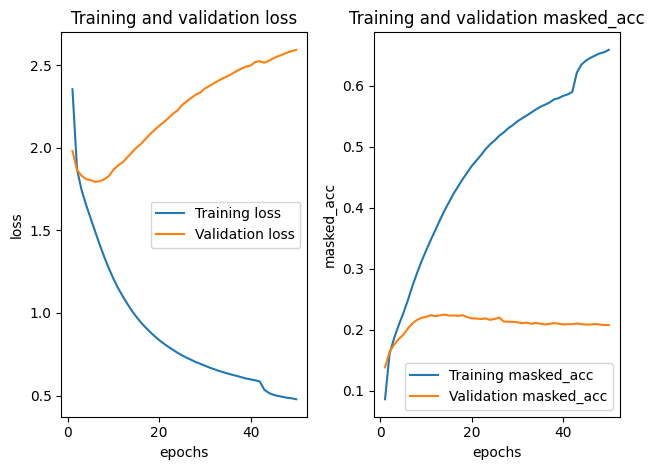

best_epoch is 14
Epoch 1/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 180ms/step - loss: 2.7210 - masked_acc: 0.0579 - learning_rate: 0.0010
Epoch 2/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 1.8993 - masked_acc: 0.1563 - learning_rate: 0.0010
Epoch 3/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.7603 - masked_acc: 0.1852 - learning_rate: 0.0010
Epoch 4/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.6670 - masked_acc: 0.2070 - learning_rate: 0.0010
Epoch 5/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.5816 - masked_acc: 0.2251 - learning_rate: 0.0010
Epoch 6/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.4977 - masked_acc: 0.2479 - learning_rate: 0.0010
Epoch 7/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.4154 - masked_acc: 0.2730 - learning_rate: 0.0010
Epoch 8/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.3393 - masked_acc: 0.2949 - learning_rate: 0.0010
Epoch 9/14
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 

In [25]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.35
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
#LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

for epsilon in [1e-5, 1e-4, 1e-3]:
    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )

    model, filepath, history = build_model(
        train_ds, validation_ds, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=NUM_ENCODERS,
        num_decoders=NUM_DECODERS,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=epsilon,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=USE_RESIDUAL,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )
    plot(history=history)

    optimizer = keras.optimizers.AdamW(
        learning_rate=LEARNING_RATE,
    )
    best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
    best_epoch = best_epoch + 1
    print("best_epoch is", best_epoch)
    model, filepath, history = build_model(
        train_ds.concatenate(validation_ds), None, test_ds,
        vectorization_layer=vectorization_layer,
        num_encoders=NUM_ENCODERS,
        num_decoders=NUM_DECODERS,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        transformer_intermediate_dim=INTERMEDIATE_DIM,
        normalize_first=NORMALIZE_FIRST,
        layer_norm_epsilon=epsilon,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
        use_residual=USE_RESIDUAL,
        vocab_size=VOCABULARY_SIZE,
        batch_size=BATCH_SIZE,
        embedding_dim=EMBEDDING_DIM,
        mask_zero=MASK_ZERO,
        optimizer=optimizer,
        epochs=best_epoch,
        steps_per_epoch=STEPS_PER_EPOCH,
        callbacks=[reduce_lr_callbacks],
    )

    y_true, y_pred = predict_dataset(
        model=model,
        iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH
    )
    rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
        y_true=y_true,
        y_pred=y_pred
    )
    print(rouge_1_score)
    print(rouge_2_score)
    print(rouge_l_score)
    

### Note (Experiment Date: 2024-08-01 00:46:00)

- Compare the various dropout values from 0.1 to 0.5 in this experiment.

#### Result

The result of this experiment is as follows;

DROPOUT | validation loss | validation accuracy | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | --- | --- | ---
0.1 | **1.784** | 0.217 | 23.4 | 5.2 | 19.2
0.15 | **1.784** | 0.217 | 23.0 | 5.3 | 19.0
0.2 | 1.787 | 0.219 | 24.3 | 5.9 | 19.9
0.25 | 1.794 | 0.219 | 25.2 | 6.2 | 20.3
0.3 | 1.790 | 0.223 | 24.4 | 6.0 | 20.0
0.35 | 1.798 | 0.221 | **25.3** | **6.3** | 20.4
0.4 | 1.802 | 0.221 | 24.2 | 5.7 | 19.9
0.45 | 1.806 | 0.220 | 24.7 | 6.2 | 19.9
0.5 | 1.824 | **0.225** | 25.1 | 6.2 | **20.5**

It is slightly complicated to find the relation between the dropout values and each metric.

- It seems that each ROUGE metric correlates to the accuracy slightly rather than the loss.
- I have concluded that the best dropout value is 0.35.

#### Next

- Layer Normalization

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 53s 183ms/step - loss: 2.7306 - masked_acc: 0.0550 - val_loss: 1.9858 - val_masked_acc: 0.1430 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.9135 - masked_acc: 0.1565 - val_loss: 1.8558 - val_masked_acc: 0.1709 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - loss: 1.7552 - masked_acc: 0.1901 - val_loss: 1.8158 - val_masked_acc: 0.1821 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 171ms/step - loss: 1.6418 - masked_acc: 0.2181 - val_loss: 1.7847 - val_masked_acc: 0.1946 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - loss: 1.5339 - masked_acc: 0.2488 - val_loss: 1.7844 - val_masked_acc: 0.2088 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - loss: 1.4232 - masked_acc: 0.2854 - val_loss: 1.7857 - val_masked_acc: 0.2134 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 17

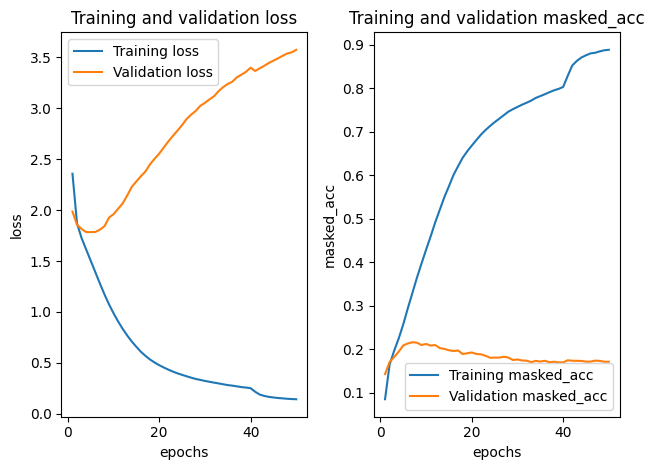

best_epoch is 7
Epoch 1/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 176ms/step - loss: 2.7125 - masked_acc: 0.0536 - learning_rate: 0.0010
Epoch 2/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 1.8980 - masked_acc: 0.1593 - learning_rate: 0.0010
Epoch 3/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 1.7497 - masked_acc: 0.1902 - learning_rate: 0.0010
Epoch 4/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.6405 - masked_acc: 0.2177 - learning_rate: 0.0010
Epoch 5/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.5322 - masked_acc: 0.2484 - learning_rate: 0.0010
Epoch 6/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.4220 - masked_acc: 0.2842 - learning_rate: 0.0010
Epoch 7/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.3110 - masked_acc: 0.3198 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-09_13-01-23.keras
Successfully saved model to model/summarization_model_2024-08-09_13-01-23.keras
{'precision': <tf.Tensor: shape=(), dtype=fl

In [24]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.1
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 52s 180ms/step - loss: 2.7404 - masked_acc: 0.0510 - val_loss: 1.9843 - val_masked_acc: 0.1447 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - loss: 1.9113 - masked_acc: 0.1562 - val_loss: 1.8642 - val_masked_acc: 0.1664 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - loss: 1.7619 - masked_acc: 0.1868 - val_loss: 1.8266 - val_masked_acc: 0.1788 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.6578 - masked_acc: 0.2120 - val_loss: 1.7942 - val_masked_acc: 0.1901 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - loss: 1.5592 - masked_acc: 0.2371 - val_loss: 1.7845 - val_masked_acc: 0.2038 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - loss: 1.4534 - masked_acc: 0.2706 - val_loss: 1.7841 - val_masked_acc: 0.2114 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 17

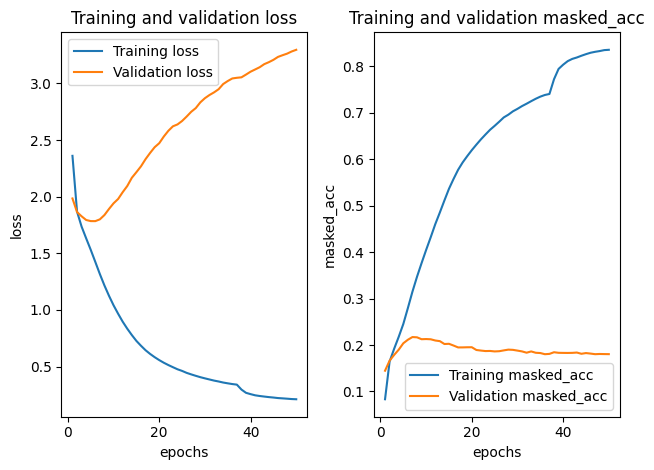

best_epoch is 7
Epoch 1/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 175ms/step - loss: 2.7126 - masked_acc: 0.0545 - learning_rate: 0.0010
Epoch 2/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.9028 - masked_acc: 0.1573 - learning_rate: 0.0010
Epoch 3/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.7503 - masked_acc: 0.1899 - learning_rate: 0.0010
Epoch 4/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.6397 - masked_acc: 0.2181 - learning_rate: 0.0010
Epoch 5/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - loss: 1.5328 - masked_acc: 0.2468 - learning_rate: 0.0010
Epoch 6/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - loss: 1.4253 - masked_acc: 0.2807 - learning_rate: 0.0010
Epoch 7/7
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 159ms/step - loss: 1.3183 - masked_acc: 0.3149 - learning_rate: 0.0010
Saving to model/summarization_model_2024-08-08_22-05-07.keras
Successfully saved model to model/summarization_model_2024-08-08_22-05-07.keras
{'precision': <tf.Tensor: shape=(), dtype=fl

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.15
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 54s 189ms/step - loss: 2.7365 - masked_acc: 0.0511 - val_loss: 1.9889 - val_masked_acc: 0.1406 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - loss: 1.9164 - masked_acc: 0.1544 - val_loss: 1.8657 - val_masked_acc: 0.1681 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 175ms/step - loss: 1.7642 - masked_acc: 0.1857 - val_loss: 1.8272 - val_masked_acc: 0.1785 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - loss: 1.6640 - masked_acc: 0.2091 - val_loss: 1.8072 - val_masked_acc: 0.1850 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - loss: 1.5724 - masked_acc: 0.2318 - val_loss: 1.8017 - val_masked_acc: 0.1975 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - loss: 1.4783 - masked_acc: 0.2598 - val_loss: 1.7873 - val_masked_acc: 0.2120 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 17

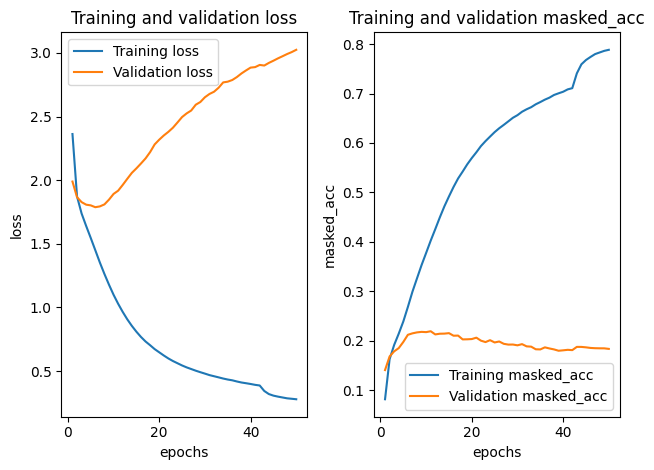

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 57s 180ms/step - loss: 2.7170 - masked_acc: 0.0567 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - loss: 1.9013 - masked_acc: 0.1577 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - loss: 1.7556 - masked_acc: 0.1880 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.6533 - masked_acc: 0.2125 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - loss: 1.5559 - masked_acc: 0.2362 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 1.4576 - masked_acc: 0.2661 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.3608 - masked_acc: 0.2970 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - loss: 1.2679 - masked_acc: 0.3259 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 

2024-08-08 23:02:57.069243: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.2717499>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.24892458>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2428653>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.06841238>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.059491843>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.059407137>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.22102822>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.2053568>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19883147>}


In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.2
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 190ms/step - loss: 2.7401 - masked_acc: 0.0506 - val_loss: 1.9876 - val_masked_acc: 0.1415 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - loss: 1.9162 - masked_acc: 0.1545 - val_loss: 1.8663 - val_masked_acc: 0.1646 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - loss: 1.7680 - masked_acc: 0.1837 - val_loss: 1.8312 - val_masked_acc: 0.1756 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - loss: 1.6726 - masked_acc: 0.2051 - val_loss: 1.8051 - val_masked_acc: 0.1845 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 1.5875 - masked_acc: 0.2254 - val_loss: 1.7976 - val_masked_acc: 0.1905 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 176ms/step - loss: 1.4989 - masked_acc: 0.2482 - val_loss: 1.7941 - val_masked_acc: 0.2047 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 42s 17

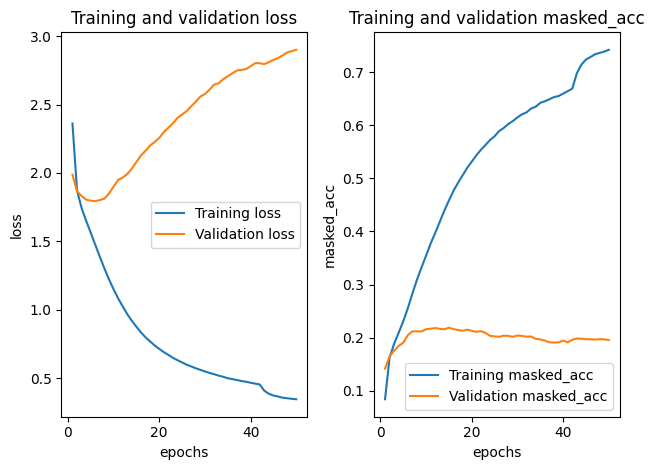

best_epoch is 15
Epoch 1/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 60s 192ms/step - loss: 2.7160 - masked_acc: 0.0532 - learning_rate: 0.0010
Epoch 2/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - loss: 1.9055 - masked_acc: 0.1566 - learning_rate: 0.0010
Epoch 3/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - loss: 1.7586 - masked_acc: 0.1861 - learning_rate: 0.0010
Epoch 4/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.6584 - masked_acc: 0.2099 - learning_rate: 0.0010
Epoch 5/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 43s 176ms/step - loss: 1.5648 - masked_acc: 0.2337 - learning_rate: 0.0010
Epoch 6/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 168ms/step - loss: 1.4728 - masked_acc: 0.2608 - learning_rate: 0.0010
Epoch 7/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 171ms/step - loss: 1.3809 - masked_acc: 0.2888 - learning_rate: 0.0010
Epoch 8/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - loss: 1.2948 - masked_acc: 0.3142 - learning_rate: 0.0010
Epoch 9/15
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.25
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 57s 190ms/step - loss: 2.7392 - masked_acc: 0.0506 - val_loss: 1.9823 - val_masked_acc: 0.1435 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - loss: 1.9130 - masked_acc: 0.1551 - val_loss: 1.8662 - val_masked_acc: 0.1635 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 1.7681 - masked_acc: 0.1839 - val_loss: 1.8290 - val_masked_acc: 0.1741 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 1.6742 - masked_acc: 0.2044 - val_loss: 1.8088 - val_masked_acc: 0.1836 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.5937 - masked_acc: 0.2226 - val_loss: 1.8039 - val_masked_acc: 0.1899 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - loss: 1.5099 - masked_acc: 0.2443 - val_loss: 1.7903 - val_masked_acc: 0.2026 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 17

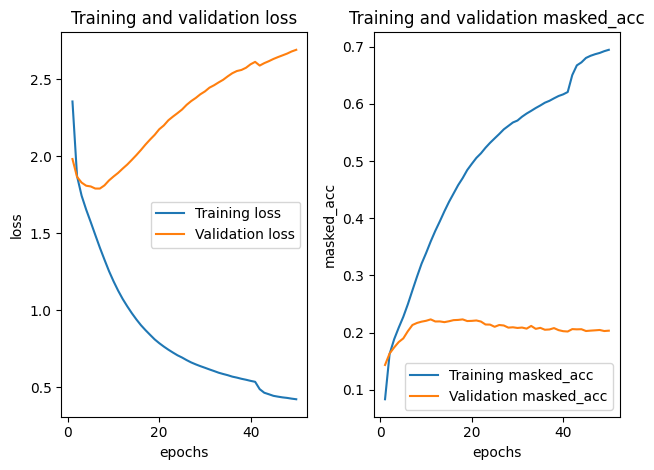

best_epoch is 11
Epoch 1/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 58s 182ms/step - loss: 2.7176 - masked_acc: 0.0593 - learning_rate: 0.0010
Epoch 2/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 1.9051 - masked_acc: 0.1556 - learning_rate: 0.0010
Epoch 3/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - loss: 1.7612 - masked_acc: 0.1842 - learning_rate: 0.0010
Epoch 4/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.6670 - masked_acc: 0.2055 - learning_rate: 0.0010
Epoch 5/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - loss: 1.5790 - masked_acc: 0.2267 - learning_rate: 0.0010
Epoch 6/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.4914 - masked_acc: 0.2506 - learning_rate: 0.0010
Epoch 7/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.4060 - masked_acc: 0.2774 - learning_rate: 0.0010
Epoch 8/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.3255 - masked_acc: 0.3004 - learning_rate: 0.0010
Epoch 9/11
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.3
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 60s 203ms/step - loss: 2.7370 - masked_acc: 0.0551 - val_loss: 1.9815 - val_masked_acc: 0.1416 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - loss: 1.9132 - masked_acc: 0.1533 - val_loss: 1.8677 - val_masked_acc: 0.1637 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 174ms/step - loss: 1.7697 - masked_acc: 0.1821 - val_loss: 1.8328 - val_masked_acc: 0.1765 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - loss: 1.6769 - masked_acc: 0.2022 - val_loss: 1.8128 - val_masked_acc: 0.1835 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - loss: 1.5955 - masked_acc: 0.2211 - val_loss: 1.8017 - val_masked_acc: 0.1892 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 173ms/step - loss: 1.5154 - masked_acc: 0.2408 - val_loss: 1.7977 - val_masked_acc: 0.2004 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 17

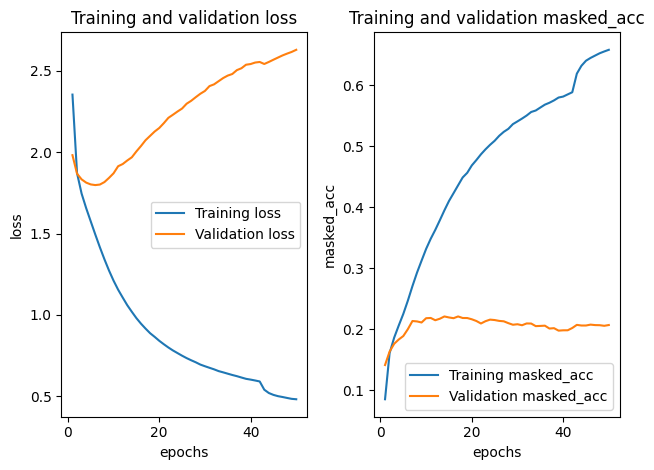

best_epoch is 17
Epoch 1/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 185ms/step - loss: 2.7179 - masked_acc: 0.0536 - learning_rate: 0.0010
Epoch 2/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 166ms/step - loss: 1.9028 - masked_acc: 0.1557 - learning_rate: 0.0010
Epoch 3/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 1.7628 - masked_acc: 0.1832 - learning_rate: 0.0010
Epoch 4/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 1.6698 - masked_acc: 0.2028 - learning_rate: 0.0010
Epoch 5/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 1.5854 - masked_acc: 0.2219 - learning_rate: 0.0010
Epoch 6/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 169ms/step - loss: 1.5029 - masked_acc: 0.2446 - learning_rate: 0.0010
Epoch 7/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 172ms/step - loss: 1.4238 - masked_acc: 0.2668 - learning_rate: 0.0010
Epoch 8/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 41s 167ms/step - loss: 1.3499 - masked_acc: 0.2873 - learning_rate: 0.0010
Epoch 9/17
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.35
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 61s 203ms/step - loss: 2.7346 - masked_acc: 0.0578 - val_loss: 1.9786 - val_masked_acc: 0.1381 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 177ms/step - loss: 1.9109 - masked_acc: 0.1533 - val_loss: 1.8687 - val_masked_acc: 0.1644 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - loss: 1.7726 - masked_acc: 0.1806 - val_loss: 1.8353 - val_masked_acc: 0.1734 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - loss: 1.6843 - masked_acc: 0.1985 - val_loss: 1.8223 - val_masked_acc: 0.1778 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.6081 - masked_acc: 0.2151 - val_loss: 1.8118 - val_masked_acc: 0.1835 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.5339 - masked_acc: 0.2317 - val_loss: 1.8023 - val_masked_acc: 0.1962 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 16

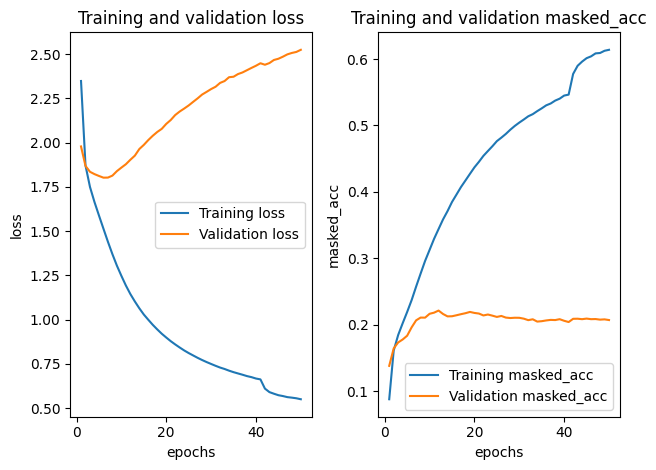

best_epoch is 12
Epoch 1/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 182ms/step - loss: 2.7212 - masked_acc: 0.0593 - learning_rate: 0.0010
Epoch 2/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.8996 - masked_acc: 0.1560 - learning_rate: 0.0010
Epoch 3/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.7639 - masked_acc: 0.1826 - learning_rate: 0.0010
Epoch 4/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.6728 - masked_acc: 0.2029 - learning_rate: 0.0010
Epoch 5/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.5935 - masked_acc: 0.2199 - learning_rate: 0.0010
Epoch 6/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.5174 - masked_acc: 0.2382 - learning_rate: 0.0010
Epoch 7/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.4426 - masked_acc: 0.2596 - learning_rate: 0.0010
Epoch 8/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.3719 - masked_acc: 0.2804 - learning_rate: 0.0010
Epoch 9/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 

2024-08-09 02:19:51.950312: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.27757913>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.24236675>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.24173343>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.067267045>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.057034146>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.057360657>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.22643337>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20089994>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.19872801>}


In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.4
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 61s 197ms/step - loss: 2.7401 - masked_acc: 0.0552 - val_loss: 1.9812 - val_masked_acc: 0.1385 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step - loss: 1.9132 - masked_acc: 0.1531 - val_loss: 1.8672 - val_masked_acc: 0.1652 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - loss: 1.7727 - masked_acc: 0.1801 - val_loss: 1.8371 - val_masked_acc: 0.1700 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - loss: 1.6859 - masked_acc: 0.1975 - val_loss: 1.8220 - val_masked_acc: 0.1729 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 166ms/step - loss: 1.6143 - masked_acc: 0.2121 - val_loss: 1.8200 - val_masked_acc: 0.1818 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.5442 - masked_acc: 0.2263 - val_loss: 1.8085 - val_masked_acc: 0.1911 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 16

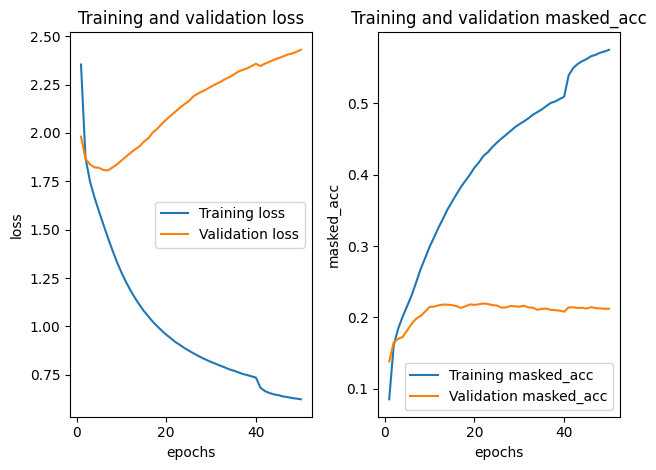

best_epoch is 22
Epoch 1/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 59s 183ms/step - loss: 2.7226 - masked_acc: 0.0512 - learning_rate: 0.0010
Epoch 2/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 1.9009 - masked_acc: 0.1550 - learning_rate: 0.0010
Epoch 3/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - loss: 1.7651 - masked_acc: 0.1815 - learning_rate: 0.0010
Epoch 4/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 163ms/step - loss: 1.6786 - masked_acc: 0.1994 - learning_rate: 0.0010
Epoch 5/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - loss: 1.6039 - masked_acc: 0.2150 - learning_rate: 0.0010
Epoch 6/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 165ms/step - loss: 1.5333 - masked_acc: 0.2305 - learning_rate: 0.0010
Epoch 7/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - loss: 1.4645 - masked_acc: 0.2492 - learning_rate: 0.0010
Epoch 8/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 164ms/step - loss: 1.3992 - masked_acc: 0.2668 - learning_rate: 0.0010
Epoch 9/22
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 

In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.45
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50


2024-08-09 10:06:13.521535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 51s 181ms/step - loss: 2.7407 - masked_acc: 0.0560 - val_loss: 1.9783 - val_masked_acc: 0.1427 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - loss: 1.9094 - masked_acc: 0.1540 - val_loss: 1.8717 - val_masked_acc: 0.1629 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.7734 - masked_acc: 0.1794 - val_loss: 1.8450 - val_masked_acc: 0.1685 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - loss: 1.6911 - masked_acc: 0.1941 - val_loss: 1.8307 - val_masked_acc: 0.1732 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 169ms/step - loss: 1.6237 - masked_acc: 0.2076 - val_loss: 1.8276 - val_masked_acc: 0.1774 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - loss: 1.5598 - masked_acc: 0.2194 - val_loss: 1.8238 - val_masked_acc: 0.1817 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 38s 163ms/step - 

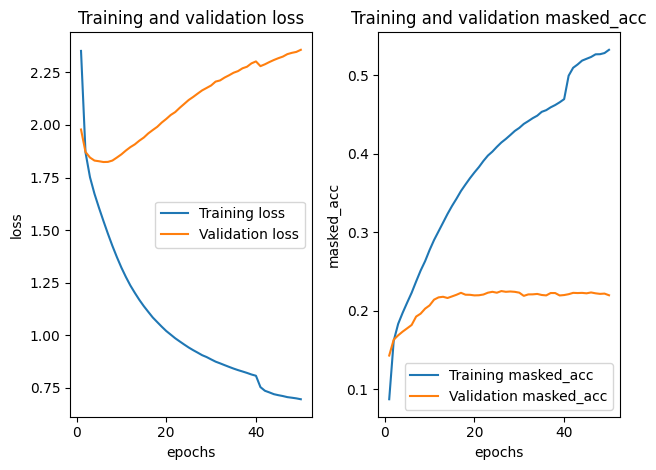

best_epoch is 26
Epoch 1/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 50s 168ms/step - loss: 2.7270 - masked_acc: 0.0598 - learning_rate: 0.0010
Epoch 2/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.8987 - masked_acc: 0.1564 - learning_rate: 0.0010
Epoch 3/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.7653 - masked_acc: 0.1809 - learning_rate: 0.0010
Epoch 4/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.6822 - masked_acc: 0.1974 - learning_rate: 0.0010
Epoch 5/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.6128 - masked_acc: 0.2106 - learning_rate: 0.0010
Epoch 6/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 160ms/step - loss: 1.5467 - masked_acc: 0.2245 - learning_rate: 0.0010
Epoch 7/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.4843 - masked_acc: 0.2397 - learning_rate: 0.0010
Epoch 8/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 1.4259 - masked_acc: 0.2533 - learning_rate: 0.0010
Epoch 9/26
243/243 ━━━━━━━━━━━━━━━━━━━━ 39s 161ms/step - loss: 

2024-08-09 11:47:27.528619: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.29155937>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.24943013>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2514904>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.073295414>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.060863785>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.062196232>}
{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.23704366>, 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.20523643>, 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.2054139>}


In [ ]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
DROPOUT=0.5
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)
best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_masked_acc"]))
best_epoch = best_epoch + 1
print("best_epoch is", best_epoch)
model, filepath, history = build_model(
    train_ds.concatenate(validation_ds), None, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=best_epoch,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

### Note (Experiment Date: 2024-07-30 13:23:00)

Compare that Rouge N score.

#### Result

- The decoder sequence length should be 64 because 32 is not sufficient for the 25% dataset. Otherwise the loss value increases unexpectedly.
- The encoder sequence lengths between 128 and 256 do not almost make a difference. It is supposed that the first half of input sequences contains the essence for summarization.
- The 4-layer model did not converge. It would require 100 or 150 epochs.
- The Rouge score slightly decreased compared to the 256 x 64 model. It is supposed that the reduction worked like dropout.

#### Next

- Dropout and normalization, because the current model is clearly overfitting.

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 57s 194ms/step - loss: 2.7372 - masked_acc: 0.0458 - val_loss: 2.0245 - val_masked_acc: 0.1326 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - loss: 1.9469 - masked_acc: 0.1480 - val_loss: 1.8771 - val_masked_acc: 0.1650 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 179ms/step - loss: 1.7806 - masked_acc: 0.1834 - val_loss: 1.8303 - val_masked_acc: 0.1762 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 175ms/step - loss: 1.6734 - masked_acc: 0.2098 - val_loss: 1.8120 - val_masked_acc: 0.1789 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - loss: 1.5751 - masked_acc: 0.2345 - val_loss: 1.7908 - val_masked_acc: 0.1974 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - loss: 1.4745 - masked_acc: 0.2663 - val_loss: 1.8057 - val_masked_acc: 0.1986 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 46s 20

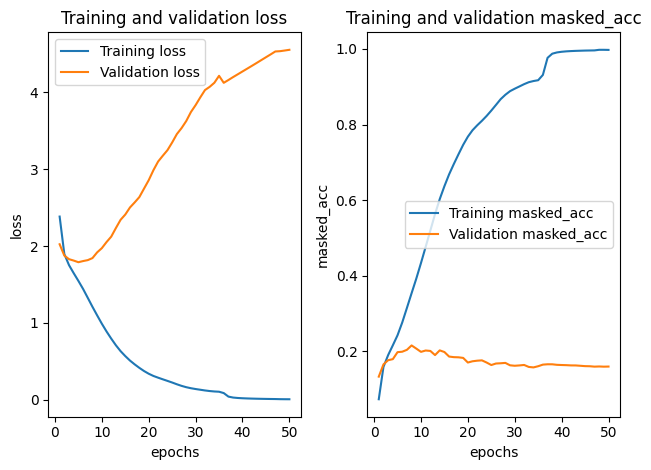

1.7908070087432861 The best number of epocs for the validation loss is 5
0.21521946787834167 The best number of epocs for the validation accuracy is 8


2024-07-31 18:53:40.506105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.043824036>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.044620942>,
 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.04095744>}

In [25]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 # 32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 49s 140ms/step - loss: 5.0231 - masked_acc: 0.0492 - val_loss: 3.6718 - val_masked_acc: 0.1427 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - loss: 3.5255 - masked_acc: 0.1585 - val_loss: 3.4237 - val_masked_acc: 0.1699 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 34s 147ms/step - loss: 3.2234 - masked_acc: 0.1935 - val_loss: 3.3414 - val_masked_acc: 0.1864 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 151ms/step - loss: 3.0084 - masked_acc: 0.2243 - val_loss: 3.2891 - val_masked_acc: 0.1971 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 125ms/step - loss: 2.7979 - masked_acc: 0.2602 - val_loss: 3.3186 - val_masked_acc: 0.2111 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 118ms/step - loss: 2.5734 - masked_acc: 0.3015 - val_loss: 3.3056 - val_masked_acc: 0.2206 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 11

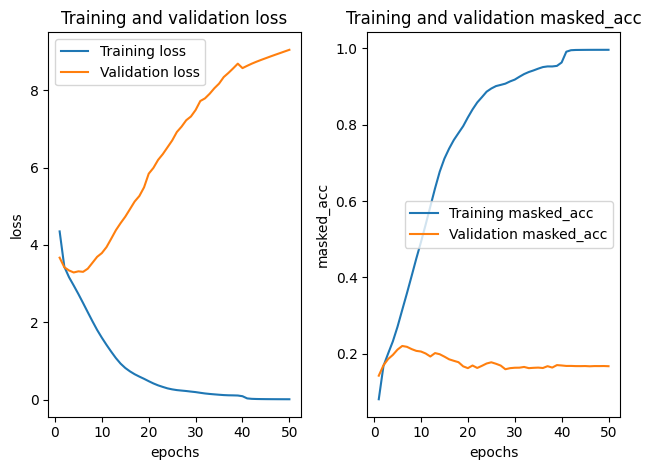

3.2891147136688232 The best number of epocs for the validation loss is 4
0.2205798327922821 The best number of epocs for the validation accuracy is 6


2024-07-31 18:08:38.901577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.04060659>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.038758624>,
 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.036938474>}

In [24]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 #  32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)

Epoch 1/50


2024-07-30 23:28:17.112466: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 206ms/step - loss: 2.7384 - masked_acc: 0.0510 - val_loss: 2.0059 - val_masked_acc: 0.1375 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - loss: 1.9333 - masked_acc: 0.1518 - val_loss: 1.8759 - val_masked_acc: 0.1666 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 46s 198ms/step - loss: 1.7786 - masked_acc: 0.1835 - val_loss: 1.8306 - val_masked_acc: 0.1767 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - loss: 1.6731 - masked_acc: 0.2089 - val_loss: 1.8075 - val_masked_acc: 0.1849 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 45s 194ms/step - loss: 1.5737 - masked_acc: 0.2358 - val_loss: 1.7807 - val_masked_acc: 0.1983 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 46s 199ms/step - loss: 1.4672 - masked_acc: 0.2695 - val_loss: 1.7918 - val_masked_acc: 0.2092 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 46s 198ms/step - 

1.7807334661483765 The best number of epocs for the validation loss is 5
0.21532534062862396 The best number of epocs for the validation accuracy is 7


2024-07-31 00:12:44.746559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.042120945>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.042302344>,
 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.039022304>}

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 157s 510ms/step - loss: 2.7185 - masked_acc: 0.0544 - val_loss: 2.0104 - val_masked_acc: 0.1385 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 105s 446ms/step - loss: 1.9411 - masked_acc: 0.1484 - val_loss: 1.8816 - val_masked_acc: 0.1645 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 109s 471ms/step - loss: 1.7979 - masked_acc: 0.1798 - val_loss: 1.8397 - val_masked_acc: 0.1748 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 103s 445ms/step - loss: 1.7087 - masked_acc: 0.2018 - val_loss: 1.8259 - val_masked_acc: 0.1800 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 105s 454ms/step - loss: 1.6370 - masked_acc: 0.2194 - val_loss: 1.8251 - val_masked_acc: 0.1810 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 101s 438ms/step - loss: 1.5763 - masked_acc: 0.2320 - val_loss: 1.8269 - val_masked_acc: 0.1820 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 

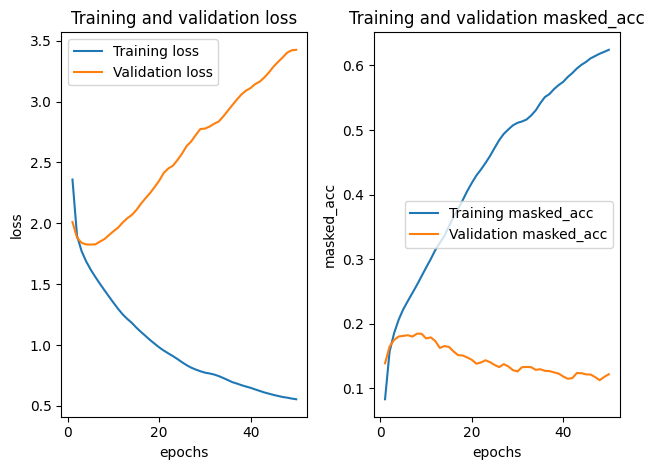

1.8251491785049438 The best number of epocs for the validation loss is 5
0.18445561826229095 The best number of epocs for the validation accuracy is 8


2024-07-31 01:58:32.657497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.0014826444>,
 'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.001006278>,
 'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.0011288851>}

In [23]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 256 # 128: 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 64 #  32: 75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 4
NUM_DECODERS = 4
NUM_HEADS = 12
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

y_true, y_pred = predict_dataset(
    model=model,
    iterable_dataset=tfds.as_numpy(test_ds), # The length of the test dataset is 819.
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH
)
rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)
print(rouge_1_score)
print(rouge_2_score)
print(rouge_l_score)


***
### Note (Experiment Date: 2024-07-16 00:35:37)

Multiple layers 6, 4, and 2.

#### Result

It is preferable that the number of layers is more than or equal to 4.

#### Next

Compare that Rouge N score.

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 215s 481ms/step - loss: 4.3887 - masked_acc: 0.0816 - val_loss: 3.4090 - val_masked_acc: 0.1724 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 77s 328ms/step - loss: 3.2072 - masked_acc: 0.1938 - val_loss: 3.1998 - val_masked_acc: 0.2185 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 322ms/step - loss: 2.7499 - masked_acc: 0.2614 - val_loss: 3.1550 - val_masked_acc: 0.2377 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 321ms/step - loss: 2.3535 - masked_acc: 0.3178 - val_loss: 3.2483 - val_masked_acc: 0.2223 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 76s 327ms/step - loss: 2.0171 - masked_acc: 0.3734 - val_loss: 3.4084 - val_masked_acc: 0.2226 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 77s 330ms/step - loss: 1.7194 - masked_acc: 0.4320 - val_loss: 3.6067 - val_masked_acc: 0.2184 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 75s 3

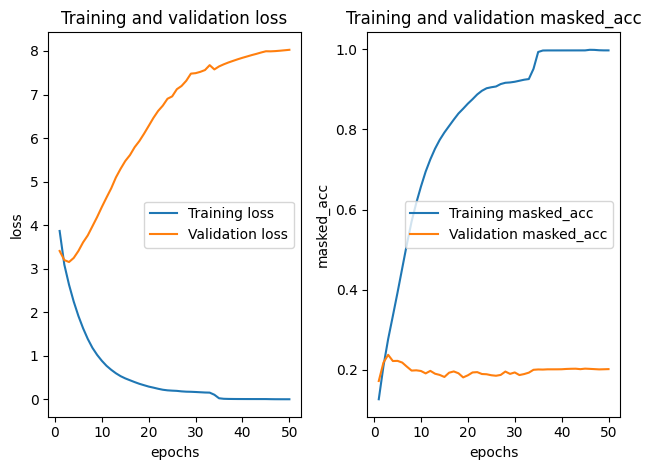

3.15500807762146 The best number of epocs for the validation loss is 3
0.23772819340229034 The best number of epocs for the validation accuracy is 3


In [24]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 6
NUM_DECODERS = 6
NUM_HEADS = 8
INTERMEDIATE_DIM = 512
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50


2024-07-16 00:35:37.734525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 110s 289ms/step - loss: 4.4522 - masked_acc: 0.0736 - val_loss: 3.4322 - val_masked_acc: 0.1685 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - loss: 3.2615 - masked_acc: 0.1856 - val_loss: 3.2552 - val_masked_acc: 0.2000 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 235ms/step - loss: 2.8630 - masked_acc: 0.2432 - val_loss: 3.1674 - val_masked_acc: 0.2295 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 238ms/step - loss: 2.4651 - masked_acc: 0.3058 - val_loss: 3.2344 - val_masked_acc: 0.2261 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 241ms/step - loss: 2.1244 - masked_acc: 0.3597 - val_loss: 3.3526 - val_masked_acc: 0.2318 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 56s 243ms/step - loss: 1.8256 - masked_acc: 0.4127 - val_loss: 3.5172 - val_masked_acc: 0.2240 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 55s 236ms/step -

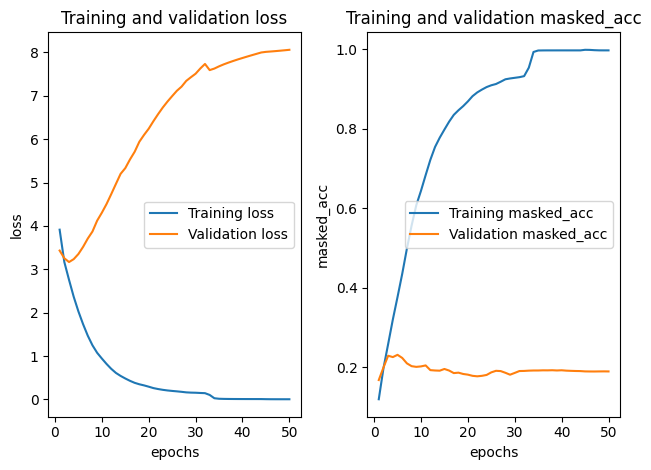

3.1674225330352783 The best number of epocs for the validation loss is 3
0.23181374371051788 The best number of epocs for the validation accuracy is 5


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 4
NUM_DECODERS = 4
NUM_HEADS = 8
INTERMEDIATE_DIM = 512
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 66s 189ms/step - loss: 4.6995 - masked_acc: 0.0587 - val_loss: 3.5060 - val_masked_acc: 0.1632 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 151ms/step - loss: 3.3609 - masked_acc: 0.1746 - val_loss: 3.3473 - val_masked_acc: 0.1805 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 153ms/step - loss: 3.0657 - masked_acc: 0.2122 - val_loss: 3.2566 - val_masked_acc: 0.2009 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 36s 152ms/step - loss: 2.7717 - masked_acc: 0.2589 - val_loss: 3.2188 - val_masked_acc: 0.2220 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 35s 150ms/step - loss: 2.4588 - masked_acc: 0.3144 - val_loss: 3.2710 - val_masked_acc: 0.2295 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 34s 146ms/step - loss: 2.1610 - masked_acc: 0.3648 - val_loss: 3.3757 - val_masked_acc: 0.2285 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 34s 14

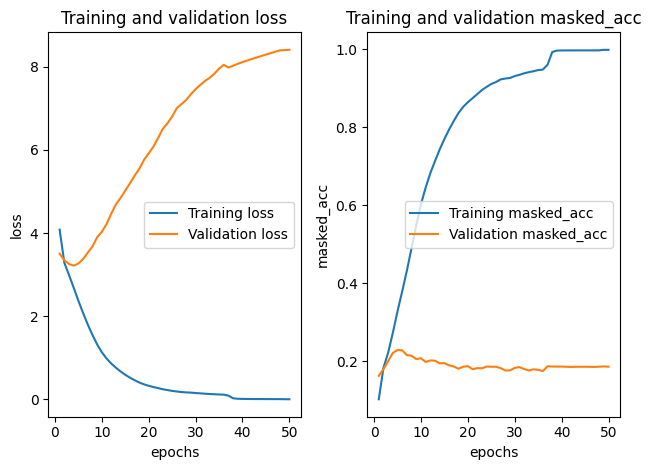

3.2187960147857666 The best number of epocs for the validation loss is 4
0.22946351766586304 The best number of epocs for the validation accuracy is 5


In [23]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 2
NUM_DECODERS = 2
NUM_HEADS = 8
INTERMEDIATE_DIM = 512
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = True

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-15 02:00:00)

Identify the best intermediate dimension from 256, 512, 1024.

#### Result

#### Next

Epoch 1/50


2024-07-15 02:03:37.544353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - loss: 5.0289 - masked_acc: 0.0452 - val_loss: 3.6850 - val_masked_acc: 0.1425 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step - loss: 3.5373 - masked_acc: 0.1574 - val_loss: 3.4296 - val_masked_acc: 0.1710 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 28s 119ms/step - loss: 3.2375 - masked_acc: 0.1927 - val_loss: 3.3441 - val_masked_acc: 0.1849 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 3.0221 - masked_acc: 0.2240 - val_loss: 3.2927 - val_masked_acc: 0.1980 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - loss: 2.8122 - masked_acc: 0.2560 - val_loss: 3.2996 - val_masked_acc: 0.2109 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 2.5916 - masked_acc: 0.2950 - val_loss: 3.2954 - val_masked_acc: 0.2132 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - 

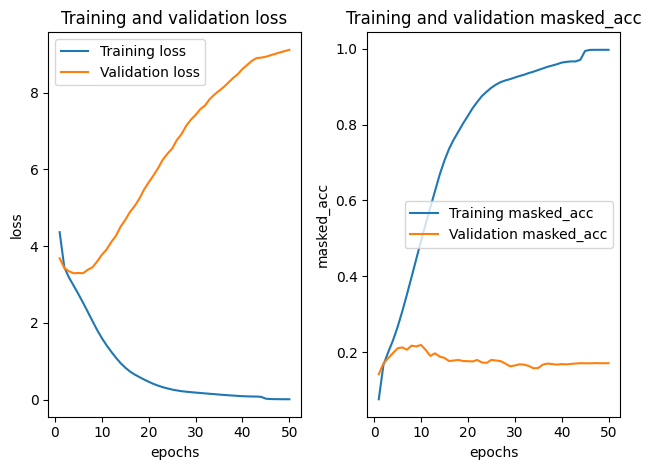

3.292686939239502 The best number of epocs for the validation loss is 4
0.2198389619588852 The best number of epocs for the validation accuracy is 10


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 36s 118ms/step - loss: 5.0307 - masked_acc: 0.0428 - val_loss: 3.6869 - val_masked_acc: 0.1435 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - loss: 3.5360 - masked_acc: 0.1578 - val_loss: 3.4251 - val_masked_acc: 0.1702 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - loss: 3.2289 - masked_acc: 0.1931 - val_loss: 3.3410 - val_masked_acc: 0.1842 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 3.0129 - masked_acc: 0.2241 - val_loss: 3.2865 - val_masked_acc: 0.1962 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - loss: 2.8034 - masked_acc: 0.2561 - val_loss: 3.3252 - val_masked_acc: 0.2058 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - loss: 2.5771 - masked_acc: 0.2984 - val_loss: 3.3060 - val_masked_acc: 0.2151 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 10

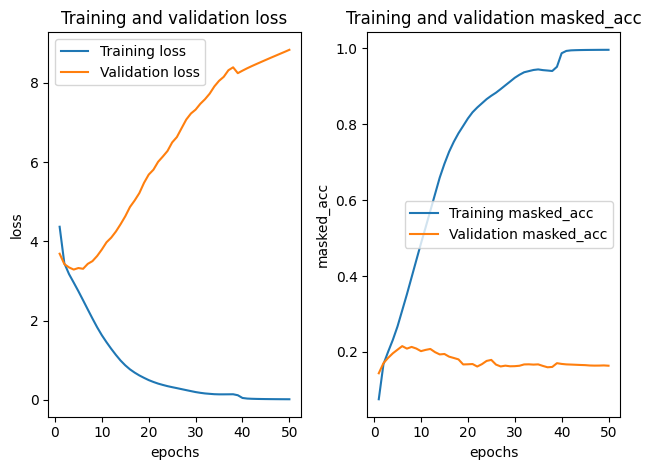

3.2864797115325928 The best number of epocs for the validation loss is 4
0.21513327956199646 The best number of epocs for the validation accuracy is 6


In [23]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 512
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step - loss: 5.0372 - masked_acc: 0.0530 - val_loss: 3.7030 - val_masked_acc: 0.1381 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - loss: 3.5459 - masked_acc: 0.1564 - val_loss: 3.4236 - val_masked_acc: 0.1716 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 105ms/step - loss: 3.2251 - masked_acc: 0.1951 - val_loss: 3.3378 - val_masked_acc: 0.1874 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 113ms/step - loss: 3.0066 - masked_acc: 0.2263 - val_loss: 3.3004 - val_masked_acc: 0.1963 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - loss: 2.7966 - masked_acc: 0.2590 - val_loss: 3.3043 - val_masked_acc: 0.2114 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 112ms/step - loss: 2.5700 - masked_acc: 0.3003 - val_loss: 3.3103 - val_masked_acc: 0.2147 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 10

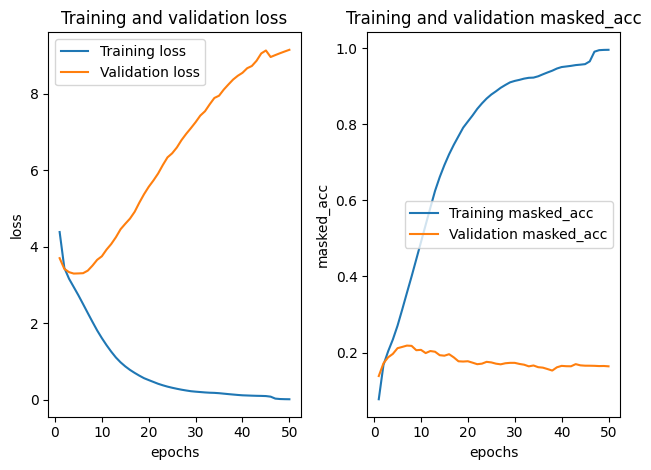

3.3004415035247803 The best number of epocs for the validation loss is 4
0.21818313002586365 The best number of epocs for the validation accuracy is 7


In [24]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 256
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 40s 122ms/step - loss: 5.0287 - masked_acc: 0.0497 - val_loss: 3.7087 - val_masked_acc: 0.1416 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - loss: 3.5540 - masked_acc: 0.1567 - val_loss: 3.4234 - val_masked_acc: 0.1715 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 29s 124ms/step - loss: 3.2280 - masked_acc: 0.1931 - val_loss: 3.3389 - val_masked_acc: 0.1862 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 110ms/step - loss: 3.0024 - masked_acc: 0.2265 - val_loss: 3.2828 - val_masked_acc: 0.2002 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 2.7775 - masked_acc: 0.2639 - val_loss: 3.3123 - val_masked_acc: 0.2074 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step - loss: 2.5453 - masked_acc: 0.3043 - val_loss: 3.3163 - val_masked_acc: 0.2123 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 10

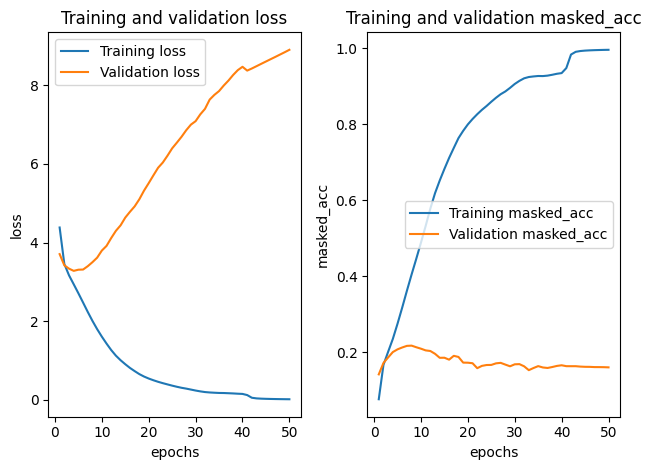

3.282804489135742 The best number of epocs for the validation loss is 4
0.21716365218162537 The best number of epocs for the validation accuracy is 8


In [25]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 128
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 43s 139ms/step - loss: 5.0363 - masked_acc: 0.0381 - val_loss: 3.6993 - val_masked_acc: 0.1420 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 30s 129ms/step - loss: 3.5410 - masked_acc: 0.1580 - val_loss: 3.4226 - val_masked_acc: 0.1718 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - loss: 3.2249 - masked_acc: 0.1929 - val_loss: 3.3513 - val_masked_acc: 0.1851 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 106ms/step - loss: 3.0084 - masked_acc: 0.2223 - val_loss: 3.3076 - val_masked_acc: 0.1997 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 106ms/step - loss: 2.7889 - masked_acc: 0.2608 - val_loss: 3.2947 - val_masked_acc: 0.2137 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 25s 108ms/step - loss: 2.5514 - masked_acc: 0.3044 - val_loss: 3.3258 - val_masked_acc: 0.2128 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 24s 10

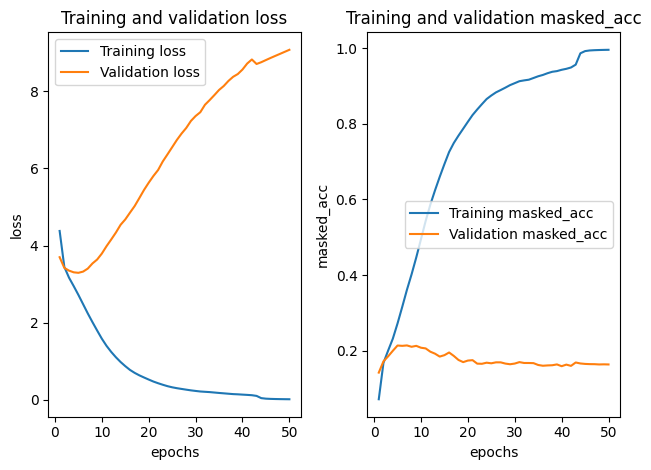

3.294699192047119 The best number of epocs for the validation loss is 5
0.21388421952724457 The best number of epocs for the validation accuracy is 7


In [26]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 64
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-13 15:15:00)

The batch size 64.

#### Result

#### Next

Epoch 1/50


2024-07-13 17:16:17.311635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


231/231 ━━━━━━━━━━━━━━━━━━━━ 30s 91ms/step - loss: 4.7332 - masked_acc: 0.0605 - val_loss: 3.4717 - val_masked_acc: 0.1505 - learning_rate: 0.0010
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 3.4232 - masked_acc: 0.1655 - val_loss: 3.2560 - val_masked_acc: 0.1749 - learning_rate: 0.0010
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 18s 77ms/step - loss: 3.1670 - masked_acc: 0.1937 - val_loss: 3.1644 - val_masked_acc: 0.1870 - learning_rate: 0.0010
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 18s 78ms/step - loss: 2.9782 - masked_acc: 0.2200 - val_loss: 3.1016 - val_masked_acc: 0.1998 - learning_rate: 0.0010
Epoch 5/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 19s 81ms/step - loss: 2.7903 - masked_acc: 0.2474 - val_loss: 3.0657 - val_masked_acc: 0.2136 - learning_rate: 0.0010
Epoch 6/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 75ms/step - loss: 2.5962 - masked_acc: 0.2801 - val_loss: 3.0581 - val_masked_acc: 0.2200 - learning_rate: 0.0010
Epoch 7/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 17s 74ms/step - loss: 2

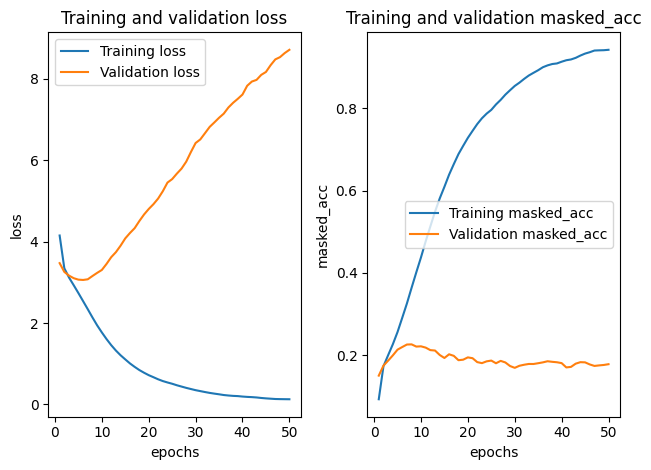

3.05808687210083 The best number of epocs for the validation loss is 6
0.22648921608924866 The best number of epocs for the validation accuracy is 8


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 64
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

### Note (Experiment Date: 2024-07-13 15:15:00)

#### Result

#### Next

The batch size should be smaller to 64.

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 265ms/step - loss: 5.5057 - masked_acc: 0.0370 - val_loss: 4.1270 - val_masked_acc: 0.0714 - learning_rate: 0.0010
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 213ms/step - loss: 4.0685 - masked_acc: 0.0963 - val_loss: 3.6933 - val_masked_acc: 0.1275 - learning_rate: 0.0010
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - loss: 3.6463 - masked_acc: 0.1387 - val_loss: 3.4229 - val_masked_acc: 0.1554 - learning_rate: 0.0010
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 222ms/step - loss: 3.3724 - masked_acc: 0.1726 - val_loss: 3.3078 - val_masked_acc: 0.1689 - learning_rate: 0.0010
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 218ms/step - loss: 3.2203 - masked_acc: 0.1902 - val_loss: 3.2502 - val_masked_acc: 0.1766 - learning_rate: 0.0010
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - loss: 3.1075 - masked_acc: 0.2035 - val_loss: 3.2278 - val_masked_acc: 0.1804 - learning_rate: 0.0010
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 13s 229ms/step - los

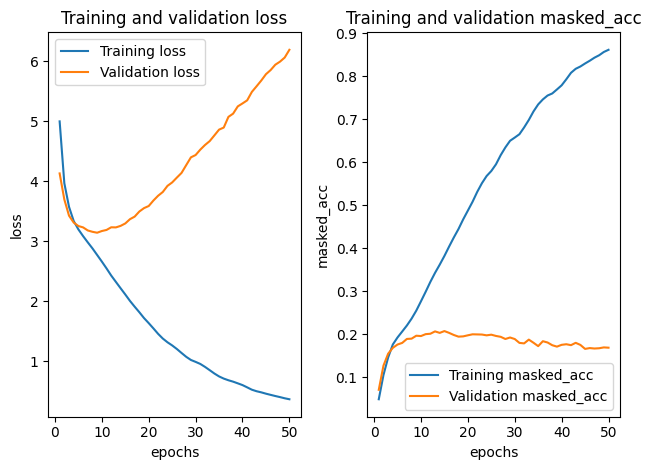

3.1388354301452637 The best number of epocs for the validation loss is 9
0.20788699388504028 The best number of epocs for the validation accuracy is 15


In [23]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 256
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

In [27]:
def evaluate(train_ds, validation_ds, test_ds):
    train_ds, validation_ds, test_ds = build_datasets(
        train_ds=train_ds,
        validation_ds=validation_ds,
        test_ds=test_ds,
        vectorization_layer=vectorization_layer,
        batch_size=BATCH_SIZE,
        encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
        decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    )
    model.evaluate(test_ds)

evaluate(
    train_ds=train_ds,
    validation_ds=validation_ds,
    test_ds=test_ds,
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - loss: 6.3018 - masked_acc: 0.1572


### Note (Experiment Date: 2024-07-13 15:00:53)

First training.

#### Result

Fast. But, overfitting.

#### Next

The batch size to 256.

Epoch 1/50


2024-07-13 15:00:53.622382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


116/116 ━━━━━━━━━━━━━━━━━━━━ 24s 133ms/step - loss: 5.1045 - masked_acc: 0.0465 - val_loss: 3.8141 - val_masked_acc: 0.1149 - learning_rate: 0.0010
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 3.7117 - masked_acc: 0.1346 - val_loss: 3.3768 - val_masked_acc: 0.1654 - learning_rate: 0.0010
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 3.3258 - masked_acc: 0.1774 - val_loss: 3.2523 - val_masked_acc: 0.1744 - learning_rate: 0.0010
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 110ms/step - loss: 3.1508 - masked_acc: 0.1968 - val_loss: 3.1817 - val_masked_acc: 0.1827 - learning_rate: 0.0010
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 3.0032 - masked_acc: 0.2162 - val_loss: 3.1380 - val_masked_acc: 0.1914 - learning_rate: 0.0010
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 111ms/step - loss: 2.8589 - masked_acc: 0.2391 - val_loss: 3.1439 - val_masked_acc: 0.2004 - learning_rate: 0.0010
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - 

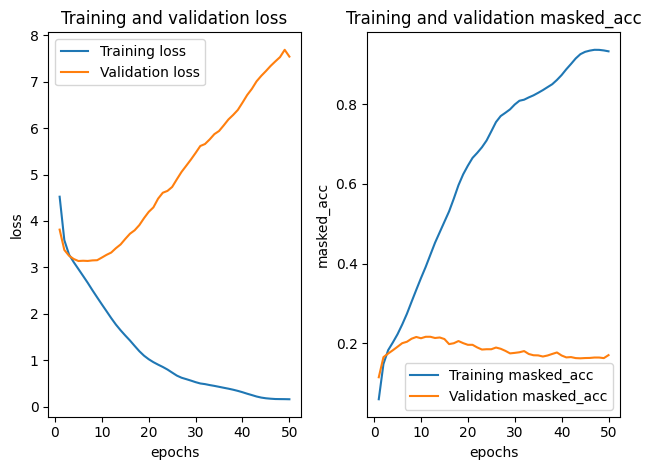

3.138007879257202 The best number of epocs for the validation loss is 5
0.2164759784936905 The best number of epocs for the validation accuracy is 12


In [22]:
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
STEPS_PER_EPOCH = None
ENCODER_SEQUENCE_LENGTH = 128 # 75% covered. max is 803.
DECODER_SEQUENCE_LENGTH = 32 #  75% covered. max is 64
BATCH_SIZE = 128
NUM_ENCODERS = 1
NUM_DECODERS = 1
NUM_HEADS = 8
INTERMEDIATE_DIM = 1024
NORMALIZE_FIRST = False
LAYER_NORM_EPSILON = 1e-5
EMBEDDING_DIM = 64
MASK_ZERO = False
USE_RESIDUAL = False

optimizer = keras.optimizers.AdamW(
    learning_rate=LEARNING_RATE,
)

model, filepath, history = build_model(
    train_ds, validation_ds, test_ds,
    vectorization_layer=vectorization_layer,
    num_encoders=NUM_ENCODERS,
    num_decoders=NUM_DECODERS,
    num_heads=NUM_HEADS,
    dropout=0,
    transformer_intermediate_dim=INTERMEDIATE_DIM,
    normalize_first=NORMALIZE_FIRST,
    layer_norm_epsilon=LAYER_NORM_EPSILON,
    encoder_sequence_length=ENCODER_SEQUENCE_LENGTH,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
    use_residual=USE_RESIDUAL,
    vocab_size=VOCABULARY_SIZE,
    batch_size=BATCH_SIZE,
    embedding_dim=EMBEDDING_DIM,
    mask_zero=MASK_ZERO,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[reduce_lr_callbacks],
)
plot(history=history)

In [24]:
SENTENCES = [
    """By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to be interesting' Trio: Westwood, his son and Poulter were snapped in this selfie at Royal Liverpool during practice . The team: Westwood uploaded this photograph to Instagram after his son convinced him to join . Giving in: Westwood said his son convinced him to join the social networking website . The Open starts on Thursday, and sees Poulter tee off at 9.37am with Westwood at 2.38pm. The latter, though, may be under added pressure after Europe's Ryder Cup captain Paul McGinley urged the 41-year-old to up his game in Liverpool. 'We all know Lee has the pedigree,' said McGinley. 'If you look back at the Ryder Cup since 1997, he has been the one constant pillar of all our success during that time. 'I'm a huge fan, and I'm certainly not looking to rip up the template. But I have to justify every decision I make, so he has to show me some form.' Hit and miss: Europe's Ryder Cup captain Paul McGinley says Westwood must 'show me some form' 6.25am: David Howell (ENG), David Duval (USA), Robert Krlsson (SWE) 6.36am: Dawie van der Walt (RSA), Cameron Tringale (USA), Masanori Kobayashi (JPN) 6.47am: Chris Wood (ENG), Matt Jones (AUS), Bernd Wiesberger (AUT) 6.58am: Erik Compton (USA), Kim Hyung-sung (KOR), Marc Leishman (AUS) 7.09am: Koumei Oda (JPN), Ben Martin (USA), Anirban Lahiri (IND) 7.20am: Kiradech Aphibarnrat (THA), Brooks Koepka (USA), Edoardo Molinari (ITA) 7.31am: Branden Grace (RSA), Freddie Jacobson (SWE), Ashley Chesters (ENG) 7.42am: Justin Leonard (USA), Ben Curtis (USA), Paul Lawrie (SCO) 7.53am: Francesco Molinari (ITA), Ryan Moore (USA), Thorbjorn Olesen (DEN) 8.04am: Matteo Manassero (ITA), Bradley Neil (SCO), Mikko Ilonen (FIN) 8.15am: Thomas Bjorn (DEN), Patrick Reed (USA), Stewart Cink (USA) 8.26am: Ben Watson (USA), Jim Furyk (USA), Darren Clarke (NIR) 8.37am: Luke Donald (ENG), Rickie Fowler (USA), Sergio Garcia (ESP) 8.53am: Harris English (USA), Paul Casey (ENG), Matt Every (USA) 9.04am: Tiger Woods (USA), Angel Cabera (ARG), Henrik Stenson (SWE) 9.15am: Charl Schwartzel (RSA), Padraig Harrington (IRL), KJ Choi (KOR) 9.26am: Rory McIlroy (NIR), Hideki Matsuyama (JPN), Jordan Spieth (USA) 9.37am: Ian Poulter (ENG), Dustin Johnson (USA), Jimmy Walker (USA) 9.48am: Graeme McDowell (NIR), Matt Kuchar (USA), Louis Oosthuizen (RSA) 9.59am: Stephen Gallacher (SCO), Hunter Mahan (USA), Victor Dubuisson (FRA) 10.10am: Sir Nick Faldo (ENG), Todd Hamilton (USA), Mark Calcavecchia (USA) 10.21am: Ryan Palmer (USA), Brett Rumford (AUS), Tomohiro Kondo (JPN) 10.32am: John Singleton (ENG), Peter UIhlein (USA), Marc Warren (SCO) 10.43am: Paul McKechnie (SCO), Kristoffer Broberg (SWE), Juvic Pagunsan (PHI) 10.54am: Rhein Gibon (AUS), Brian Harman (USA), Kim Hyung-tae (KOR), . 11.05am: Chris Hanson (ENG), Oscar Floren (SWE), Yoshinobu Tsukada (JPN) 11.26am: James McLeary (SCO), Matthew Southgate (ENG), Hiroshi Iwata (JPN) 11.37am: Roberto Castro (USA), Victor Riu (FRA), Tyrrell Hatton (ENG) 11.48am: Jang Dong-kyu (KOR), Nick Watney (USA), Shawn Stefani (USA) 11.59am: D A Points (USA), Ye Yang (KOR), Brendan Steele (USA) 12.10pm: Scott Stallings (USA), Pablo Larrazabal (ESP), Bryden Macpherson (AUS) 12.21pm: George Coetzee (RSA), Charley Hoffman (USA), Michael Hoey (NIR) 12.32pm: Kevin Streelman (USA), Brendon de Jonge (ZIM), Brendon Todd (USA) 12.43pm: Gary Woodland (USA), Sandy Lyle (SCO), Kevin Stadler (USA) 12.54pm: Brandt Snedeker (USA), Graham Delaet (CAN), Pan Cheng-tsung (TPE) 1.05pm: Boo Weekley (USA), Danny Willett (ENG), Wu Ashun (CHN) 1.16pm: JB Holmes (USA), Jonas Blixt (SWE), Chris Kirk (USA) 1.27pm: Miguel Angel Jiminez (ESP), Bill Haas (USA), Thongchai Jaidee (THA) 1.38pm: Martin Kaymer (GER), Jason Day (AUS), Zach Johnson (USA) 1.54pm: Webb Simpson (USA), Jamie Donaldson (WAL), Yusaku Miyazato (JPN) 2.05pm: Phil Mickelson (USA), Ernie Els (RSA), Bubba Watson (USA) 2.16pm: Gonzalo Fernandez-Castano (ESP), Russell Henley (USA), Billy Horschel (USA) 2.27pm: Adam Scott (AUS), Justin Rose (ENG), Jason Dufne (USA) 2.38pm: Ryo Ishikawa (JPN), Lee Westwood (ENG), Keegan Bradley (USA) 2.49pm: Kevin Na (USA), Joost Luiten (HOL), John Senden (AUS) 3.00pm: John Daly (USA), Tommy Fleetwood (ENG), Ross Fisher (ENG) 3.11pm: Mark Wiebe (USA), Rafael Cabrera-bello (ESP), Paul Dunne (IRL) 3.22pm: Oliver Fisher (ENG), Chesson Hadley (USA), Shane Lowry (IRL) 3.33pm: George McNeill (USA), Richard Sterne (RSA), Chris Stroud (USA) 3.44pm: Gregory Bourdy (FRA), Jin Jeong (KOR), Matthew Baldwin (ENG) 3.55pm: Justin Walters (RSA), Rhys Enoch (WAL), Billy Hurley III (USA) 4.06pm: Christoper Rodgers (ENG), Scott Jamieson (SCO), An Byeong-hun (KOR)""",
    """The Catholic Church has taken a 'step in the right direction' by holding talks on how to provide better spiritual care to homosexual members, gay rights activists said today. Following Pope Francis' famous 'Who am I to judge?' comment on homosexuality last year,\xc2\xa0bishops have repeatedly spoken of the need to change the church's language towards gays from words of moral condemnation and judgment, to words of welcome and respect. Now\xc2\xa0for the first time a Vatican meeting is discussing gay and lesbian issues within the Church - a move described as 'a crack in the ice that we have been waiting for, for a very long time' by the Catholic gay rights group\xc2\xa0New Ways Ministry. Scroll down for video . Discussions: Pope Francis talks to prelates as he arrives for a morning session of a two-week synod on family issues, at the Vatican this morning. Among the issues the synod will debate will be how to provide better spiritual care to homosexual members . New era: The decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis (pictured today) Despite their apparent softening on the issue, the Vatican's top canon lawyer was keen to make clear that the ongoing discussions will not focus on changing the Church's\xc2\xa0doctrine on homosexuality, nor will it lead to an endorsement of gay marriage or even gay unions. But the decision to include gay and lesbian issues at a meeting discussing Catholic family values bears all the hallmarks of the progressive attitude the Church has adopted under Pope Francis. On the other hand the last pope, Benedict XVI, penned some of the modern Catholic Church's key documents opposing homosexuality\xc2\xa0when he was head the Vatican's orthodoxy office in the 1980s. 'I think what we're seeing is a crack in the ice that we have been waiting for, for a very long time,' said Francis DeBernardo, executive director of New Ways Ministry. 'It's a sign of a first step.' Church teaching holds that gay acts are 'intrinsically disordered,' sinful and a 'serious depravity,' and that homosexual inclination is 'objectively disordered.'\xc2\xa0At the same time, it says homosexuals themselves must be treated with respect and compassion and not suffer discrimination. 'I know scores of people who have left the Catholic Church because of those words,' DeBernardo said. Progressive: The Vatican synod is discussing gay and lesbian issues within the Church for the first time. The move has been described as 'a crack in the ice' by the Catholic gay rights group New Ways Ministry . Emeritus Pope Benedict XVI penned some of the Vatican's key documents on gays when he headed the Vatican's orthodoxy office; a 1986 letter of his to bishops on providing pastoral care to gays insisted that any church program must clearly state 'that homosexual activity is immoral.' His 2003 document opposing same-sex unions made clear that 'there are absolutely no grounds for considering homosexual unions to be in any way similar or even remotely analogous to God's plan for marriage and family.' The Vatican's top canon lawyer, Cardinal Francesco Coccopalmerio, yesterday said that the Catholic Church would 'never' accept gay marriage or even bless a gay union. Despite that unbending position, there's no doubting that a shift in tone has occurred. Michael Brinkschroeder, co-president of the European Forum of LGBT Christian Groups, said \xc2\xa0it was clear that the synod won't change doctrine, but that the 'Francis effect' appeared to be trickling down to local bishops. Many had 'lost their fear' and are freer now to engage in dialogue with gays in a way they couldn't under the last two popes, he said. 'With Benedict vanished from the scene, Francis has given signals for bishops to start pastoral work and dialogue,' he said. Welcome: Vatican Swiss Guards  salute Pope Francis as he arrives for the synod earlier in the week . Pope\xc2\xa0Francis famously said 'Who am I to judge?' when asked in 2013 about rumors that a top priestly adviser had a gay lover. DeBernardo, of New Ways Ministry, said the next step is for gays to be at the table offering their testimony to bishops. No openly gay Catholics have addressed the closed-door synod, but two Catholic heterosexual couples have spoken about experiences of devout Catholics welcoming gays or trying to provide pastoral care for them. He said he was 'euphoric' that some bishops had said language such as 'intrinsically disordered' was wholly ineffective in bringing people closer to the church. Not so fast, say conservative Catholics. Hard-line Cardinal Raymond Burke, who heads the Vatican's high court, insisted that gay sex was and will remain 'intrinsically disordered' and children must be protected from thinking otherwise. He was responding to testimony from an Australian Catholic couple who told the synod about friends who welcomed their gay son and his partner to a Christmas party. 'That particular form of relationship should not be imposed upon family members, and especially upon impressionable children,' Burke told the conservative LifeSiteNews. 'And I urge parents or grandparents - whoever it may be - to be very, very prudent in this matter and not to scandalize their children or grandchildren.""",
    """Vice President Dick Cheney will serve as acting president briefly Saturday while President Bush is anesthetized for a routine colonoscopy, White House spokesman Tony Snow said Friday. Bush is scheduled to have the medical procedure, expected to take about 2 1/2 hours, at the presidential retreat at Camp David, Maryland, Snow said. Bush's last colonoscopy was in June 2002, and no abnormalities were found, Snow said. The president's doctor had recommended a repeat procedure in about five years. The procedure will be supervised by Dr. Richard Tubb and conducted by a multidisciplinary team from the National Naval Medical Center in Bethesda, Maryland, Snow said. A colonoscopy is the most sensitive test for colon cancer, rectal cancer and polyps, small clumps of cells that can become cancerous, according to the Mayo Clinic. Small polyps may be removed during the procedure. Snow said that was the case when Bush had colonoscopies before becoming president. Snow himself is undergoing chemotherapy for cancer that began in his colon and spread to his liver. Snow told reporters he had a chemo session scheduled later Friday. Watch Snow talk about Bush's procedure and his own colon cancer » . "The president wants to encourage everybody to use surveillance," Snow said. The American Cancer Society recommends that people without high-risk factors or symptoms begin getting screened for signs of colorectal cancer at age 50. E-mail to a friend ."""
]
predict_model(
    model=model,
    examples=SENTENCES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)
print("")

ORIGINAL SENTENCE:  By . David Kent . Ian Poulter and Lee Westwood may be gearing up for the start of the 143rd Open Championship at Royal Liverpool on Thursday, but the Englishmen looked in high spirits during a practice round. The pair joked with each other and their caddies on Monday, and it may be down to Westwood being taught how to navigate Instagram by the more experienced Poulter. Poulter took to Twitter to announce the news, saying: '@WestwoodLee has just joined Instagram Westwood_Lee. He promises to be interesting.' Scroll down for the full start times on Thursday of the Open at Royal Liverpool . Demonstration: Ian Poulter may have been giving Lee Westwood tips on how to use Instagram . This is how it's done: Westwood (left) and Poulter were practicing on day two before the Open starts . High spirits: Poulter and Westwood laugh with caddie Terry Mundy during the practice round in Liverpool . Joker: Poulter took to Twitter to announce Westwood joining Instagram, promising 'to 

In [25]:
predict_main(
    filepath=filepath,
    examples=EXAMPLES,
    decoder_sequence_length=DECODER_SEQUENCE_LENGTH,
)

ORIGINAL SENTENCE:  (CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I'm proud of myself and I'll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Vict